# Tratamiento de datos: speech commands

En este notebook se detallan todos los pasos seguidos para analizar, tratar, limpiar, ampliar y convertir en información relevante para el problema el conjunto de datos conocido como *Speech commands*.

Para que funcione todo, es necesario rellenar la carpeta data/raw/speech_commands con el conjunto de datos *Speech commands*, que se puede descargar de manera pública. En dicha carpeta deben estar los audios agrupados en carpetas según su etiqueta, tal y como se presentan en el conjunto original.

Importamos los paquetes que se van a ir utilizando de forma general a lo largo del código.

In [1]:
# General libraries
import numpy as np
import pandas as pd
import random
random.seed(1997)
import os
import shutil
import json
import re

from tqdm import tqdm

# Graphics and plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
import plotly.express as px

# Audio specifics
import IPython
import wave
import soundfile as sf
from pydub import AudioSegment
import librosa
import librosa.display

Definimos las variables globales.

In [2]:
# Global variables - Paths
RAW_PATH = "./data/raw"
RAW_SPEECH_PATH = os.path.join(RAW_PATH, "speech_commands").replace("\\","/")

MODIFIED_PATH = "./data/modified"
MODIFIED_SPEECH_PATH = os.path.join(MODIFIED_PATH, "augmented_speech_commands").replace("\\","/")

JSON_PATH = "./data/json"

# Global variables - Others
COMMON_NFRAMES = 16000
COMMON_NFRAMES_LIBROSA = 22050

In [3]:
if not os.path.exists(RAW_SPEECH_PATH):
    os.makedirs(RAW_SPEECH_PATH)

if not os.path.exists(MODIFIED_SPEECH_PATH):
    os.makedirs(MODIFIED_SPEECH_PATH)

-----

# Datos iniciales

## Descarga y preparación de los datos

Comprobamos que los directorios necesarios existen y nos descargamos los datos comprimidos en su version 0.01. Escogemos esta versión porque representa un dataset un poco más sencillo, que ocupa significativamente menos espacio y que aunque es de peor calidad, suponemos que es suficiente para crear el modelo que buscamos.

In [4]:
import urllib.request

#urllib.request.urlretrieve("http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz", "./data/raw/speech_commands_v0.01.tar")

Es necesario descomprimir los datos, pero como están doblemente comprimidos (.tar dentro del .tar descargado) es más fácil hacerlo directamente desde la interfaz.

In [5]:
"""
import tarfile
  
with tarfile.open(os.path.join(RAW_PATH, speech_commands_v0.01.tar)) as file:
    file.extractall("./data/raw")
"""

'\nimport tarfile\n  \nwith tarfile.open(os.path.join(RAW_PATH, speech_commands_v0.01.tar)) as file:\n    file.extractall("./data/raw")\n'

De este conjunto de datos solo vamos a utilizar aquellos que se corresponden con una serie de comandos determinados. Por ello, eliminamos las carpetas con archivos de audio del resto de etiquetas.

In [6]:
valid_labels = ["00-zero", "01-one", "02-two", "03-three", "04-four", "05-five", "06-six", "07-seven", "08-eight", "09-nine", "10-on", "11-off", "12-up", "13-down", "14-left", "15-right", "16-yes", "17-no"]
dirs = set(os.listdir(RAW_SPEECH_PATH))

diff = dirs.difference(set(valid_labels))
for directory in diff:
    try:
        shutil.rmtree(os.path.join(RAW_SPEECH_PATH, directory))
    except OSError:
        os.remove(os.path.join(RAW_SPEECH_PATH, directory))

## Tratamiento y exploración de los datos

### Verificaciones y correcciones iniciales

Vamos a hacer un análisis inicial de los datos para asegurarnos que tienen la calidad que necesitamos. En primer lugar extraemos la información básica de  audio de los archivos wav para poder filtrar por ella y hacer las comprobaciones.

In [7]:
data = {
    "n_channels": [],
    "sample_width": [],
    "framerate": [],
    "n_frames": [],
    "files": [],
    "labels": []
}

for i, (dirpath, dirnames, filenames) in enumerate(os.walk(RAW_SPEECH_PATH)):

    if dirpath != RAW_SPEECH_PATH: # ensure we're at sub-folder level; if not, there are no audio files
        print(dirpath)
        for file in tqdm(filenames):
            file_full = os.path.join(dirpath, file).replace("\\","/")
            with wave.open(file_full, mode="rb") as wav_object:
                data["n_channels"].append(wav_object.getnchannels())
                data["sample_width"].append(wav_object.getsampwidth())
                data["framerate"].append(wav_object.getframerate())
                data["n_frames"].append(wav_object.getnframes())
                data["files"].append(file_full)
                data["labels"].append(dirpath.split("\\")[-1])
                
with open(os.path.join(JSON_PATH, "basic_wav_info.json"), "w") as json_file:
    json.dump(data, json_file, indent=4)

./data/raw/speech_commands\00-zero


100%|██████████| 2376/2376 [00:16<00:00, 147.44it/s]


./data/raw/speech_commands\01-one


100%|██████████| 2370/2370 [00:13<00:00, 170.96it/s]


./data/raw/speech_commands\02-two


100%|██████████| 2373/2373 [00:13<00:00, 175.39it/s]


./data/raw/speech_commands\03-three


100%|██████████| 2356/2356 [00:15<00:00, 151.64it/s]


./data/raw/speech_commands\04-four


100%|██████████| 2372/2372 [00:16<00:00, 146.07it/s]


./data/raw/speech_commands\05-five


100%|██████████| 2357/2357 [00:14<00:00, 160.66it/s]


./data/raw/speech_commands\06-six


100%|██████████| 2369/2369 [00:14<00:00, 163.49it/s]


./data/raw/speech_commands\07-seven


100%|██████████| 2377/2377 [00:15<00:00, 156.16it/s]


./data/raw/speech_commands\08-eight


100%|██████████| 2352/2352 [00:13<00:00, 170.97it/s]


./data/raw/speech_commands\09-nine


100%|██████████| 2364/2364 [00:13<00:00, 170.61it/s]


./data/raw/speech_commands\10-on


100%|██████████| 2367/2367 [00:13<00:00, 172.23it/s]


./data/raw/speech_commands\11-off


100%|██████████| 2357/2357 [00:13<00:00, 172.45it/s]


./data/raw/speech_commands\12-up


100%|██████████| 2375/2375 [00:13<00:00, 174.24it/s]


./data/raw/speech_commands\13-down


100%|██████████| 2359/2359 [00:13<00:00, 171.30it/s]


./data/raw/speech_commands\14-left


100%|██████████| 2353/2353 [00:13<00:00, 171.95it/s]


./data/raw/speech_commands\15-right


100%|██████████| 2367/2367 [00:13<00:00, 172.13it/s]


./data/raw/speech_commands\16-yes


100%|██████████| 2377/2377 [00:13<00:00, 171.67it/s]


./data/raw/speech_commands\17-no


100%|██████████| 2375/2375 [00:13<00:00, 174.08it/s]


A continuación analizamos individualmente cada una de las características. Queremos comprobar que el dataset está limpiado correctamente y que todos los archivos presentan las mismas características para que el entrenamiento posterior esté en las mejores condiciones.

In [8]:
bad_wavs_initial = {
    "n_channels": {
        "n_channels": [],
        "files": []
    },
    "sample_width": {
        "sample_width": [],
        "files": []
    },
    "framerate": {
        "framerate": [],
        "files": []
    },
    "n_frames": {
        "n_frames": [],
        "files": []
    },
}

Empezamos analizando el número de canales. Según la referencia de los datos, los archivos están en mono.

In [9]:
# Number of channels
EXPECTED_n_channels = 1

for i, channel in enumerate(data["n_channels"]):
    if channel != EXPECTED_n_channels:
        bad_wavs_initial["n_channels"]["n_channels"].append(channel)
        bad_wavs_initial["n_channels"]["files"].append(data["files"][i])

print(len(bad_wavs_initial["n_channels"]["n_channels"]))

0


Verificamos que todos los archivos están en mono.

Pasamos ahora a analizar el número de bytes por muestra. Según la referencia, el número de bytes debería ser 2.

In [10]:
# Sample width
EXPECTED_sample_width = 2

for i, sample_width in enumerate(data["sample_width"]):
    if sample_width != EXPECTED_sample_width:
        bad_wavs_initial["sample_width"]["sample_width"].append(sample_width)
        bad_wavs_initial["sample_width"]["files"].append(data["files"][i])

print(len(bad_wavs_initial["sample_width"]["sample_width"]))

0


Verificamos que todos los archivos tienen 2 bytes por muestra.

Pasamos ahora a analizar el número de frames por segundo (framerate). Según la referencia, se esperan 16000 frames (16kHz) en todos los archivos.

In [11]:
# Framerate
EXPECTED_framerate = 16000

for i, framerate in enumerate(data["framerate"]):
    if framerate != EXPECTED_framerate:
        bad_wavs_initial["framerate"]["framerate"].append(framerate)
        bad_wavs_initial["framerate"]["files"].append(data["files"][i])

print(len(bad_wavs_initial["framerate"]["framerate"]))

0


Verificamos que todos los archivos tienen un framerate de 16kHz.

Por último, analizamos el número de frames totales, o en sí la duración de los archivos. Según la referencia todos los archivos tienen una duración de 1 segundo, así que si hemos verificado que el framerate es de 16kHz en todos ellos, deberíamos esperar 16000 frames en todos los archivos.

In [12]:
# Number of frames
EXPECTED_nframes = 16000

for i, frames in enumerate(data["n_frames"]):
    if frames != EXPECTED_nframes:
        bad_wavs_initial["n_frames"]["n_frames"].append(frames)
        bad_wavs_initial["n_frames"]["files"].append(data["files"][i])

print(len(bad_wavs_initial["n_frames"]["n_frames"]))

3997


En este último caso vemos que tenemos casi 4000 audios que tienen un número de frames (y por ende una duración) diferente a la esperada. Verificamos si la duración es más larga que lo esperado.

In [13]:
print(len(list(filter(lambda x: x > EXPECTED_nframes, bad_wavs_initial["n_frames"]["n_frames"]))))

0


Obtenemos que todos estos archivos tienen una duración menor de 1 segundo. En algunos casos entendemos que puede ser posible. Sin embargo, consideramos que no todo es válido. Para acotar los datos y analizarlos un poco mejor, filtramos para ver cuántos de ellos tienen menos de la mitad de los frames esperados (esto es, tienen una duración menor que medio segundo). Esto puede requerir un análisis más en profundidad, porque audios tan cortos se pueden considerar erróneos.

In [14]:
lower_frames = {
    "n_frames": [],
    "files": []
}
for i, frames in enumerate(bad_wavs_initial["n_frames"]["n_frames"]):
    if frames < EXPECTED_nframes:
        lower_frames["n_frames"].append(frames)
        lower_frames["files"].append(bad_wavs_initial["n_frames"]["files"][i])

print(len(list(filter(lambda x: x < EXPECTED_nframes/2, lower_frames["n_frames"]))))

19


Obtenemos que hay solo 19 archivos con una cantidad de frames menor que la mitad esperada. Como no son muchos, podemos analizarlos uno a uno.

In [15]:
lowest_frames = {
    "n_frames": [],
    "files": []
}
for i, frames in enumerate(lower_frames["n_frames"]):
    if frames < EXPECTED_nframes/2:
        lowest_frames["n_frames"].append(frames)
        lowest_frames["files"].append(lower_frames["files"][i])
print(len(lowest_frames["n_frames"]))

for file in lowest_frames["files"]:
    with wave.open(file, mode="rb") as wav_object:
       print(file, "\t", wav_object.getnframes())

19
./data/raw/speech_commands/00-zero/a40c62f1_nohash_0.wav 	 7431
./data/raw/speech_commands/01-one/36746d7f_nohash_0.wav 	 6827
./data/raw/speech_commands/02-two/794cdfc5_nohash_0.wav 	 6827
./data/raw/speech_commands/03-three/4254621e_nohash_0.wav 	 6827
./data/raw/speech_commands/03-three/4954abe8_nohash_0.wav 	 7339
./data/raw/speech_commands/07-seven/99081f4d_nohash_3.wav 	 5945
./data/raw/speech_commands/08-eight/82c6d220_nohash_0.wav 	 6688
./data/raw/speech_commands/08-eight/90804775_nohash_0.wav 	 6144
./data/raw/speech_commands/08-eight/a40c62f1_nohash_0.wav 	 7431
./data/raw/speech_commands/09-nine/99081f4d_nohash_0.wav 	 6688
./data/raw/speech_commands/10-on/1df99a8a_nohash_1.wav 	 7431
./data/raw/speech_commands/10-on/22aa3665_nohash_0.wav 	 6827
./data/raw/speech_commands/12-up/c0fb6812_nohash_0.wav 	 7510
./data/raw/speech_commands/13-down/4a0e2c16_nohash_0.wav 	 7510
./data/raw/speech_commands/14-left/a40c62f1_nohash_0.wav 	 7431
./data/raw/speech_commands/14-left/b01c

Los reproducimos individualmente para ver si son válidos o no.

In [16]:
"""
import IPython

IPython.display.Audio("./data/raw/speech_commands/00-zero/a40c62f1_nohash_0.wav")
"""

'\nimport IPython\n\nIPython.display.Audio("./data/raw/speech_commands/00-zero/a40c62f1_nohash_0.wav")\n'

In [17]:
to_del_nframes = [
    "./data/raw/speech_commands/13-down/4a0e2c16_nohash_0.wav",
    "./data/raw/speech_commands/08-eight/82c6d220_nohash_0.wav",
    "./data/raw/speech_commands/14-left/b01c8f61_nohash_0.wav",
    "./data/raw/speech_commands/10-on/1df99a8a_nohash_1.wav",
    "./data/raw/speech_commands/07-seven/99081f4d_nohash_3.wav",
    "./data/raw/speech_commands/03-three/4254621e_nohash_0.wav",
    "./data/raw/speech_commands/02-two/794cdfc5_nohash_0.wav",
]

danger_nframes = [
    "./data/raw/speech_commands/01-one/36746d7f_nohash_0.wav"
]

De los 19 obtenemos que hay que borrar 7 porque son ejemplos claros de que el audio no es válido porque no se entiende, debido a su corta duración. Por otro lado, hay un audio en concreto que nos ha mostrado otro problema relacionado con el volumen de las muestras. Este problema lo analizamos más adelante, porque es necesario hacer gráficos y cálculos más avanzados para detectarlo de manera general.

Borramos los audios descartados.

In [18]:
for file in to_del_nframes:
    try:
        os.remove(file)
    except FileNotFoundError as e:
        print(e)

Tanto los archivos que no eliminamos como los archivos restantes con una cantidad de frames inferior a la esperada pero superior a su mitad, los consideramos correctos. Para que los modelos se puedan aplicar sin problemas sobre todo el conjunto de datos, hacemos padding en estos archivos para hacer que tenga una duración exacta de 1 segundo.

In [19]:
pad_ms = 1000

for file in tqdm(lower_frames["files"]):
    if file not in to_del_nframes:
        audio = AudioSegment.from_wav(file)
        assert pad_ms > len(audio), "Audio was longer that 1 second. Path: " + str(file)
        
        silence = AudioSegment.silent(duration=pad_ms-len(audio)+1)
        padded = audio + silence  # adding silence after the audio
        padded.export(file, format="wav")
        
        signal, sample_rate = librosa.load(file, sr=COMMON_NFRAMES)
        signal = signal[:COMMON_NFRAMES]
        sf.write(file, signal, sample_rate)

100%|██████████| 3997/3997 [00:34<00:00, 114.31it/s]


In [20]:
for file in lower_frames["files"]:
    if file not in to_del_nframes:
        with wave.open(file, mode="rb") as wav_object:
            if wav_object.getnframes() != EXPECTED_nframes:
                print(wav_object.getnframes())

### Visualizaciones y correcciones más complejas

A raíz del resultado de la muestra obtenida en el análisis de las duraciones de los audios, hemos detectado otra posible fuente de error relacionada con el volumen y la intensidad del sonido grabado. Mostramos el ejemplo de la grabación que nos ha hecho fijarnos en esto.

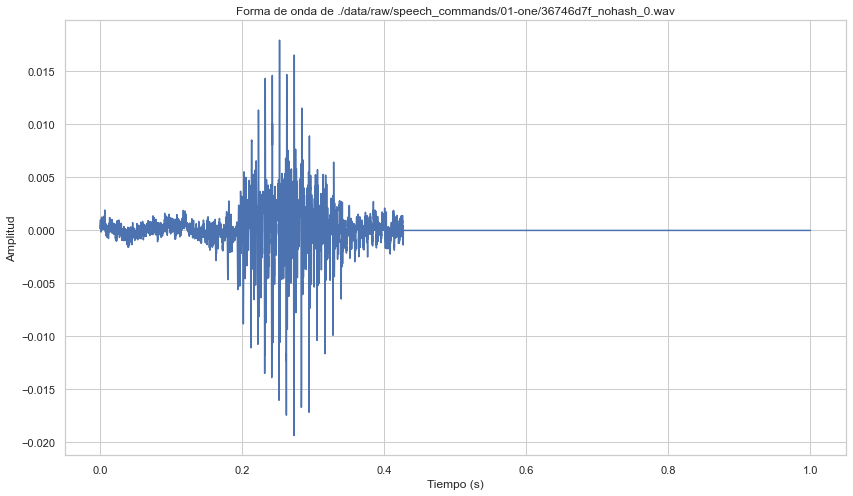

In [21]:
filename = "./data/raw/speech_commands/01-one/36746d7f_nohash_0.wav"
signal, sample_rate = librosa.load(filename, sr=None)

# Raw wave signal 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.set_title("Forma de onda de " + filename)
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Amplitud")
ax.plot(np.linspace(0, sample_rate/len(signal), sample_rate), signal)

IPython.display.Audio(filename)

Aparentemente, si nos fijamos en la forma de la onda no percibimos nada extraño. Pero si nos fijamos en la escala en la que están las amplitudes, podemos intuir el posible error, que se confirma una vez reproducimos el audio: el sonido es demasiado bajo, tanto, que apenas se puede distinguir la palabra. Esto se puede traducir en muestras erróneas en las que el sonido de fondo se confunda con el propio comando, generando malos resultados.

Queremos generalizar la búsqueda de este tipo de fallos en todo el dataset, así que procedemos a hacer un estudio de la amplitud de las ondas de cada uno de los audios. Vamos a analizar las amplitudes desde un punto de vista estadístico para intentar encontrar lo que podríamos considerar outliers. Agrupando por etiquetas, ya que determinados sonidos pueden aumentar de manera sistemática la amplitud de la onda, analizamos las amplitudes medias, mínimas y máximas de cada audio. Para los 3 casos calculamos el valor absoluto de las muestras y poder fijar así un límite arbitrario de validez, viendo la distribución de los datos. Para el caso de la amplitud media, también la calculamos directamente (sin hacer el valor absoluto de las amplitudes en cada frame).

In [22]:
amplitudes_df = pd.DataFrame(columns=["min_abs", "max_abs", "mean", "mean_abs", "label", "file"])
bad_amplitudes = {}

for label in valid_labels:
    print(label)
    
    bad_amplitudes[label] = {
        "min_abs": [],
        "max_abs": [],
        "mean": [],
        "mean_abs": []
    }
    
    for file in tqdm(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/"))):
        if file.endswith(".wav"):
            filename = os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/")
            signal, sample_rate = librosa.load(filename, sr=None)
            
            minimum = np.min([abs(sample) for sample in signal])
            if minimum > 0.5:
                bad_amplitudes[label]["min_abs"].append(os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/"))
            
            maximum = np.max([abs(sample) for sample in signal])
            if maximum < 0.1:
                bad_amplitudes[label]["max_abs"].append(os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/"))
            
            mean = np.mean(signal)
            if mean < -0.05 or mean > 0.05:
                bad_amplitudes[label]["mean"].append(os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/"))
            
            mean_abs = np.mean([abs(sample) for sample in signal])
            if mean_abs < 0.2:
                bad_amplitudes[label]["mean_abs"].append(os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/"))
                
            amplitudes_df = amplitudes_df.append({"min_abs": minimum, "max_abs": maximum, "mean": mean, "mean_abs": mean_abs, "label": label, "file": filename}, ignore_index = True)
    
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    fig.suptitle("Label: " + str(label))
    
    sns.boxplot(ax=axes[0, 0], x=amplitudes_summary[label]["mean"])
    axes[0, 0].set_title("Mean amplitude")
    
    sns.boxplot(ax=axes[0, 1], x=amplitudes_summary[label]["mean_abs"])
    axes[0, 1].set_title("Mean absolute amplitude")
    
    sns.boxplot(ax=axes[1, 0], x=amplitudes_summary[label]["max_abs"])
    axes[1, 0].set_title("Max absolute amplitude")
    
    sns.boxplot(ax=axes[1, 1], x=amplitudes_summary[label]["min_abs"])
    axes[1, 1].set_title("Min absolute amplitude")

    plt.show()
    """

00-zero


100%|██████████| 2376/2376 [00:31<00:00, 75.14it/s]


01-one


100%|██████████| 2370/2370 [00:31<00:00, 74.46it/s]


02-two


100%|██████████| 2372/2372 [00:33<00:00, 71.66it/s]


03-three


100%|██████████| 2355/2355 [00:33<00:00, 69.88it/s]


04-four


100%|██████████| 2372/2372 [00:33<00:00, 69.81it/s]


05-five


100%|██████████| 2357/2357 [00:28<00:00, 81.37it/s]


06-six


100%|██████████| 2369/2369 [00:39<00:00, 59.24it/s]


07-seven


100%|██████████| 2376/2376 [00:39<00:00, 59.56it/s]


08-eight


100%|██████████| 2351/2351 [00:39<00:00, 60.21it/s]


09-nine


100%|██████████| 2364/2364 [00:39<00:00, 59.37it/s]


10-on


100%|██████████| 2366/2366 [00:39<00:00, 59.21it/s]


11-off


100%|██████████| 2357/2357 [00:39<00:00, 58.93it/s]


12-up


100%|██████████| 2375/2375 [00:40<00:00, 59.09it/s]


13-down


100%|██████████| 2358/2358 [00:38<00:00, 61.73it/s]


14-left


100%|██████████| 2352/2352 [00:29<00:00, 79.77it/s]


15-right


100%|██████████| 2367/2367 [00:29<00:00, 78.98it/s]


16-yes


100%|██████████| 2377/2377 [00:30<00:00, 77.69it/s]


17-no


100%|██████████| 2375/2375 [00:41<00:00, 57.76it/s]


Mostramos los boxplots añadiendo la distribución real de los datos para observar gráficamente los resultados e intentar extraer conclusiones.

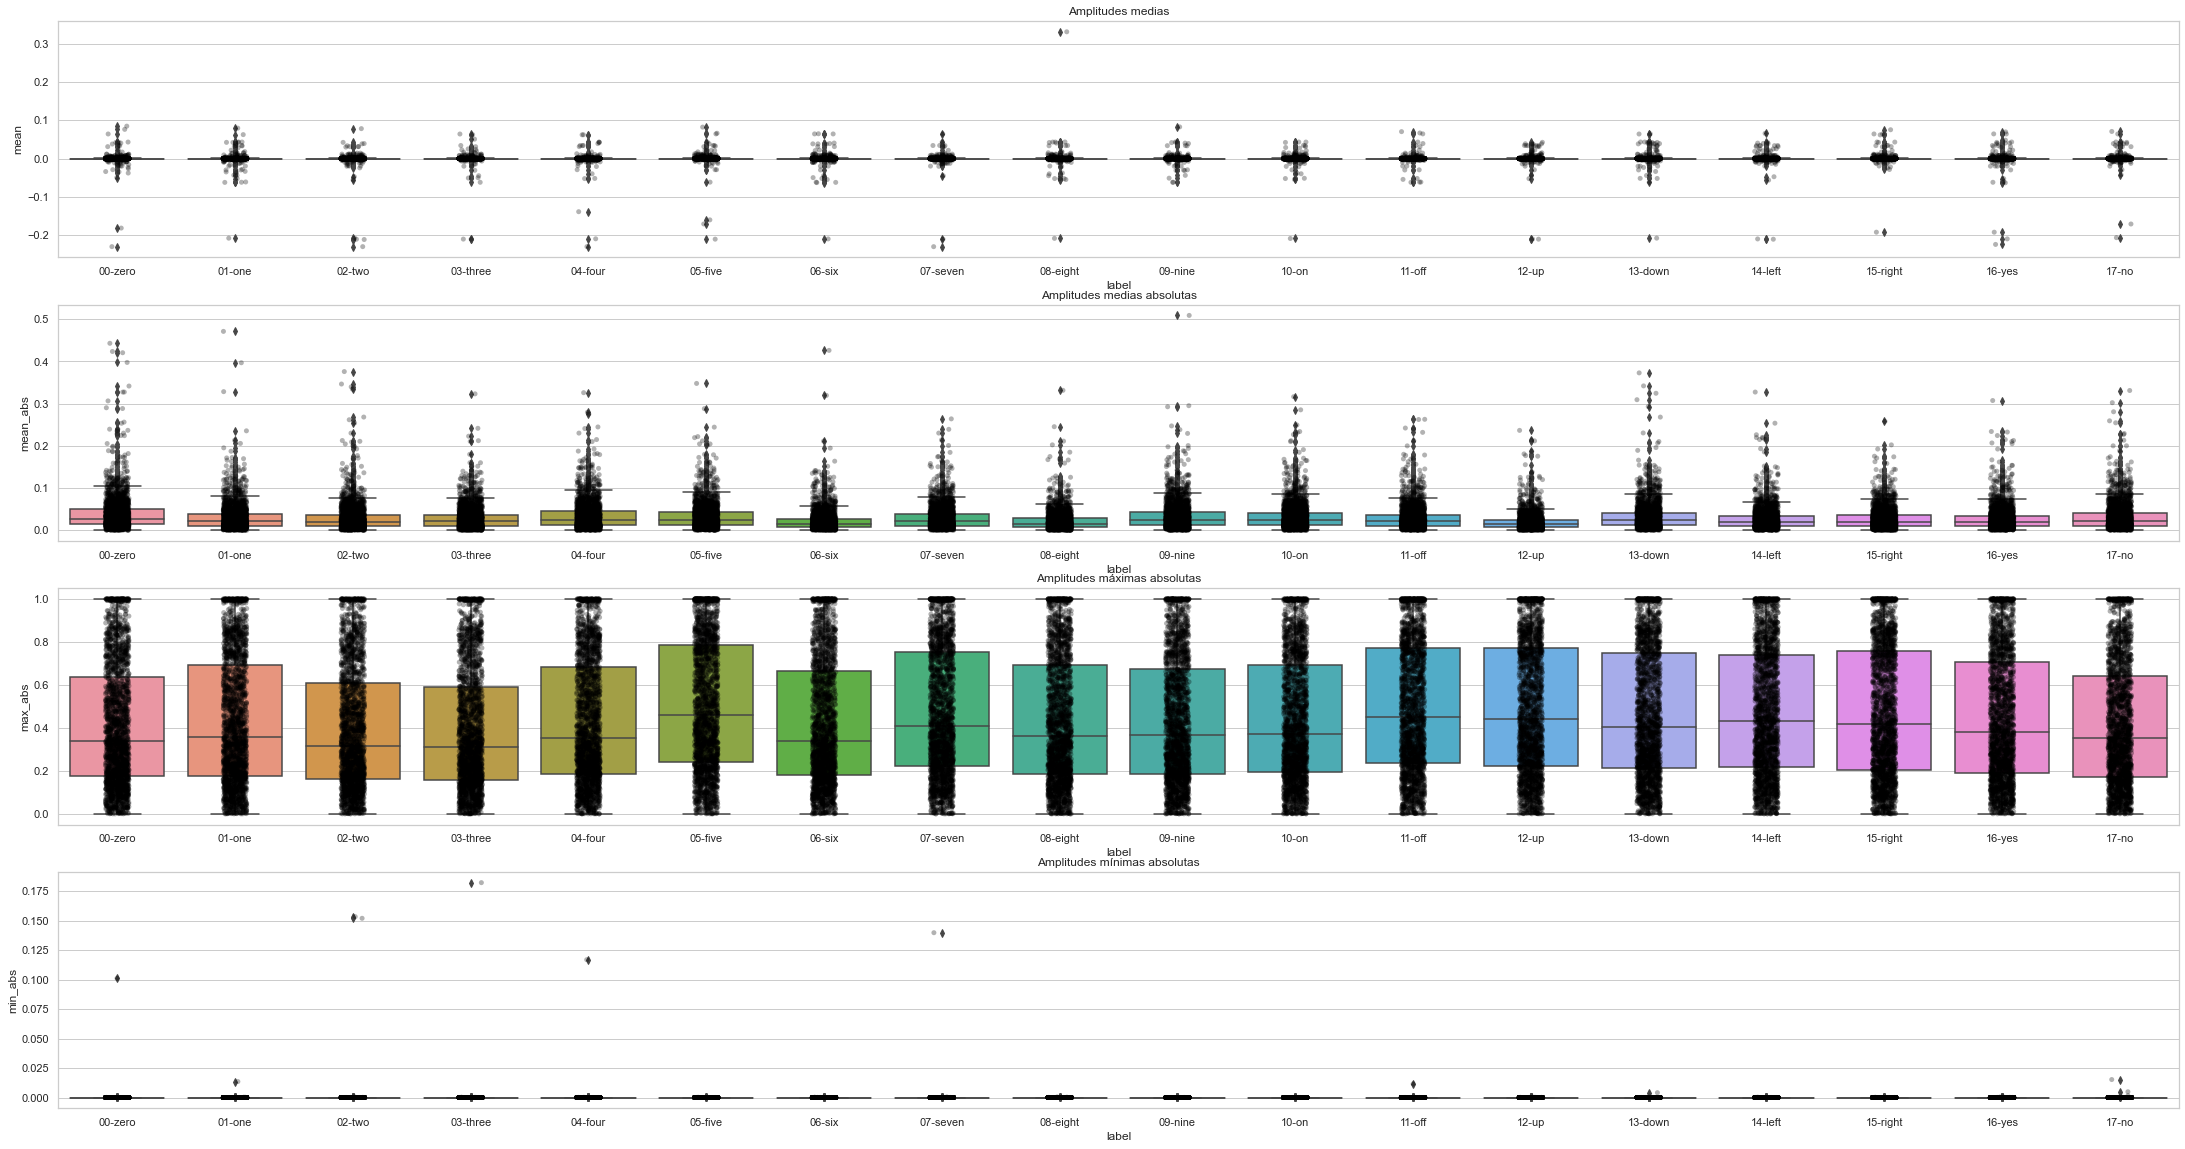

In [23]:
fig, axes = plt.subplots(4, 1, figsize=(38, 20))

sns.boxplot(ax=axes[0], data=amplitudes_df, x="label", y="mean")
sns.stripplot(ax=axes[0], data=amplitudes_df, x="label", y="mean", color="black", alpha=0.3)
axes[0].set_title("Amplitudes medias")

sns.boxplot(ax=axes[1], data=amplitudes_df, x="label", y="mean_abs")
sns.stripplot(ax=axes[1], data=amplitudes_df, x="label", y="mean_abs", color="black", alpha=0.3)
axes[1].set_title("Amplitudes medias absolutas")

sns.boxplot(ax=axes[2], data=amplitudes_df, x="label", y="max_abs")
sns.stripplot(ax=axes[2], data=amplitudes_df, x="label", y="max_abs", color="black", alpha=0.3)
axes[2].set_title("Amplitudes máximas absolutas")


sns.boxplot(ax=axes[3], data=amplitudes_df, x="label", y="min_abs")
sns.stripplot(ax=axes[3], data=amplitudes_df, x="label", y="min_abs", color="black", alpha=0.3)
axes[3].set_title("Amplitudes mínimas absolutas")

plt.show()

Del gráfico de la media de las amplitudes normales no obtenemos información relevante. La amplitud media está en 0 en la gran mayoria los casos, como se debería esperar, ya que las amplitudes positivas deberían cancelarse con las negativas. Se detecta algún posible outlier si la amplitud media está muy alejada de 0, pero después de una investigación individual se ve si el audio es válido o no. La gran mayoría de audios catalogados como posibles outliers sí que son válidos, y es únicamente que la forma de la onda está desplazada en el eje y o que la forma de la onda es extraña pero el audio es válido.

Mostramos un ejemplo en el que el audio no es válido.

In [24]:
amplitudes_df[amplitudes_df["mean"] > 0.2][amplitudes_df["label"] == "08-eight"]

<ipython-input-24-98eef13d438b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  amplitudes_df[amplitudes_df["mean"] > 0.2][amplitudes_df["label"] == "08-eight"]


min_abs   max_abs      mean  mean_abs     label  \
20001  0.000519  0.999969  0.331275  0.331667  08-eight   

                                                    file  
20001  ./data/raw/speech_commands/08-eight/77def3ee_n...

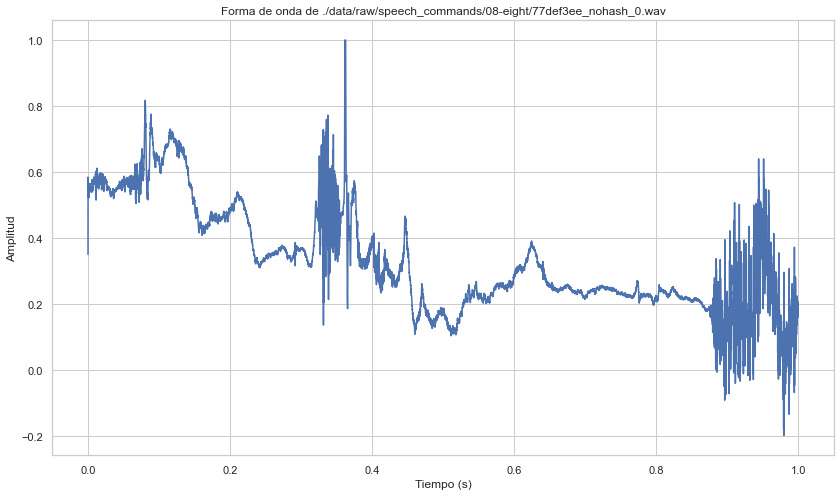

In [25]:
filename = "./data/raw/speech_commands/08-eight/77def3ee_nohash_0.wav"
signal, sample_rate = librosa.load(filename, sr=None)

# Raw wave signal 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.set_title("Forma de onda de " + filename)
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Amplitud")
ax.plot(np.linspace(0, sample_rate/len(signal), sample_rate), signal)

IPython.display.Audio(filename)

In [26]:
to_del_amplitudes = []
to_del_amplitudes.append("./data/raw/speech_commands/08-eight/77def3ee_nohash_0.wav")

Mostramos otro ejemplo en el que el audio sí que es válido finalmente.

In [27]:
amplitudes_df[amplitudes_df["mean"] < -0.2][amplitudes_df["label"] == "16-yes"]

<ipython-input-27-4599a78712f6>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  amplitudes_df[amplitudes_df["mean"] < -0.2][amplitudes_df["label"] == "16-yes"]


min_abs   max_abs      mean  mean_abs   label  \
38842  0.00000  0.389587 -0.224514  0.224514  16-yes   
40053  0.00061  0.748718 -0.210037  0.214932  16-yes   

                                                    file  
38842  ./data/raw/speech_commands/16-yes/7014b07e_noh...  
40053  ./data/raw/speech_commands/16-yes/ee4a907f_noh...

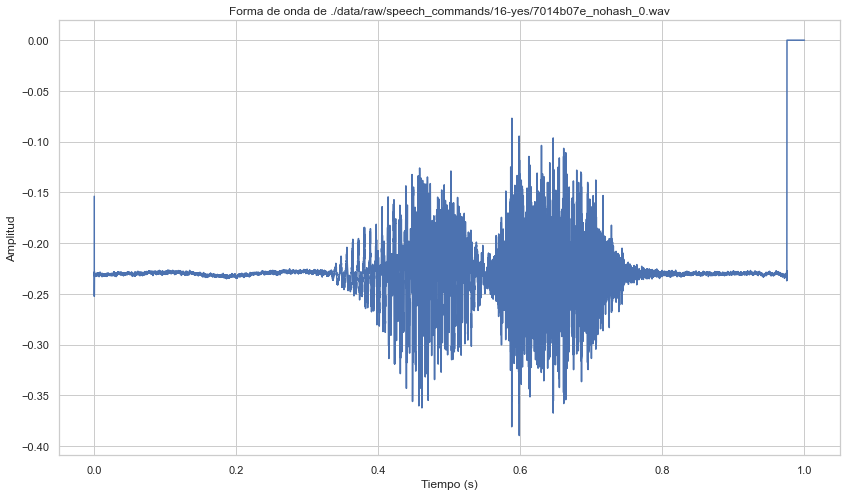

In [28]:
filename = "./data/raw/speech_commands/16-yes/7014b07e_nohash_0.wav"
signal, sample_rate = librosa.load(filename, sr=None)

# Raw wave signal 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.set_title("Forma de onda de " + filename)
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Amplitud")
ax.plot(np.linspace(0, sample_rate/len(signal), sample_rate), signal)

IPython.display.Audio(filename)

Del gráfico de la media absoluta de las amplitudes tampoco sacamos mucha información relevante. Como es de esperar, la amplitud media ha crecido un poco, pero sigue manteniéndose en límites válidos que no presentan indicios de error. Se inspeccionan algunos audios que presentan amplitudes medias un poco más elevadas, pero se verifica que todos ellos son válidos, aunque la calidad de los audios en algunos casos presenta cierta distorsión o se percibe cierto ruido constante de fondo.

In [29]:
amplitudes_df[amplitudes_df["mean_abs"] > 0.35]

min_abs   max_abs      mean  mean_abs    label  \
1460       0.0  1.000000 -0.022807  0.420788  00-zero   
1461       0.0  1.000000 -0.034067  0.423755  00-zero   
1462       0.0  1.000000 -0.011933  0.443159  00-zero   
2285       0.0  1.000000 -0.012620  0.397802  00-zero   
2418       0.0  1.000000 -0.036285  0.397029   01-one   
2419       0.0  1.000000 -0.002631  0.471364   01-one   
4799       0.0  1.000000 -0.016841  0.376132   02-two   
14250      0.0  0.988892  0.013052  0.426346   06-six   
21347      0.0  1.000000 -0.017902  0.509218  09-nine   
32204      0.0  1.000000 -0.033822  0.373021  13-down   

                                                    file  
1460   ./data/raw/speech_commands/00-zero/a42a88ff_no...  
1461   ./data/raw/speech_commands/00-zero/a42a88ff_no...  
1462   ./data/raw/speech_commands/00-zero/a42a88ff_no...  
2285   ./data/raw/speech_commands/00-zero/f638a812_no...  
2418   ./data/raw/speech_commands/01-one/0487ba9b_noh...  
2419   ./data/raw/speech_commands/01-one/0487ba9b_noh...  
4799   ./data/raw/speech_commands/02-two/0487ba9b_noh...  
14250  ./data/raw/speech_commands/06-six/03cf93b1_noh...  
21347  ./data/raw/speech_commands/09-nine/0487ba9b_no...  
32204  ./data/raw/speech_commands/13-down/a42a88ff_no...

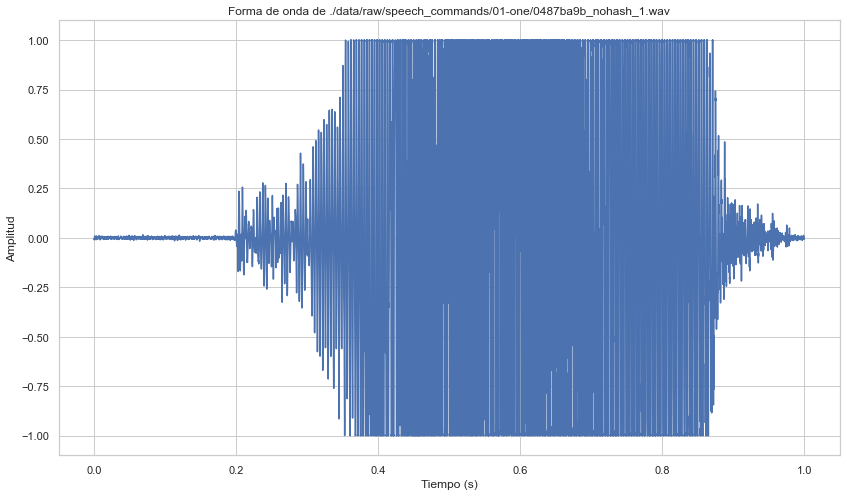

In [30]:
filename = "./data/raw/speech_commands/01-one/0487ba9b_nohash_1.wav"
signal, sample_rate = librosa.load(filename, sr=None)

# Raw wave signal 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.set_title("Forma de onda de " + filename)
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Amplitud")
ax.plot(np.linspace(0, sample_rate/len(signal), sample_rate), signal)

IPython.display.Audio(filename)

Del gráfico de los mínimos absolutos tampoco tenemos información relevante. Como es de esperar, en prácticamente todos los casos el mínimo es 0, y los valores diferentes son prácticamente 0 también.

Sin embargo, del gráfico de los máximos absolutos sí que obtenemos información que puede ser importante y útil para encontrar audios no válidos de forma sistemática. Intuitivamente se esperaría que la amplitud máxima detectada debería ser un valor alejado de cero. Sin embargo, vemos que la distribución de los valores es bastante constante entre 0 y 1. Los valores superiores no suponen problema, es lo que esperábamos. Sin embargo, los valores muy próximos a 0 pueden indicar que el audio no presenta sonido o que es imperceptible lo que se está diciendo. Inspeccionando los resultados de los audios por etiqueta, fijamos un límite inferior a partir del que el valor máximo absoluto implica una muestra errónea (viendo que la secuencia se repite, se decide fijar un límite común en una amplitud máxima de 0.06). De manera general se permiten audios que tengan una intensidad baja (pensando que el modelo de speech recognition de los comandos también debería detectar comandos bajitos, por ejemplo si la persona está lejos del dispositivo de captura de audio) pero es necesario fijar un límite para evitar muestras inválidas.

In [31]:
for filename in list(amplitudes_df[amplitudes_df["max_abs"] < 0.05]["file"]):
    to_del_amplitudes.append(filename)

In [32]:
for file in to_del_amplitudes:
    try:
        os.remove(file)
    except FileNotFoundError as e:
        print(e)

Ahora que finalmente el dataset está más o menos limpiado y estandarizado, mostramos ejemplos por etiqueta de la forma de onda y el espectro de Mel de algunos audios.

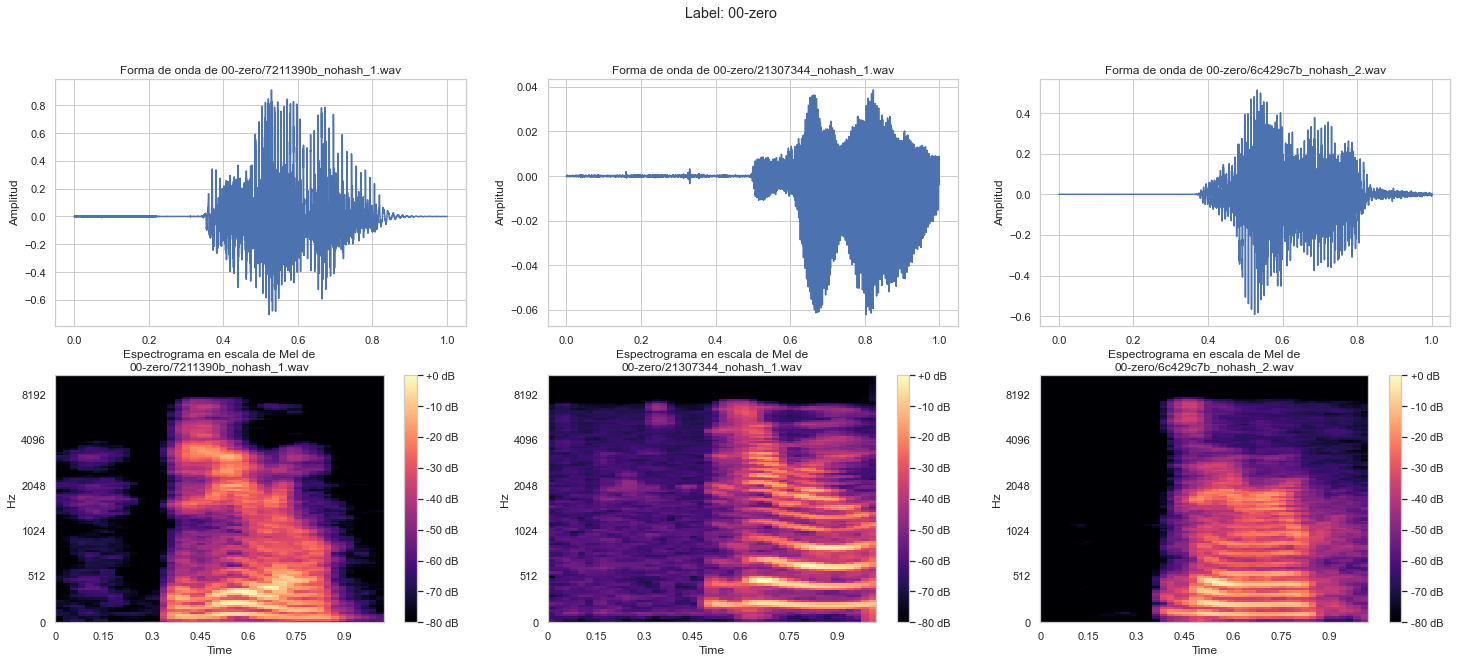

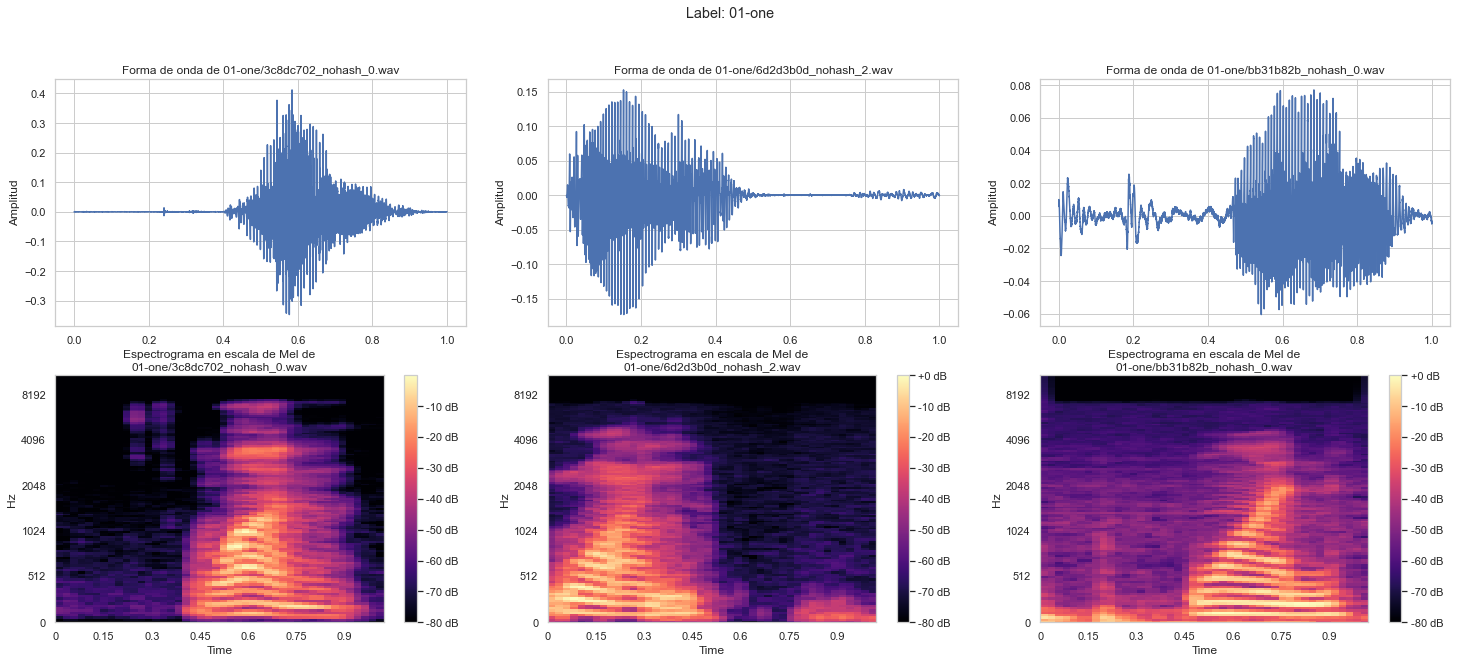

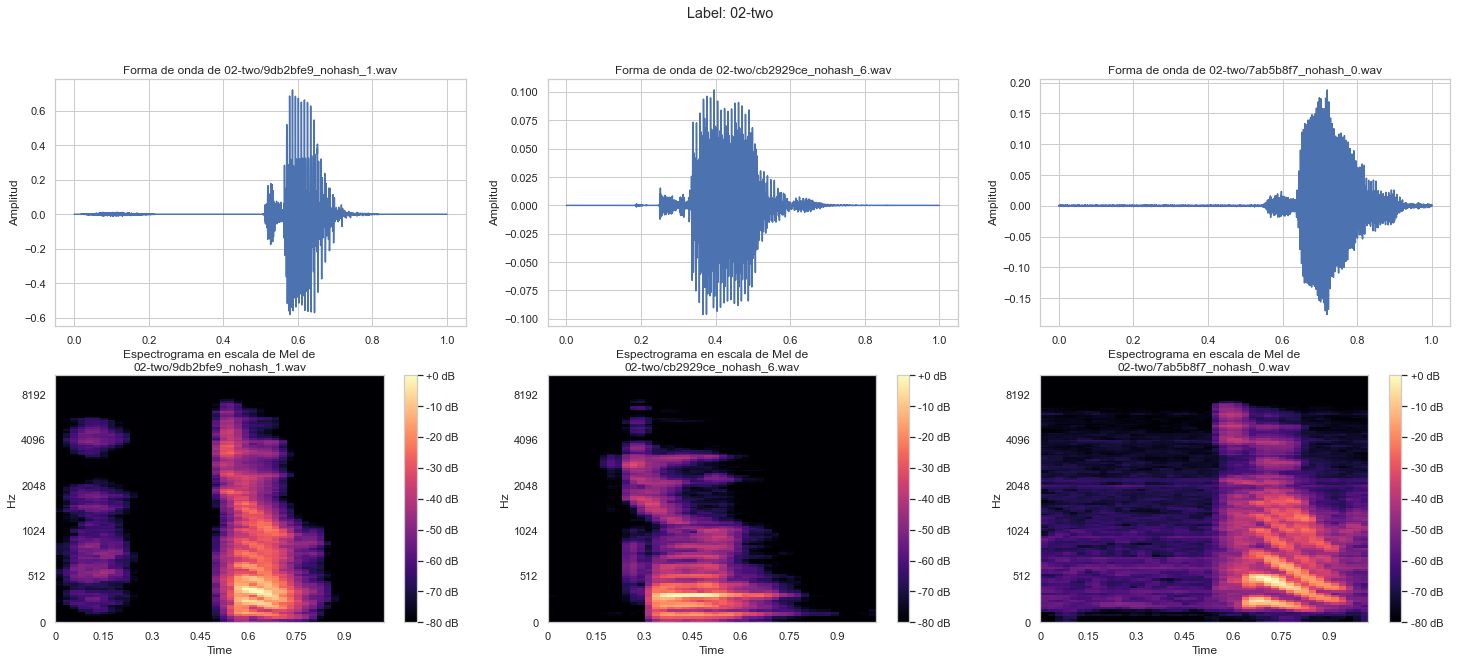

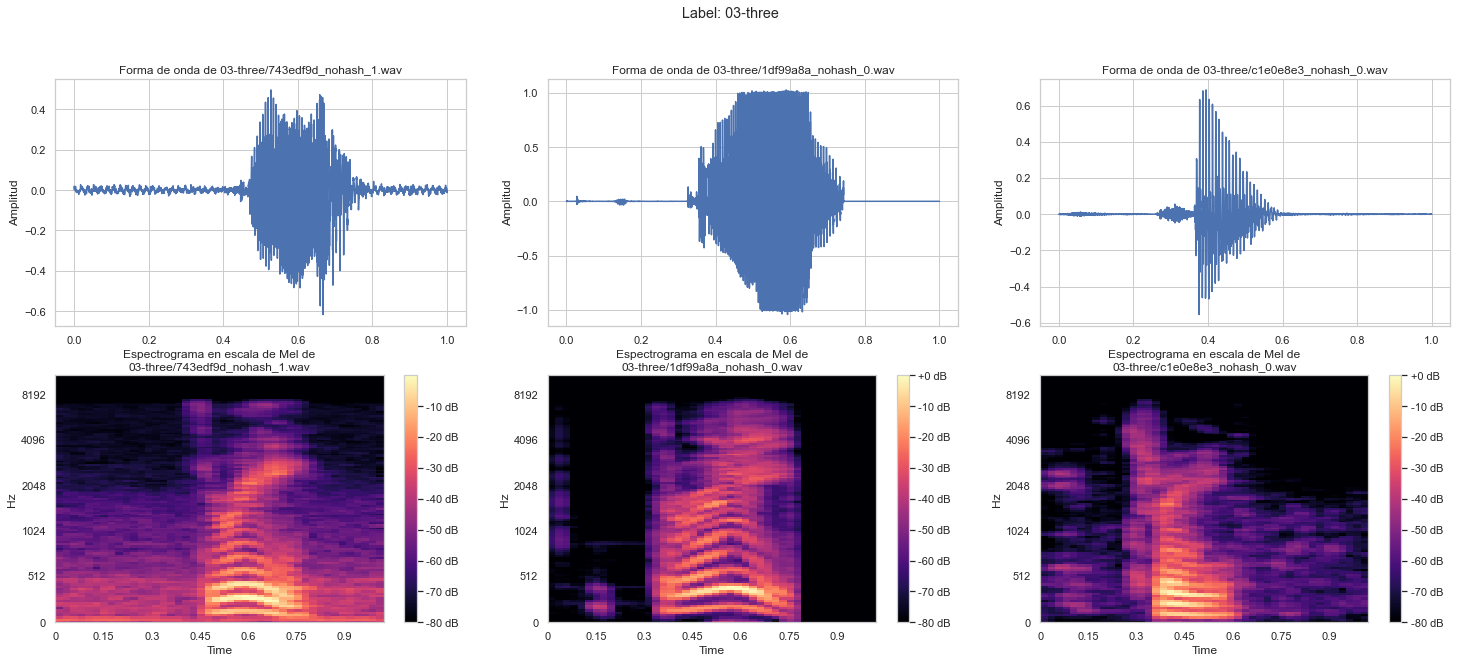

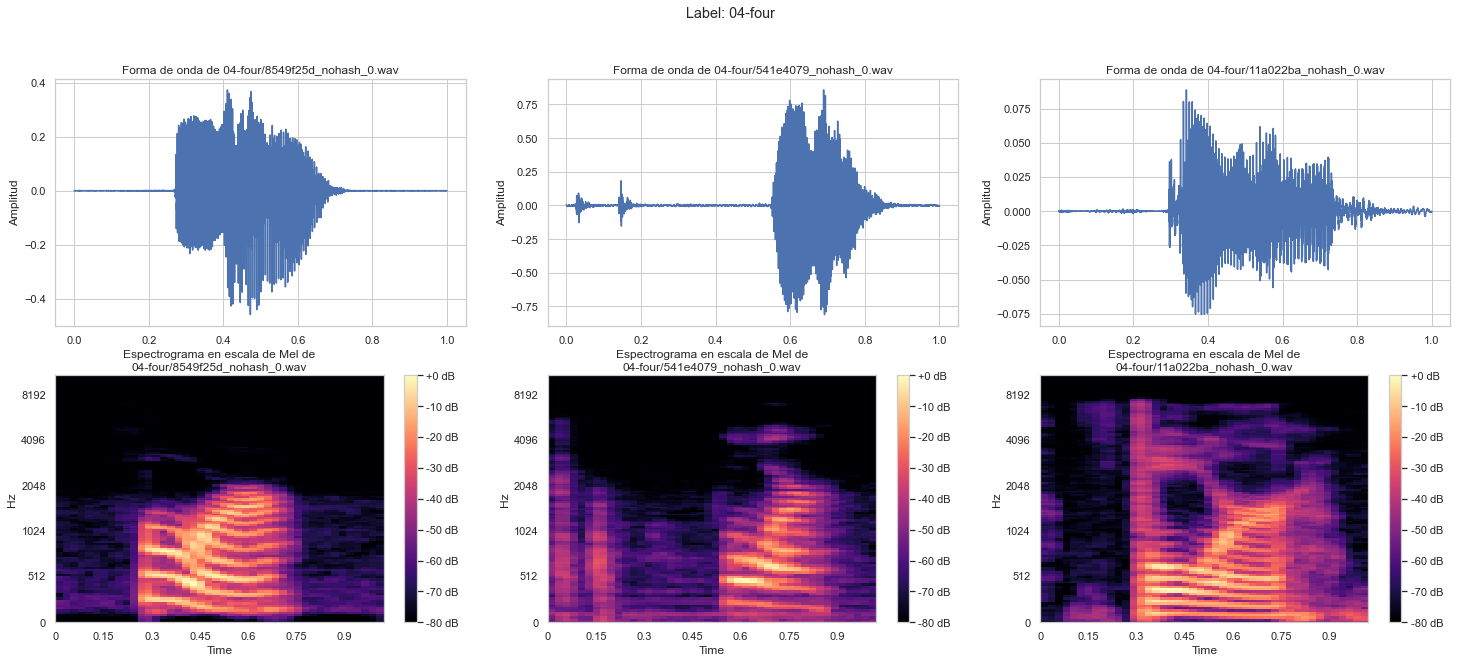

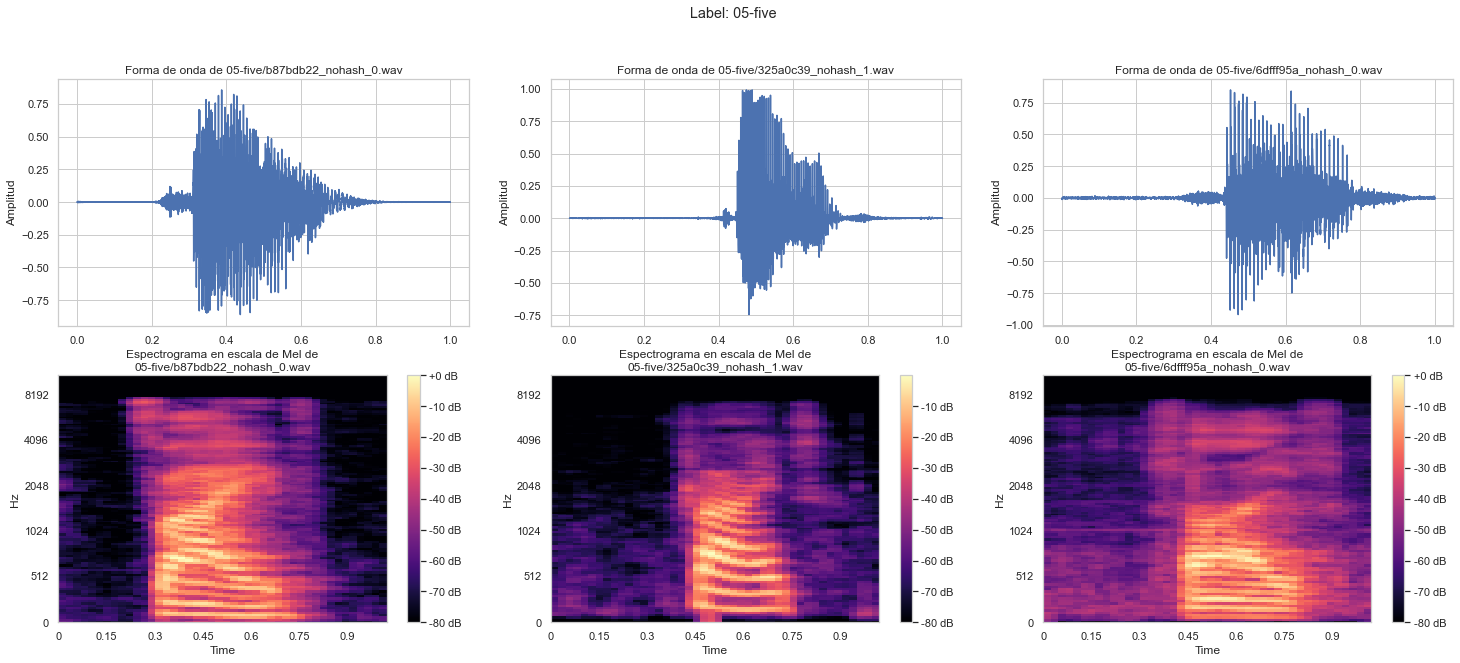

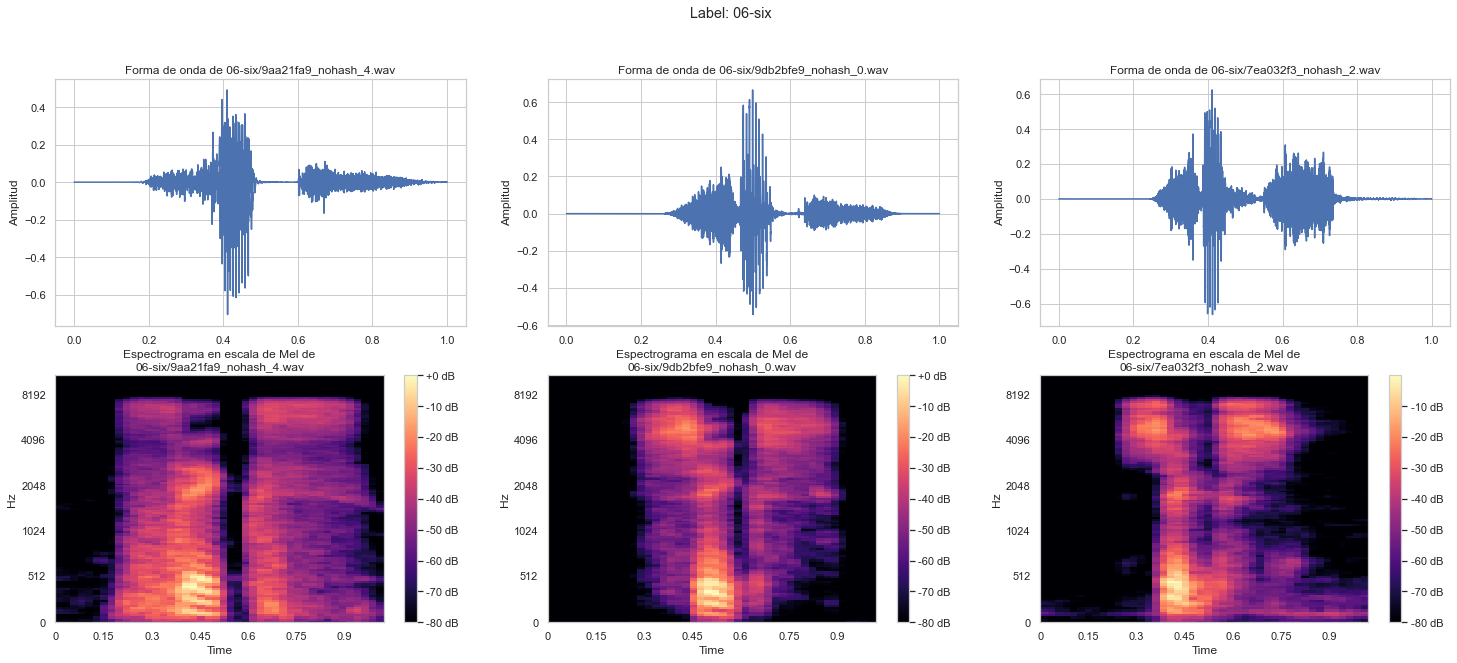

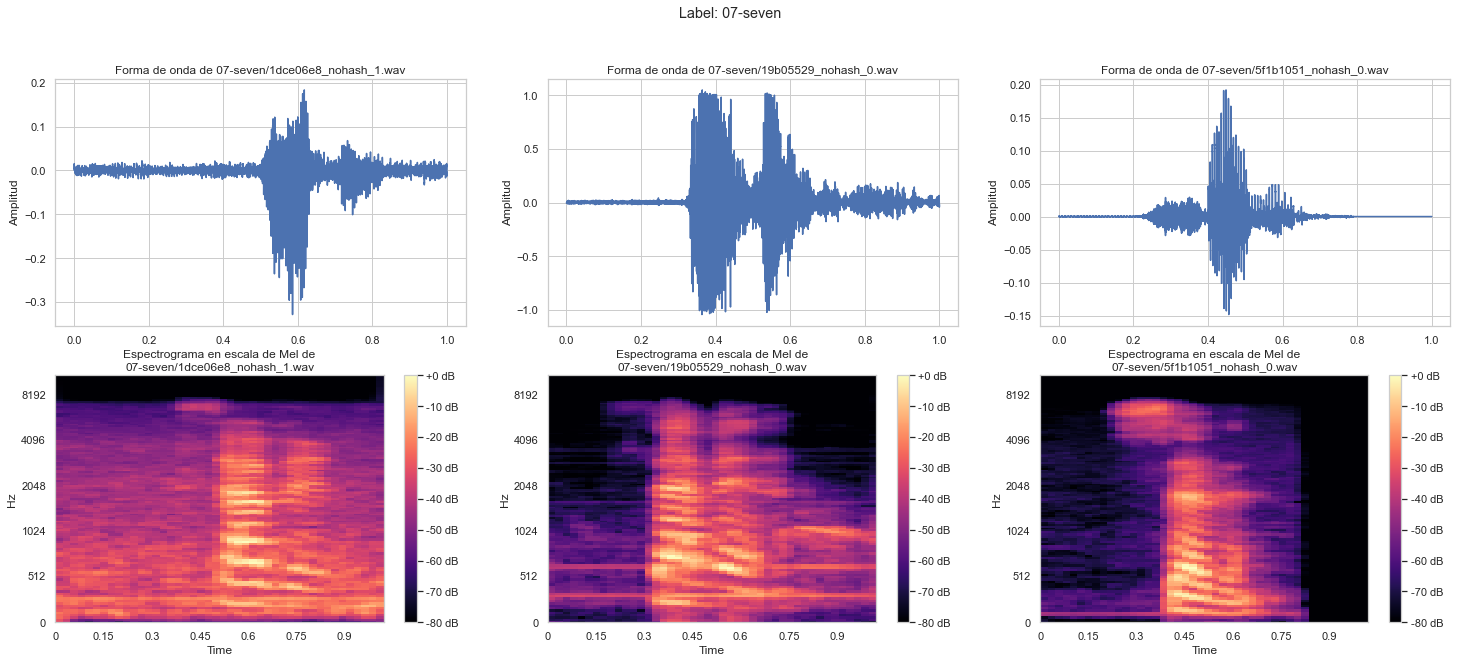

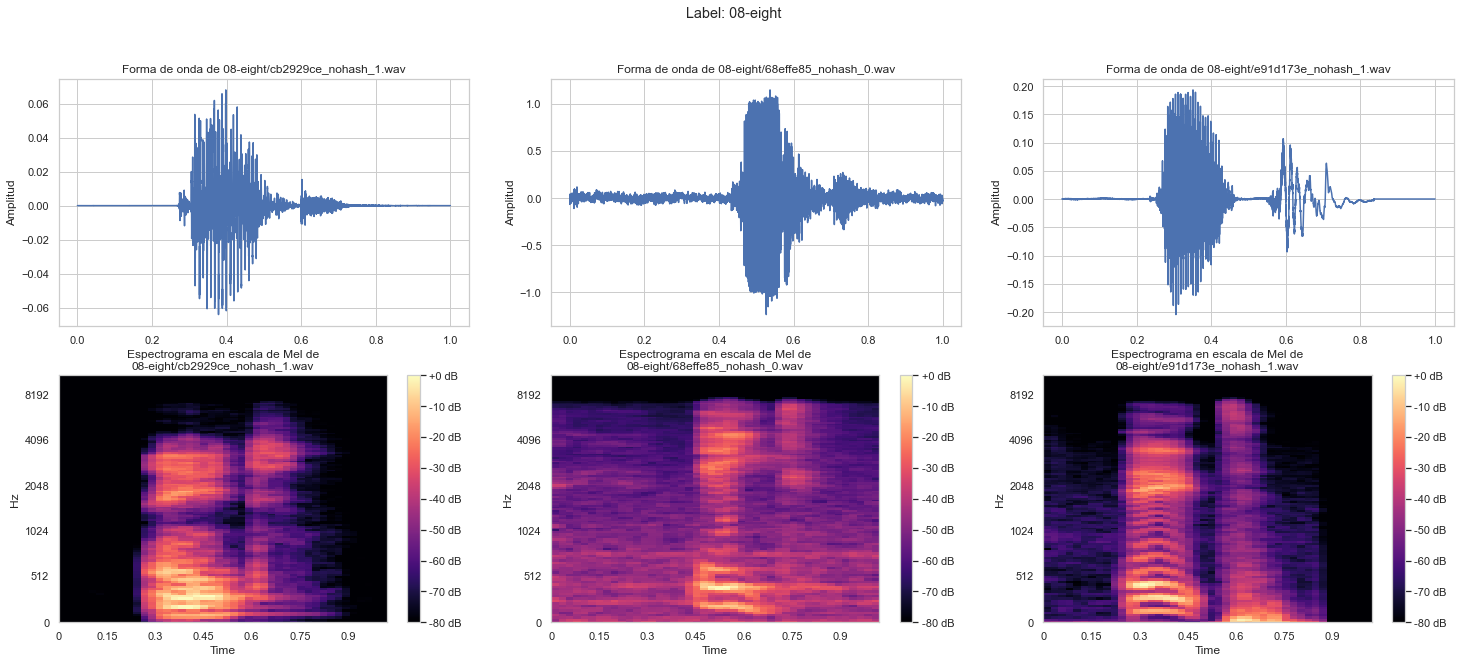

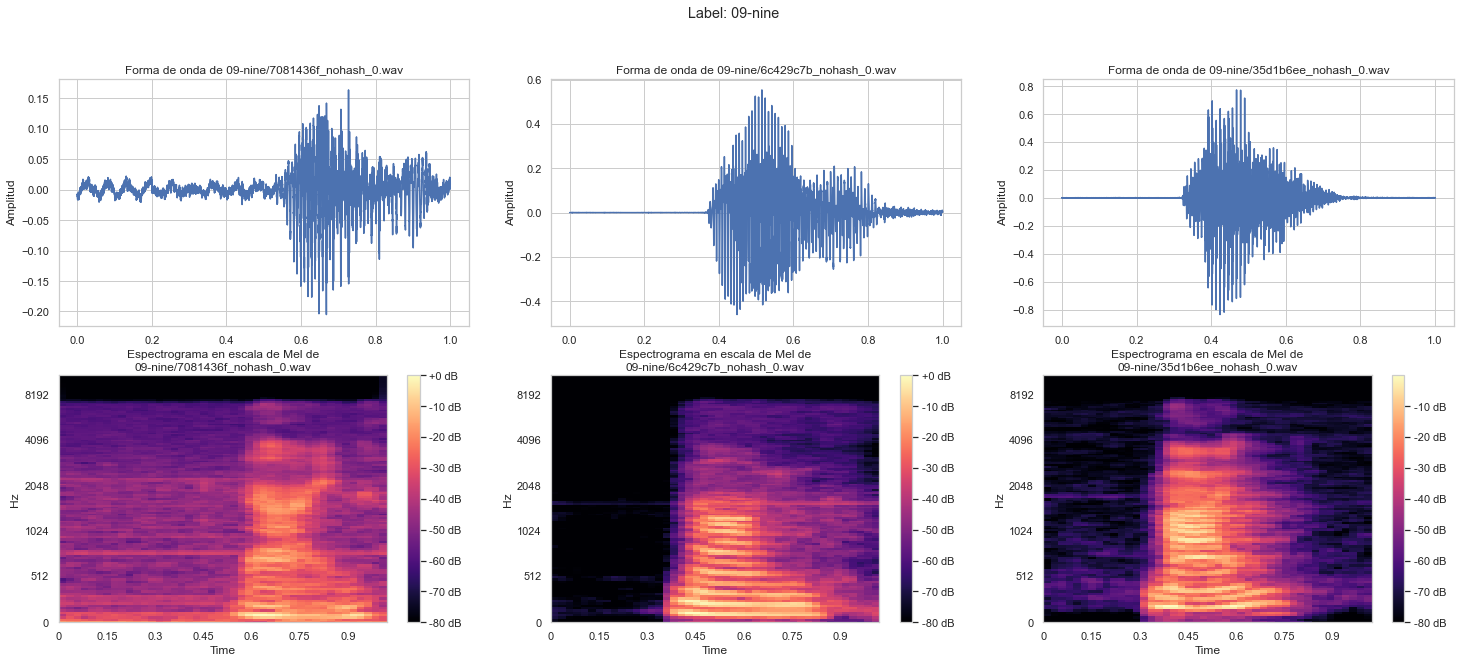

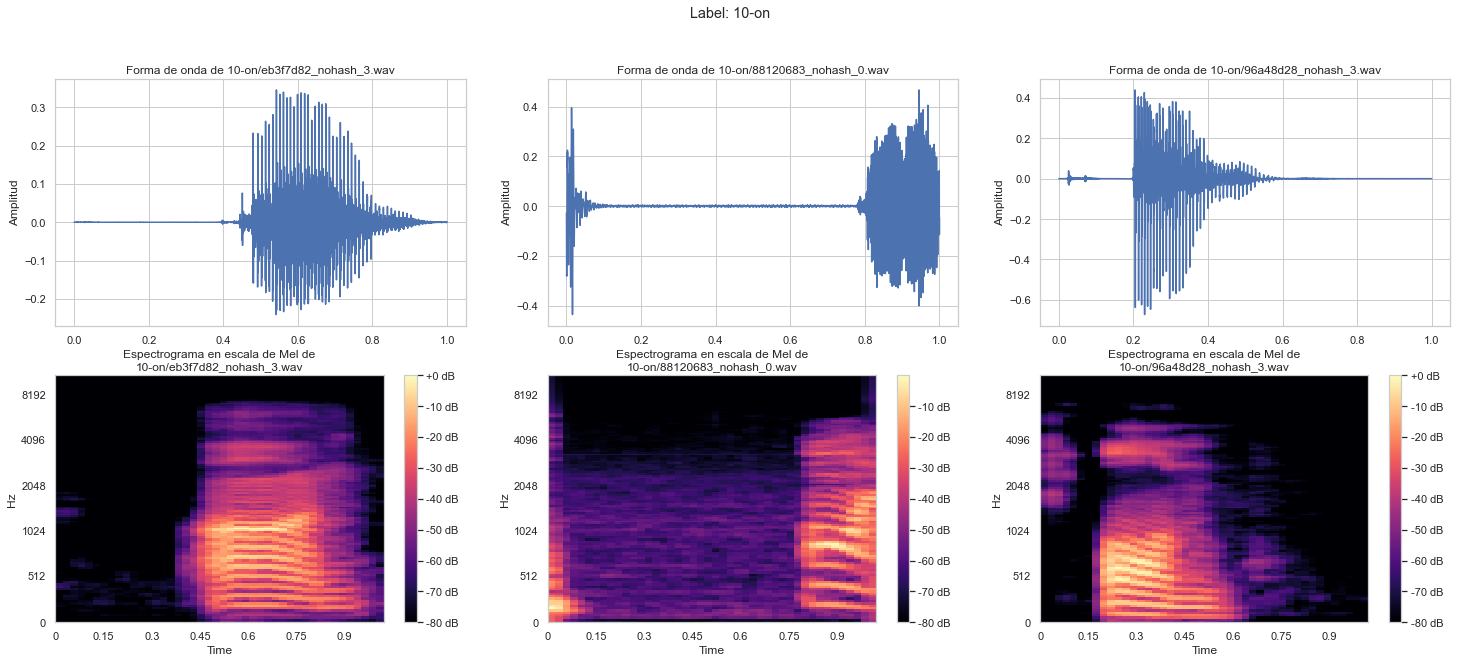

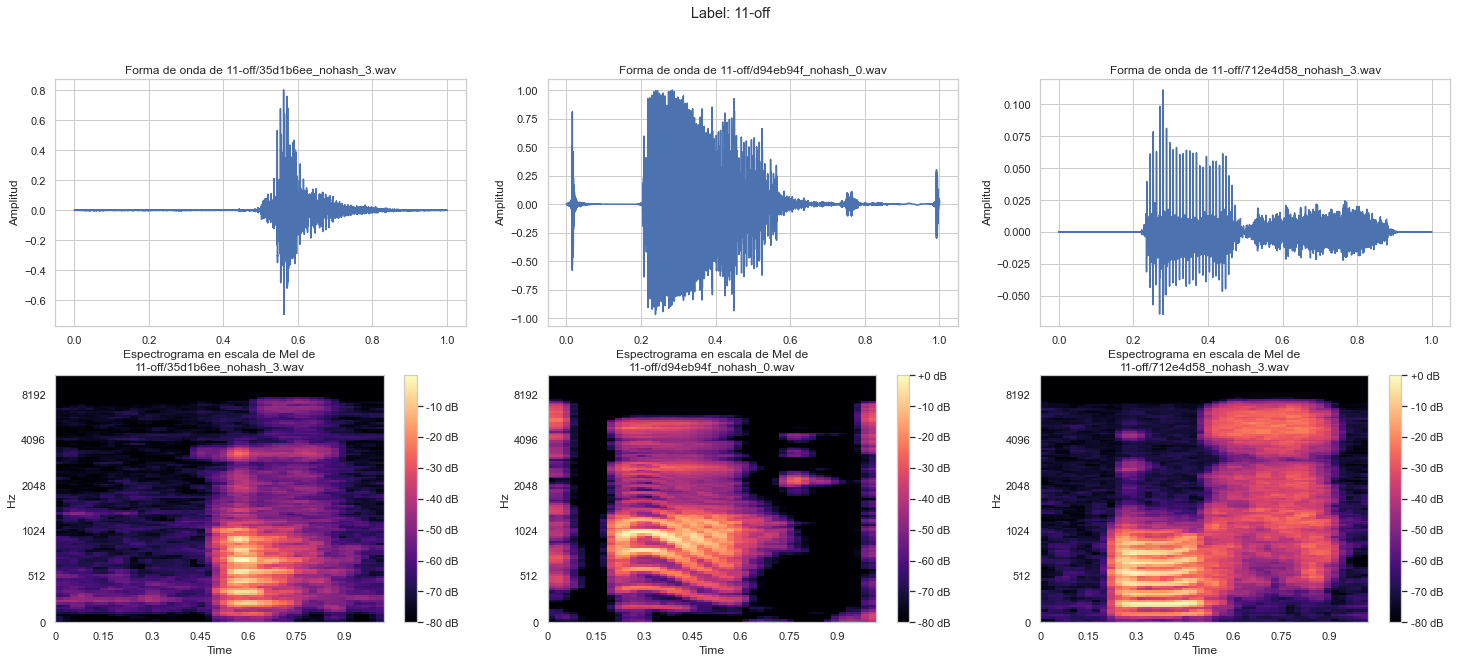

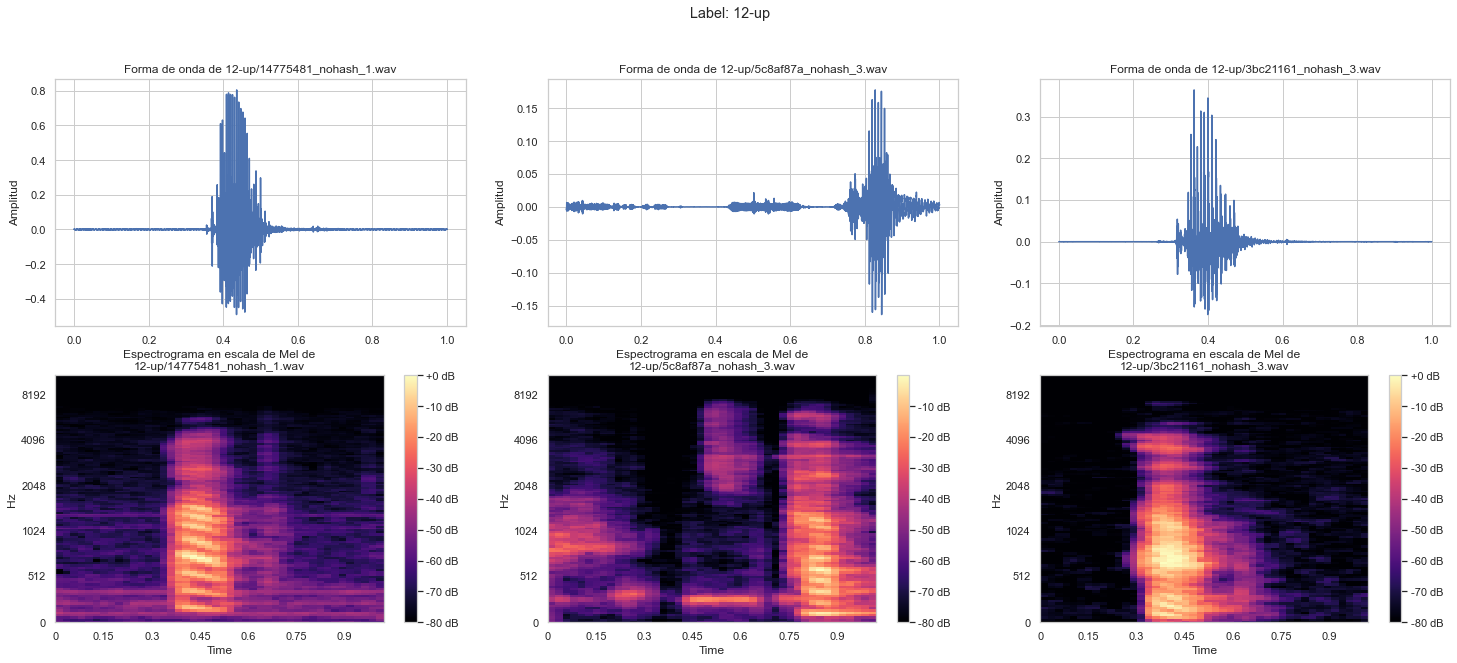

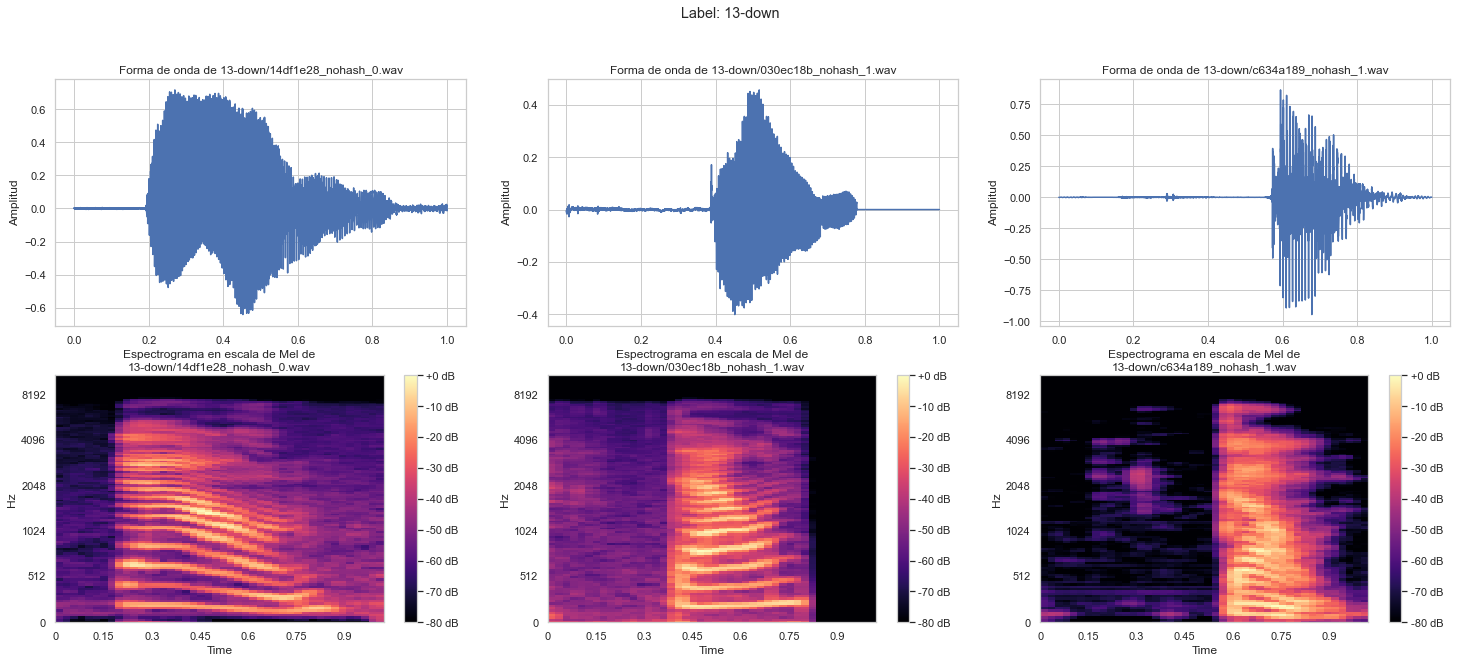

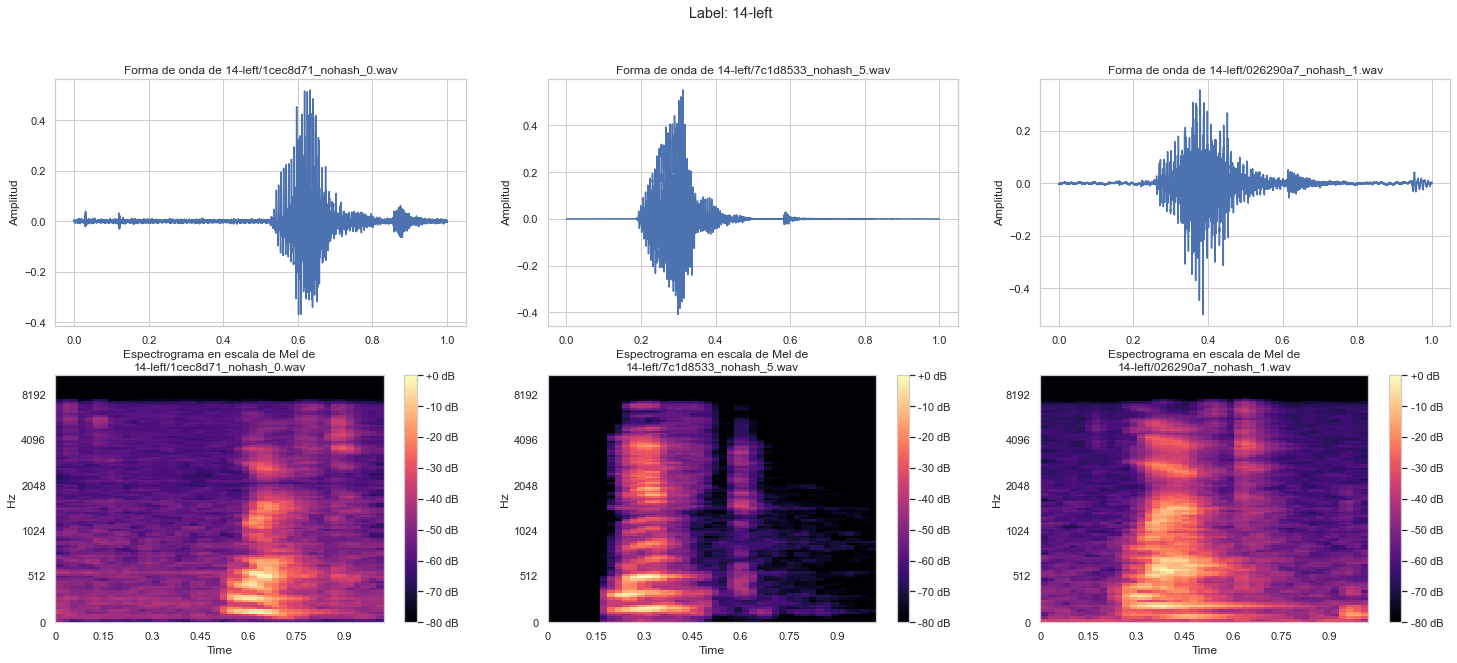

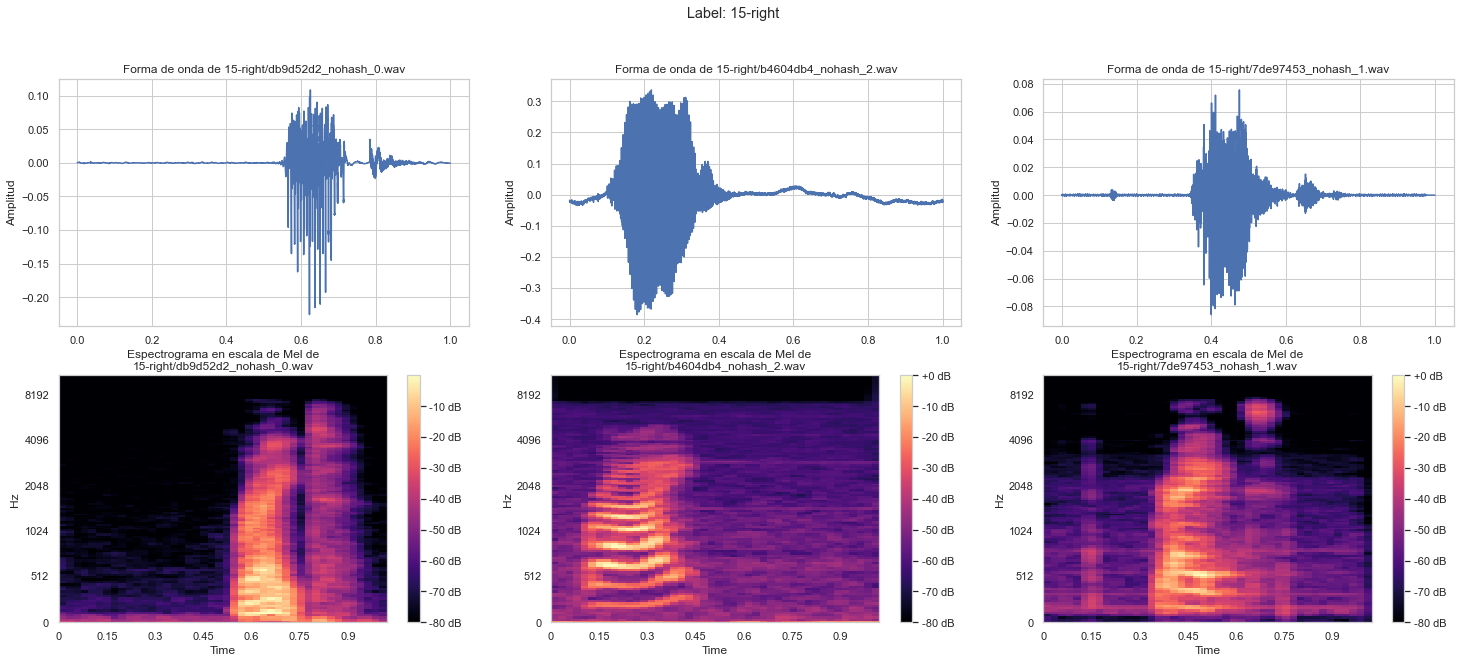

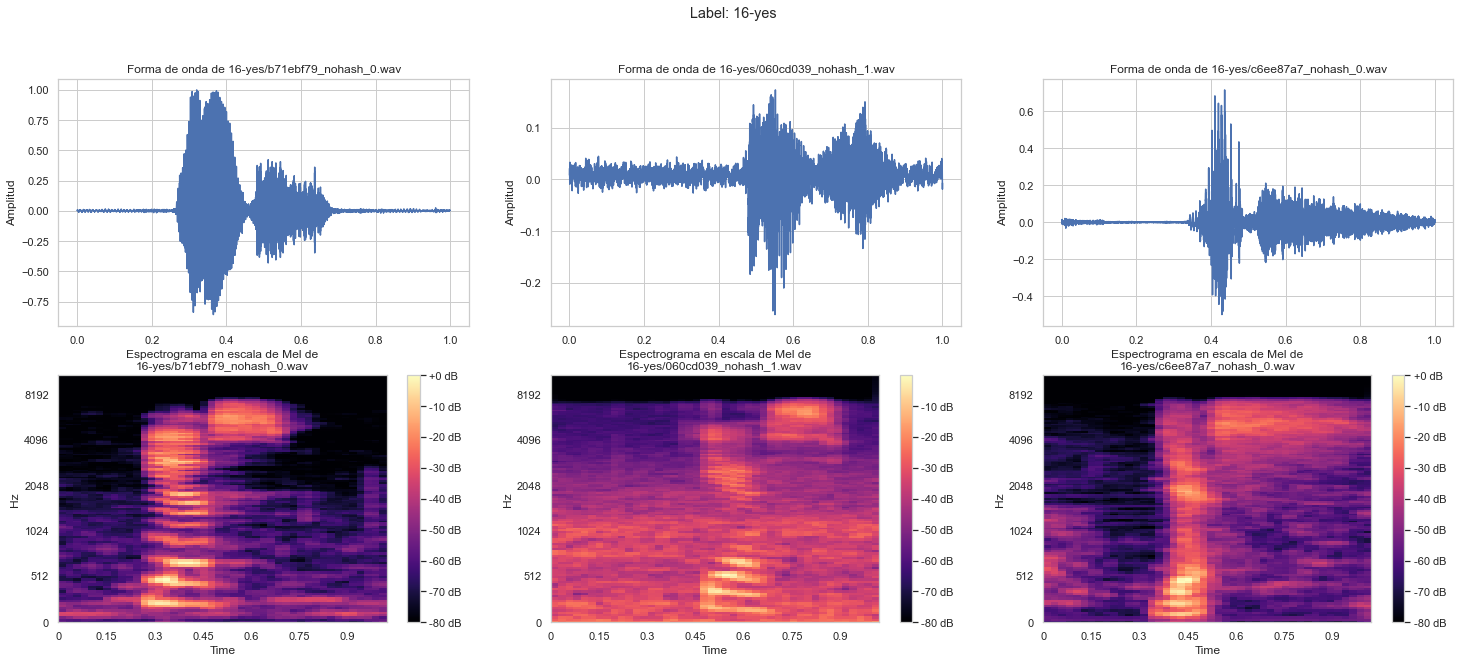

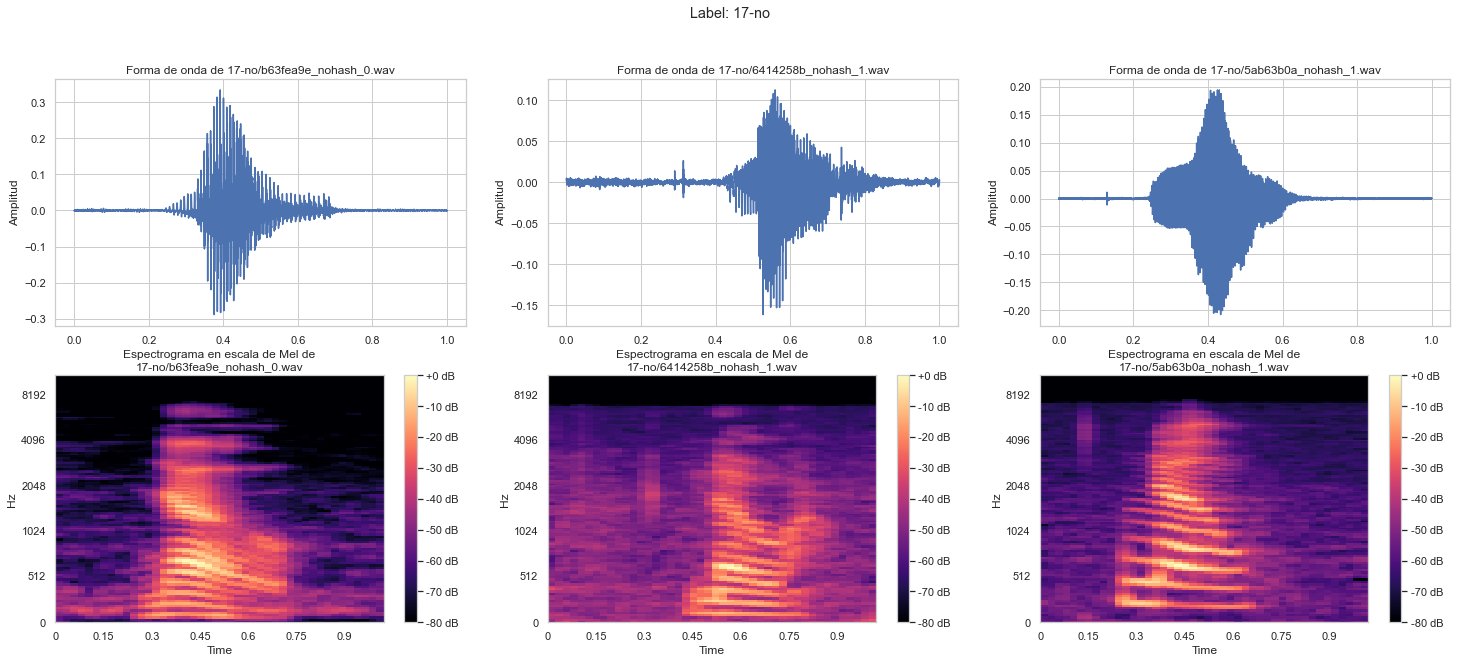

In [33]:
for label in valid_labels:
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

    # FIRST AUDIO PER LABEL
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)

    # Raw wave signal    
    ax[0, 0].set_title("Forma de onda de " + filename)
    ax[0, 0].set_ylabel("Amplitud")
    ax[0, 0].plot(np.linspace(0, sample_rate/len(signal), sample_rate), signal)
    
    # Log mel spectrogram
    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate)
    log_melspec = librosa.power_to_db(melspec, ref=np.max)
    img = librosa.display.specshow(log_melspec, x_axis="time", y_axis="mel", sr=sample_rate, ax=ax[1, 0])
    ax[1, 0].set(title="Espectrograma en escala de Mel de\n" + filename)
    #ax[1, 0].label_outer()
    fig.colorbar(img, ax=ax[1, 0], format="%+2.f dB")
    
    
    # SECOND AUDIO PER LABEL
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)
    
    # Raw wave signal    
    ax[0, 1].set_title("Forma de onda de " + filename)
    ax[0, 1].set_ylabel("Amplitud")
    ax[0, 1].plot(np.linspace(0, sample_rate/len(signal), sample_rate), signal)
    
    # Log mel spectrogram
    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate)
    log_melspec = librosa.power_to_db(melspec, ref=np.max)
    img = librosa.display.specshow(log_melspec, x_axis="time", y_axis="mel", sr=sample_rate, ax=ax[1, 1])
    ax[1, 1].set(title="Espectrograma en escala de Mel de\n" + filename)
    #ax[1, 1].label_outer()
    fig.colorbar(img, ax=ax[1, 1], format="%+2.f dB")


    # THIRD AUDIO PER LABEL
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)

    # Raw wave signal    
    ax[0, 2].set_title("Forma de onda de " + filename)
    ax[0, 2].set_ylabel("Amplitud")
    ax[0, 2].plot(np.linspace(0, sample_rate/len(signal), sample_rate), signal)
    
    # Log mel spectrogram
    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate)
    log_melspec = librosa.power_to_db(melspec, ref=np.max)
    img = librosa.display.specshow(log_melspec, x_axis="time", y_axis="mel", sr=sample_rate, ax=ax[1, 2])
    ax[1, 2].set(title="Espectrograma en escala de Mel de\n" + filename)
    #ax[1, 2].label_outer()
    fig.colorbar(img, ax=ax[1, 2], format="%+2.f dB")
    
    plt.suptitle("Label: " + str(label))

Visualmente se aprecia que las formas de onda y los espectros son similares para los audios de una misma etiqueta, pero en ocasiones no tan diferentes como para diferenciarlos de otras. Confiamos en el poder de las redes neuronales para extraer el conocimiento intrínseco de los datos y hacer una clasificación correcta.

### Data augmentation

Como al limpiar el conjunto de datos hemos eliminado varias muestras de cada etiqueta y el dataset como tal no era excesivamente grande, vamos a llevar a cabo un procedimiento sencillo de data augmentation. Este proceso consiste en generar artificialmente nuevas muestras a partir de los datos reales con el objetivo de abarcar una mayor parte del espacio del problema, de modo que el modelo creado se entrene con un mayor número de muestras.

Un par de apuntes necesarios sobre el data augmentation. Este procedimiento solo se lleva a cabo en el conjunto que será de entrenamiento. No tiene sentido llevarlo a cabo en el conjunto de validación o de test, porque el objetivo principal es expandir el espacio de las muestras para que el modelo generalice mejor, no para testear sobre dichas nuevas muestras. Del mismo modo, hay que tener en cuenta que el data augmentation puede servir para mejorar los resultados del modelo que se entrene, pero siempre se conseguirá un resultado más generalizado si el conjunto de datos inicial es más extenso y diverso. En nuestro caso disponemos de un conjunto de datos limitado, así que vamos a aplicar data augmentation para intentar equilibrar el haber eliminado datos erróneos.

El data augmentation se puede aplicar prácticamente en cualquier conjunto de datos, pero se aplicará de una forma o de otra dependiendo de la naturaleza de los datos. Particularizando en el caso de datos de audio, podemos aplicar ciertas operaciones directamente sobre la forma de onda o sobre el espectrograma calculado previamente. Es importante remarcar que los datos aumentados deben de ser "creíbles", entendiendo creíbles en el caso del audio que sean realistas: por ejemplo, si el audio es de lenguaje hablado, las frecuencias que lo formen deben estar en el espectro de la voz humana, por lo que no todas las transformaciones son válidas.

Algunsa de las técnicas para aplicar data augmentation en datos de audio son:
* sobre la forma de onda:
    * desplazamiento temporal (time shifting): se desplaza la onda en el tiempo. En audios en los que la temporalidad es importante (por ejemplo en el caso del lenguaje) esta transformacion no tiene sentido
    * estiramiento/acortamiento temporal (time stretching): se modifica la velocidad del sonido, sin cambiar el tono del audio
    * escalado del tono (pitch scaling): se modifican los tonos (frecuencias) del audio, sin cambiar la velocidad del sonido
    * añadir ruido: se añade ruido blanco (o de otros tipos) de fondo
    * impulse response addition: se añaden reverberaciones a los datos (bueno para generalizar la deteccion de audio en diferentes medios o espacios)
    * filtrados (log/high/pass-band): se aplican filtros para eliminar ciertas frecuencias
    * inversión de la polaridad: se invierte la forma de la onda
    * ganancia aleatoria: se aumentan las amplitudes para simular una mayor intensidad del sonido (interesante para generalizar el modelo sobre la intensidad del sonido)

* sobre el espectrograma: (articulo de specaugment: https://arxiv.org/pdf/1904.08779)
    * time masking: se enmascaran ciertas franjas temporales en el espectrograma (muuy util para generalizar el caso de que el audio llegue cortado o con interferencias)
    * frequency masking: se enmascaran ciertas frecuencias en determinadas franjas temporales
    * time stretching
    * pitch scaling

Vamos a aumentar nuestros datos aplicando algunas técnicas directamente sobre la forma de onda. Los guardaremos en un directorio diferente porque solo podrán utilizarse en el conjunto de entrenamiento.

In [34]:
for label in valid_labels:
    if not os.path.exists(os.path.join(MODIFIED_SPEECH_PATH, label).replace("\\", "/")):
        os.makedirs(os.path.join(MODIFIED_SPEECH_PATH, label).replace("\\", "/"))

In [35]:
amplitudes_df_clean = amplitudes_df.copy()
amplitudes_df_clean = amplitudes_df_clean.drop(amplitudes_df_clean.index[amplitudes_df_clean["file"].isin(to_del_amplitudes)])

Empezamos aplicando la ganancia aleatoria sobre las muestras que hemos visto antes que tenían una baja amplitud máxima absoluta.

In [36]:
# Random gain
random_gain_prefix = "RG_"

def random_gain(signal, min_gain_factor, max_gain_factor):
    gain_factor = random.uniform(min_gain_factor, max_gain_factor)
    return signal * gain_factor

for label in valid_labels:
    print(label)
    for file in tqdm(list(amplitudes_df_clean[amplitudes_df_clean["max_abs"] < 0.15][amplitudes_df_clean["label"] == label]["file"])):
        file = file.split("/")[-1]
        signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/"), sr=None)
        augmented_signal = random_gain(signal, 3, 5)
        sf.write(os.path.join(MODIFIED_SPEECH_PATH, label, random_gain_prefix+file).replace("\\", "/"), augmented_signal, sample_rate)

<ipython-input-36-d8f380c519b6>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for file in tqdm(list(amplitudes_df_clean[amplitudes_df_clean["max_abs"] < 0.15][amplitudes_df_clean["label"] == label]["file"])):


00-zero


100%|██████████| 365/365 [00:03<00:00, 106.75it/s]


01-one


100%|██████████| 352/352 [00:03<00:00, 106.83it/s]


02-two


100%|██████████| 397/397 [00:01<00:00, 288.05it/s]


03-three


100%|██████████| 403/403 [00:01<00:00, 337.81it/s]


04-four


100%|██████████| 337/337 [00:00<00:00, 366.91it/s]


05-five


100%|██████████| 225/225 [00:00<00:00, 395.40it/s]


06-six


100%|██████████| 352/352 [00:00<00:00, 392.57it/s]


07-seven


100%|██████████| 281/281 [00:00<00:00, 393.83it/s]


08-eight


100%|██████████| 332/332 [00:00<00:00, 392.78it/s]


09-nine


100%|██████████| 320/320 [00:00<00:00, 392.96it/s]


10-on


100%|██████████| 317/317 [00:00<00:00, 382.11it/s]


11-off


100%|██████████| 232/232 [00:00<00:00, 397.69it/s]


12-up


100%|██████████| 264/264 [00:00<00:00, 391.13it/s]


13-down


100%|██████████| 293/293 [00:00<00:00, 407.74it/s]


14-left


100%|██████████| 287/287 [00:00<00:00, 385.34it/s]


15-right


100%|██████████| 298/298 [00:00<00:00, 404.29it/s]


16-yes


100%|██████████| 340/340 [00:00<00:00, 398.66it/s]


17-no


100%|██████████| 367/367 [00:00<00:00, 396.47it/s]


Mostramos un par de ejemplos en los que se ve qué ha hecho esta modificación de los datos.

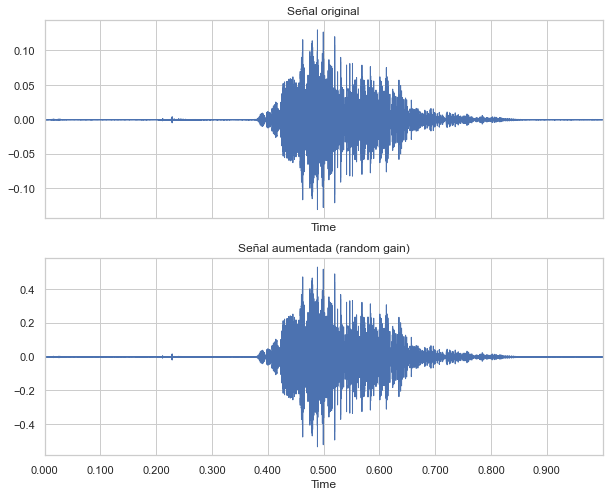

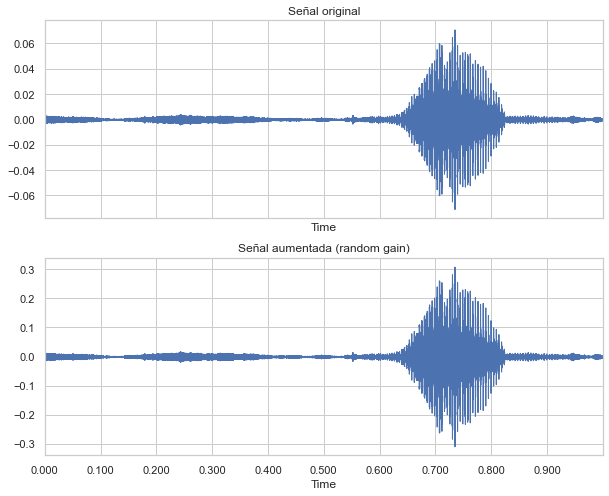

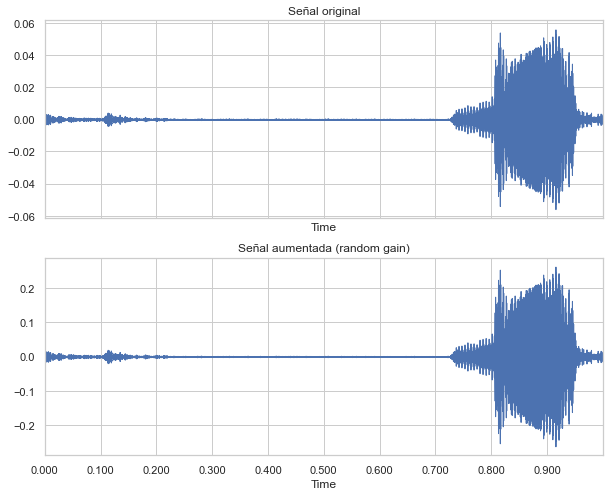

In [37]:
labels = os.listdir(MODIFIED_SPEECH_PATH)

num_plots = 3
for i in range(num_plots):
    label = random.choice(labels)
    files = os.listdir(os.path.join(MODIFIED_SPEECH_PATH, label).replace("\\", "/"))
    valid_files = [file[3:] for file in files if file.startswith(random_gain_prefix)]
    file = random.choice(valid_files)

    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/"), sr=None)
    augmented_signal, sample_rate = librosa.load(os.path.join(MODIFIED_SPEECH_PATH, label, random_gain_prefix+file).replace("\\", "/"), sr=None)

    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
    librosa.display.waveplot(signal, sr=sample_rate, ax=ax[0])
    ax[0].set(title="Señal original")
    librosa.display.waveplot(augmented_signal, sr=sample_rate, ax=ax[1])
    ax[1].set(title="Señal aumentada (random gain)")
    plt.show()

Vemos que las escalas en el eje y han cambiado y han aumentado en las señales aumentadas.

Ahora aplicamos algo de ruido blanco en muestras cuyo valor de amplitud máximo fuera elevado.

In [38]:
# White noise
wn_augmentation_per_label = 300
whitenoise_prefix = "WN_"

def add_white_noise(signal, noise_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    return signal + noise*noise_factor

for label in valid_labels:
    print(label)
    files = list(amplitudes_df_clean[amplitudes_df_clean["max_abs"] > 0.75][amplitudes_df_clean["label"] == label]["file"])
    for file in tqdm(random.sample(files, wn_augmentation_per_label)):
        file = file.split("/")[-1]
        signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/"), sr=None)
        noise_factor = random.choice([0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
        augmented_signal = add_white_noise(signal, noise_factor)
        sf.write(os.path.join(MODIFIED_SPEECH_PATH, label, whitenoise_prefix+file).replace("\\", "/"), augmented_signal, sample_rate)

<ipython-input-38-c730c4c68db7>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  files = list(amplitudes_df_clean[amplitudes_df_clean["max_abs"] > 0.75][amplitudes_df_clean["label"] == label]["file"])


00-zero


100%|██████████| 300/300 [00:02<00:00, 100.04it/s]


01-one


100%|██████████| 300/300 [00:02<00:00, 115.07it/s]


02-two


100%|██████████| 300/300 [00:01<00:00, 267.01it/s]


03-three


100%|██████████| 300/300 [00:01<00:00, 271.54it/s]


04-four


100%|██████████| 300/300 [00:01<00:00, 273.29it/s]


05-five


100%|██████████| 300/300 [00:00<00:00, 306.09it/s]


06-six


100%|██████████| 300/300 [00:00<00:00, 304.55it/s]


07-seven


100%|██████████| 300/300 [00:00<00:00, 301.88it/s]


08-eight


100%|██████████| 300/300 [00:01<00:00, 298.50it/s]


09-nine


100%|██████████| 300/300 [00:00<00:00, 312.08it/s]


10-on


100%|██████████| 300/300 [00:00<00:00, 310.25it/s]


11-off


100%|██████████| 300/300 [00:00<00:00, 307.49it/s]


12-up


100%|██████████| 300/300 [00:00<00:00, 307.55it/s]


13-down


100%|██████████| 300/300 [00:00<00:00, 306.41it/s]


14-left


100%|██████████| 300/300 [00:00<00:00, 308.01it/s]


15-right


100%|██████████| 300/300 [00:00<00:00, 307.98it/s]


16-yes


100%|██████████| 300/300 [00:00<00:00, 310.09it/s]


17-no


100%|██████████| 300/300 [00:00<00:00, 306.72it/s]


Mostramos un par de ejemplos en los que se ve qué ha hecho esta modificación de los datos.

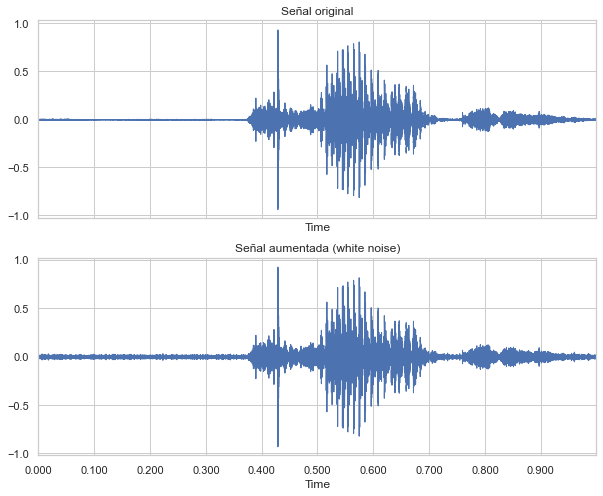

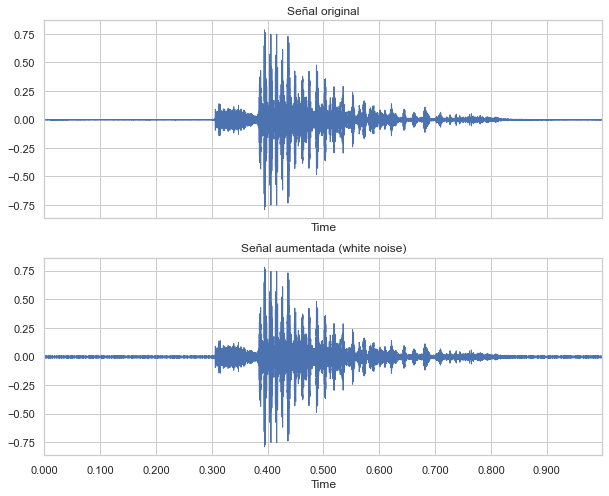

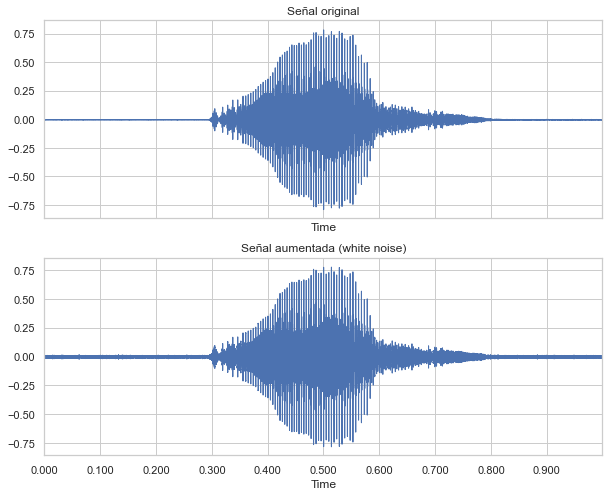

In [39]:
labels = os.listdir(MODIFIED_SPEECH_PATH)

num_plots = 3
for i in range(num_plots):
    label = random.choice(labels)
    files = os.listdir(os.path.join(MODIFIED_SPEECH_PATH, label).replace("\\", "/"))
    valid_files = [file[3:] for file in files if file.startswith(whitenoise_prefix)]
    file = random.choice(valid_files)

    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/"), sr=None)
    augmented_signal, sample_rate = librosa.load(os.path.join(MODIFIED_SPEECH_PATH, label, whitenoise_prefix+file).replace("\\", "/"), sr=None)

    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
    librosa.display.waveplot(signal, sr=sample_rate, ax=ax[0])
    ax[0].set(title="Señal original")
    librosa.display.waveplot(augmented_signal, sr=sample_rate, ax=ax[1])
    ax[1].set(title="Señal aumentada (white noise)")
    plt.show()

Vemos que se ha añadido un poco de ruido a las señales aumentadas.

Por último, aplicamos pitch scaling a algunas de las muestras.

In [40]:
# Pitch scaling
ps_augmentation_per_label = 300
pitch_scaling_prefix = "PS_"

def pitch_scaling(signal, sample_rate, num_semitones):
    return librosa.effects.pitch_shift(signal, sample_rate, num_semitones)

for label in valid_labels:
    print(label)
    files = list(amplitudes_df_clean[amplitudes_df_clean["max_abs"] > 0.4][amplitudes_df_clean["label"] == label]["file"])
    for file in tqdm(random.sample(files, ps_augmentation_per_label)):
        file = file.split("/")[-1]
        signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/"), sr=None)
        num_semitones = random.choice([-2, -1, 1, 2])
        augmented_signal = pitch_scaling(signal, sample_rate, num_semitones)
        sf.write(os.path.join(MODIFIED_SPEECH_PATH, label, pitch_scaling_prefix+file).replace("\\", "/"), augmented_signal, sample_rate)

<ipython-input-40-4b778f898d9c>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  files = list(amplitudes_df_clean[amplitudes_df_clean["max_abs"] > 0.4][amplitudes_df_clean["label"] == label]["file"])


00-zero


100%|██████████| 300/300 [00:13<00:00, 22.59it/s]


01-one


100%|██████████| 300/300 [00:12<00:00, 23.22it/s]


02-two


100%|██████████| 300/300 [00:11<00:00, 26.94it/s]


03-three


100%|██████████| 300/300 [00:11<00:00, 27.20it/s]


04-four


100%|██████████| 300/300 [00:11<00:00, 26.79it/s]


05-five


100%|██████████| 300/300 [00:11<00:00, 26.80it/s]


06-six


100%|██████████| 300/300 [00:11<00:00, 26.57it/s]


07-seven


100%|██████████| 300/300 [00:11<00:00, 26.85it/s]


08-eight


100%|██████████| 300/300 [00:11<00:00, 27.26it/s]


09-nine


100%|██████████| 300/300 [00:11<00:00, 27.07it/s]


10-on


100%|██████████| 300/300 [00:11<00:00, 26.44it/s]


11-off


100%|██████████| 300/300 [00:11<00:00, 26.83it/s]


12-up


100%|██████████| 300/300 [00:11<00:00, 26.59it/s]


13-down


100%|██████████| 300/300 [00:11<00:00, 26.78it/s]


14-left


100%|██████████| 300/300 [00:11<00:00, 26.27it/s]


15-right


100%|██████████| 300/300 [00:11<00:00, 26.63it/s]


16-yes


100%|██████████| 300/300 [00:11<00:00, 26.20it/s]


17-no


100%|██████████| 300/300 [00:11<00:00, 26.93it/s]


En este caso mostramos los espectrogramas de un par de ejemplos para ver cómo ha modificado las frecuencias esta técnica de aumento.

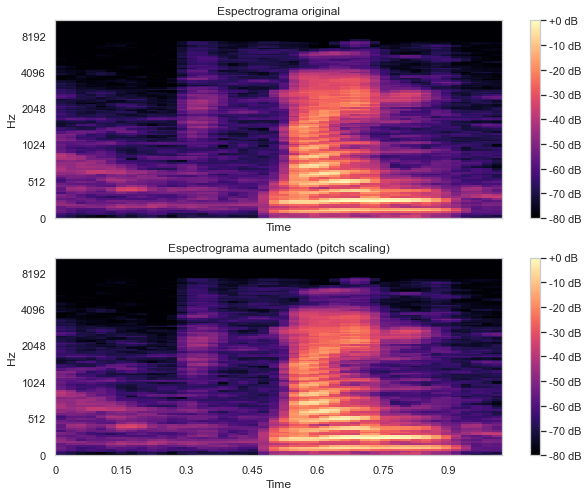

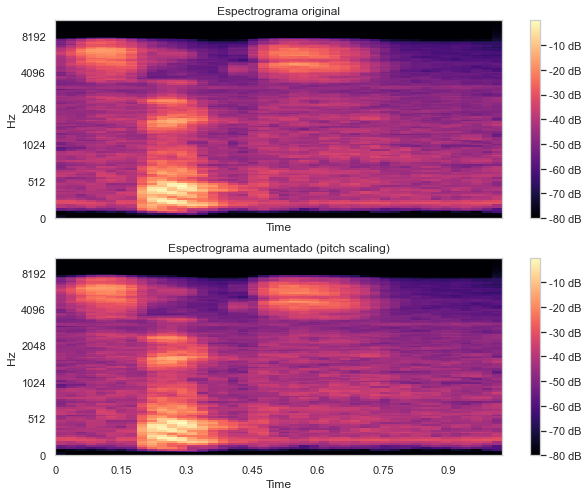

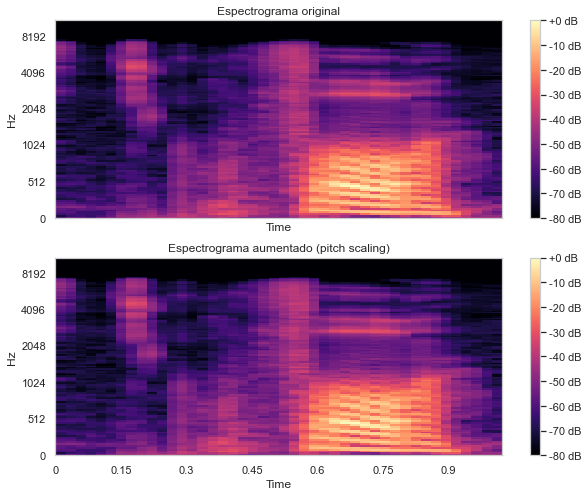

In [41]:
labels = os.listdir(MODIFIED_SPEECH_PATH)

num_plots = 3
for i in range(num_plots):
    label = random.choice(labels)
    files = os.listdir(os.path.join(MODIFIED_SPEECH_PATH, label).replace("\\", "/"))
    valid_files = [file[3:] for file in files if file.startswith(pitch_scaling_prefix)]
    file = random.choice(valid_files)

    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)
    #spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max) # typical spectrogram in dB
    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate)
    log_melspec = librosa.power_to_db(melspec, ref=np.max)
    augmented_signal, sample_rate = librosa.load(os.path.join(MODIFIED_SPEECH_PATH, label, pitch_scaling_prefix+file).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)
    #augmented_spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(augmented_signal)), ref=np.max) # typical spectrogram in dB
    augmented_melspec = librosa.feature.melspectrogram(signal, sr=sample_rate)
    augmented_log_melspec = librosa.power_to_db(melspec, ref=np.max)

    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))

    img = librosa.display.specshow(log_melspec, x_axis="time", y_axis="mel", sr=sample_rate, ax=ax[0])
    ax[0].set(title="Espectrograma original")
    fig.colorbar(img, ax=ax[0], format="%+2.f dB")

    img = librosa.display.specshow(augmented_log_melspec, x_axis="time", y_axis="mel", sr=sample_rate, ax=ax[1])
    ax[1].set(title="Espectrograma aumentado (pitch scaling)")
    fig.colorbar(img, ax=ax[1], format="%+2.f dB")

    plt.show()

Con esto damos por concluida la correción inicial de los datos y el data augmentation, de modo que tenemos el dataset listo para ser transformado en información útil y entrenar con ella los modelos planteados.

### Exploración final de los datos tratados

Una vez ya hemos tratado de manera general todos los datos, mostramos unas últimas anotaciones relacionadas con la distribución de los datos y su balanceo. En primer lugar vemos cuántas etiquetas hemos escogido finalmente.

In [42]:
print(valid_labels)
print("Numero de etiquetas:", len(valid_labels))

['00-zero', '01-one', '02-two', '03-three', '04-four', '05-five', '06-six', '07-seven', '08-eight', '09-nine', '10-on', '11-off', '12-up', '13-down', '14-left', '15-right', '16-yes', '17-no']
Numero de etiquetas: 18


Y por último mostramos cómo se distribuyen los datos para cada una de las etiquetas.

In [43]:
data_df = pd.DataFrame(columns=["num_samples", "type", "label"])
for label in valid_labels:
    waves = [i for i in os.listdir(os.path.join(RAW_SPEECH_PATH, label)) if i.endswith(".wav")]
    data_df = data_df.append({"num_samples": len(waves), "type": "real", "label": label}, ignore_index = True)

    aug_waves = [i for i in os.listdir(os.path.join(MODIFIED_SPEECH_PATH, label)) if i.endswith(".wav")]
    data_df = data_df.append({"num_samples": len(aug_waves), "type": "augmented", "label": label}, ignore_index = True)

# Plot
fig = px.bar(data_df, x="label", y="num_samples", color="type", labels={"label": "Etiqueta", "num_samples": "# muestras", "type": "Tipo de dato"}, title="Número de muestras por etiqueta")
fig.show()

Vemos que tenemos un conjunto de datos altamente balanceado y con un gran número de muestras por etiqueta, así que teóricamente podemos esperar unos resultados decentes si los modelos son adecuados.

## Transformación en información útil

Planteamos 3 formas de convertir los datos en información, cada una de ellas centrándose en una característica diferente, de modo que las redes neuronales aprendan de diferentes fuentes y podamos comprobar cuál se comporta mejor. Diferenciamos:

* espectrograma de Mel: es una representación del espectrograma clásico (gráfico que muestra el comportamiento de las diferentes frecuencias a lo largo del tiempo) en la escala de Mel, una escala linealizada para el espectro auditivo humano. Se ha demostrado que los espectrogramas de Mel son el mejor tipo de información que proporcionar a una arquitectura de deep learning para el reconocimiento de lenguaje
* coeficientes MFC (Mel frequency cepstral): agrupando cada señal de audio en diferentes fragmentos, extraemos de cada uno de ellos una serie de coeficientes que codifican muy bien la información para el reconocimiento de audio. Los MFCCs han sido muy utilizados en reconocimiento del lenguaje porque mapean directamente con información del timbre de la voz que, muy simplificademente, se puede entender como la característica diferenciadora de los diferentes fonemas del lenguaje
* información cruda del audio: extraemos la propia señal (con un menor número de frames para que la carga de trabajo y entrenamiento sea menos costosa) sin centrarnos en ninguna característica en concreto. El estado del arte del deep learning con estructuras altamente complejas utiliza esta información directamente para que la red aprenda de la manera óptima

En cada caso, guardamos la información extraída en archivos JSON individuales (por tipo de información y según si son datos aumentados o no) para que no tengamos que repetir el procesamiento de los datos de manera repetida. Una vez tengamos los archivos JSON podemos releer la información sin ningún tipo de procesado.

*Hasta ahora se ha decido procesar los datos manteniendo las características originales del dataset, con el objetivo de estandarizar y verificar que todos los audios son correctos y válidos. Pero ahora para la extracción de la información vamos a forzar la frecuencia de muestreo a 22050 Hz, que es la frecuencia de muestreo con la que trabaja por defecto la librería librosa. De este modo, obtendremos la información de una manera totalmente adecuada y homogénea, ya que los parámetros para llevar a cabo los cálculos están optimizados para esta frecuencia de muestreo, sin aumentar en exceso el tamaño de las muestras o los resultados (https://librosa.org/blog/2019/07/17/resample-on-load/).

### Mel spectrogram

En primer lugar, transformamos los audios en sus correspondientes espectrogramas de Mel y guardamos la información asociada a cada franja de Mel en el tiempo. La amplitud de las frecuencias las convertimos en decibelios para que tenga un mayor sentido en el espectro humano, y en cierto modo para discretizar los valores en una escala logarítmica.

Con este planteamiento se buscan probar redes convolucionales (2D porque son las que permite la placa coral de google) para intentar encontrar patrones en las imágenes que codifican los espectrogramas.

In [47]:
n_mels=80
hop_length=512 # good value for audios with 22050 number of frames
n_fft=2048 # good value for audios with 22050 number of frames

data_melspecs = {
    "mappings": [],
    "labels": [], 
    "melspecs": [],
    "files": []
}
data_melspecs_augmented = {
    "mappings": [],
    "labels": [], 
    "melspecs": [],
    "files": []
}

for i, label in enumerate(valid_labels):
    data_melspecs["mappings"].append([label, i])
    data_melspecs_augmented["mappings"].append([label, i])

    print(label)
    for file in tqdm(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/"))):
        if file.endswith(".wav"):
            filename = os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/")
            signal, sample_rate = librosa.load(filename, sr=COMMON_NFRAMES_LIBROSA)

            # extract Mel spectrogram (in dB)
            melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
            melspec_dB = librosa.power_to_db(melspec, ref=np.max)

            # store data
            data_melspecs["labels"].append(i)
            data_melspecs["melspecs"].append(melspec_dB.T.tolist())
            data_melspecs["files"].append(filename)

    for file in tqdm(os.listdir(os.path.join(MODIFIED_SPEECH_PATH, label).replace("\\", "/"))):
        if file.endswith(".wav"):
            filename = os.path.join(MODIFIED_SPEECH_PATH, label, file).replace("\\", "/")
            signal, sample_rate = librosa.load(filename, sr=COMMON_NFRAMES_LIBROSA)
            
            # extract Mel spectrogram (in dB)
            melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
            melspec_dB = librosa.power_to_db(melspec, ref=np.max)
            
            # store data
            data_melspecs_augmented["labels"].append(i)
            data_melspecs_augmented["melspecs"].append(melspec_dB.T.tolist())
            data_melspecs_augmented["files"].append(filename)

00-zero


100%|██████████| 965/965 [00:44<00:00, 21.64it/s]


01-one


100%|██████████| 952/952 [00:44<00:00, 21.59it/s]


02-two


100%|██████████| 997/997 [00:46<00:00, 21.55it/s]


03-three


100%|██████████| 1003/1003 [00:46<00:00, 21.53it/s]


04-four


100%|██████████| 937/937 [00:43<00:00, 21.78it/s]


05-five


100%|██████████| 825/825 [00:37<00:00, 21.87it/s]


06-six


100%|██████████| 952/952 [00:45<00:00, 20.90it/s]


07-seven


100%|██████████| 881/881 [00:41<00:00, 21.19it/s]


08-eight


100%|██████████| 932/932 [00:44<00:00, 21.03it/s]


09-nine


100%|██████████| 920/920 [00:43<00:00, 21.17it/s]


10-on


100%|██████████| 917/917 [00:43<00:00, 21.11it/s]


11-off


100%|██████████| 832/832 [01:21<00:00, 10.18it/s]


12-up


100%|██████████| 864/864 [00:41<00:00, 20.72it/s]


13-down


100%|██████████| 893/893 [00:41<00:00, 21.26it/s]


14-left


100%|██████████| 887/887 [00:42<00:00, 20.90it/s]


15-right


100%|██████████| 898/898 [00:44<00:00, 20.34it/s]


16-yes


100%|██████████| 940/940 [00:45<00:00, 20.46it/s]


17-no


100%|██████████| 967/967 [00:47<00:00, 20.50it/s]


In [48]:
# Export JSON files
with open(os.path.join(JSON_PATH, "data_melspecs.json").replace("\\", "/"), "w") as jfile:
    json.dump(data_melspecs, jfile, indent=4)

with open(os.path.join(JSON_PATH, "data_melspecs_augmented.json").replace("\\", "/"), "w") as json_file:
    json.dump(data_melspecs_augmented, json_file, indent=4)

Mostramos algunos ejemplos de espectrogramas guardados.

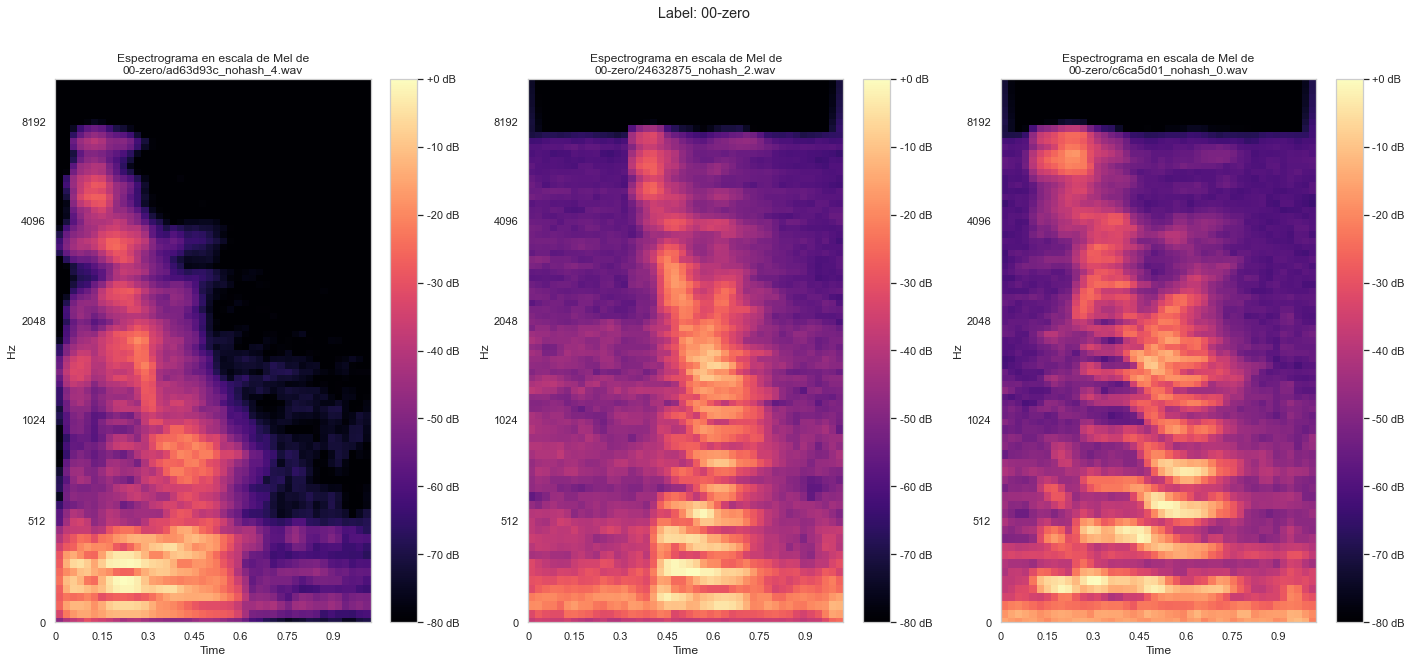

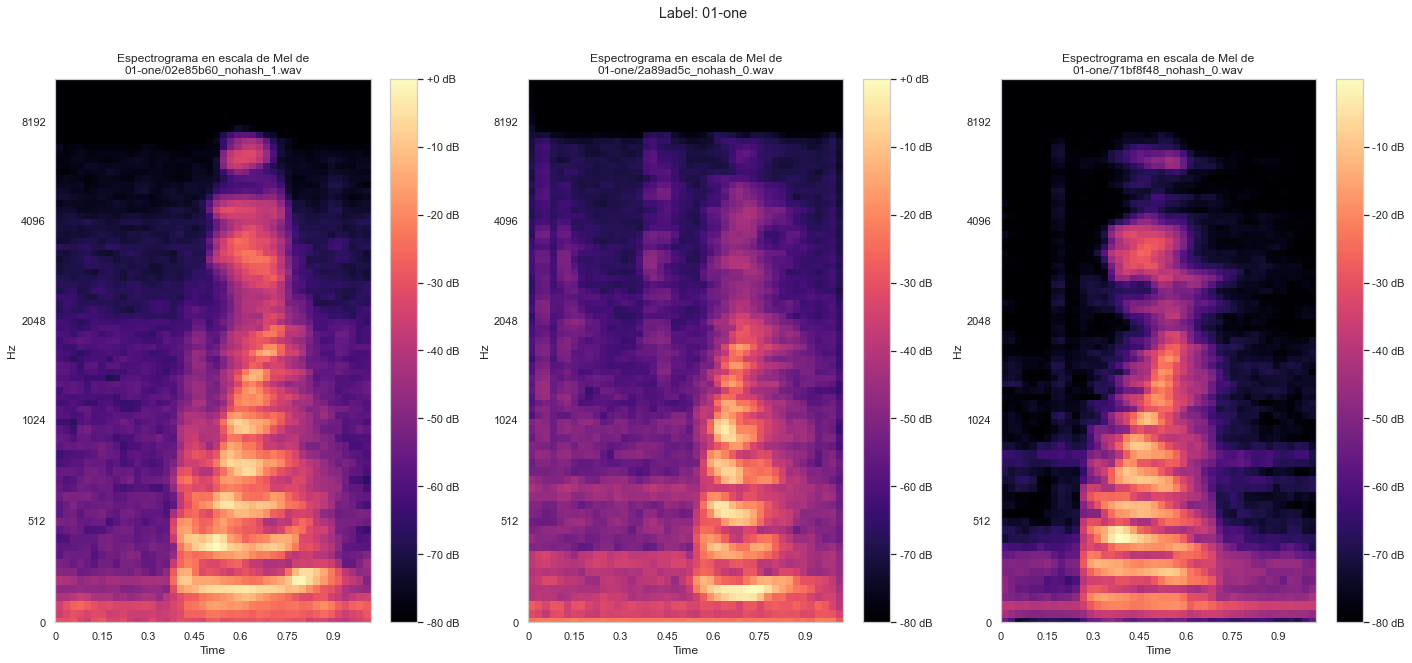

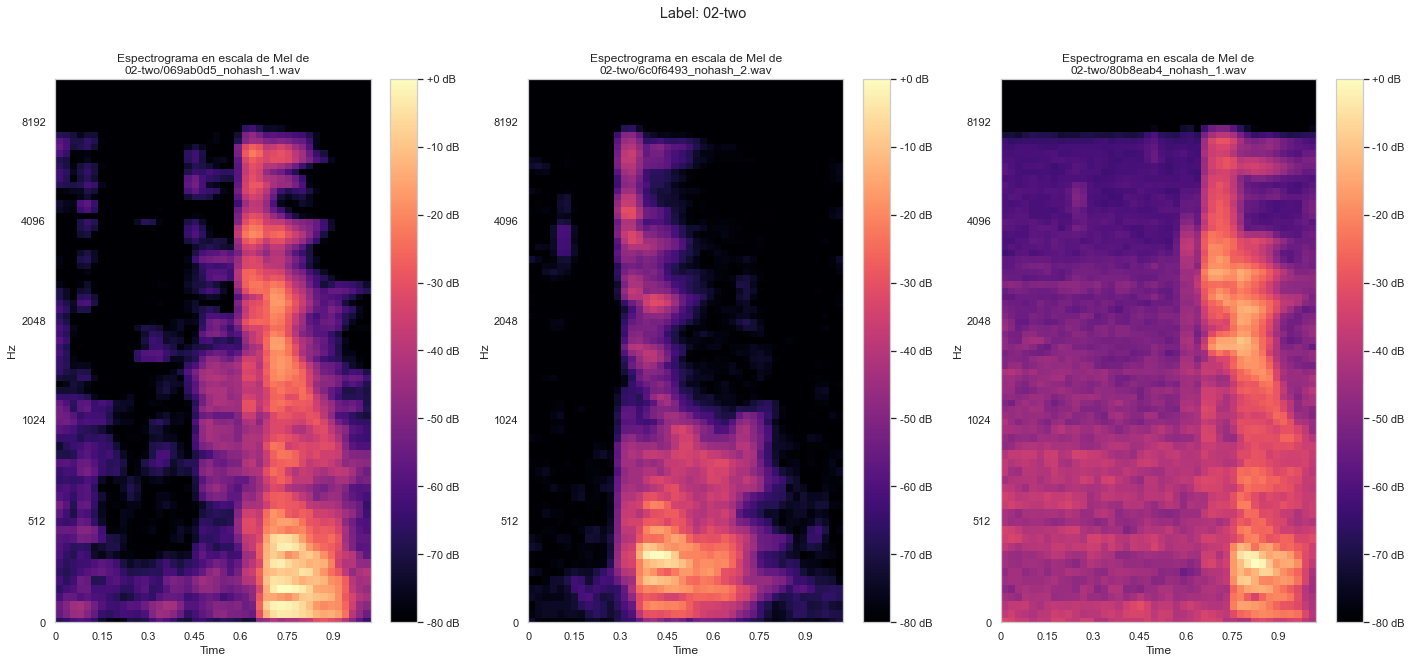

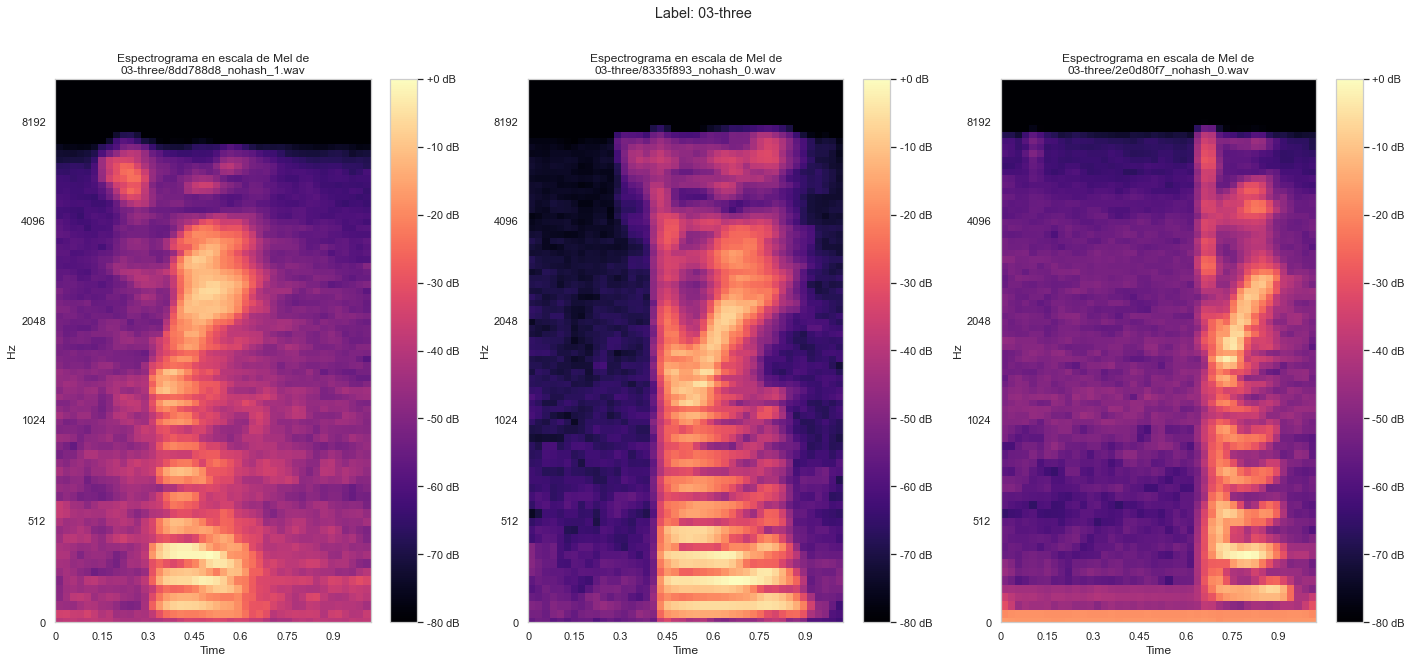

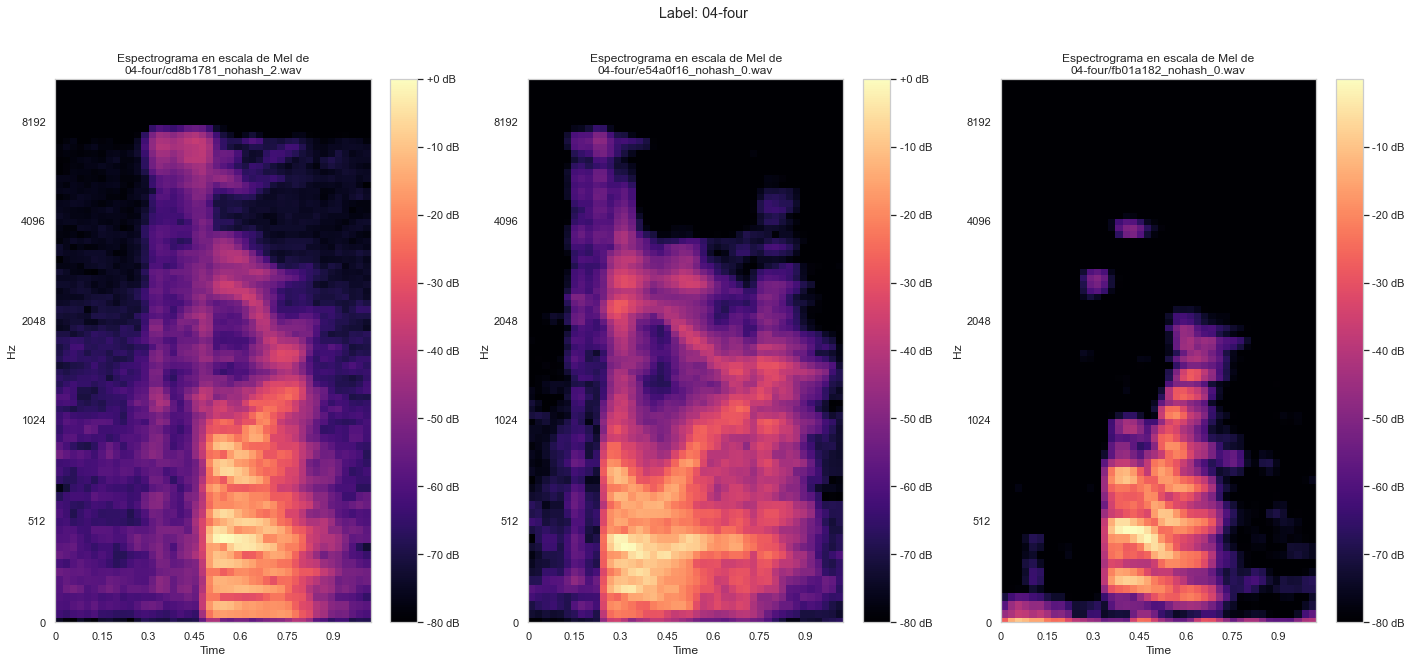

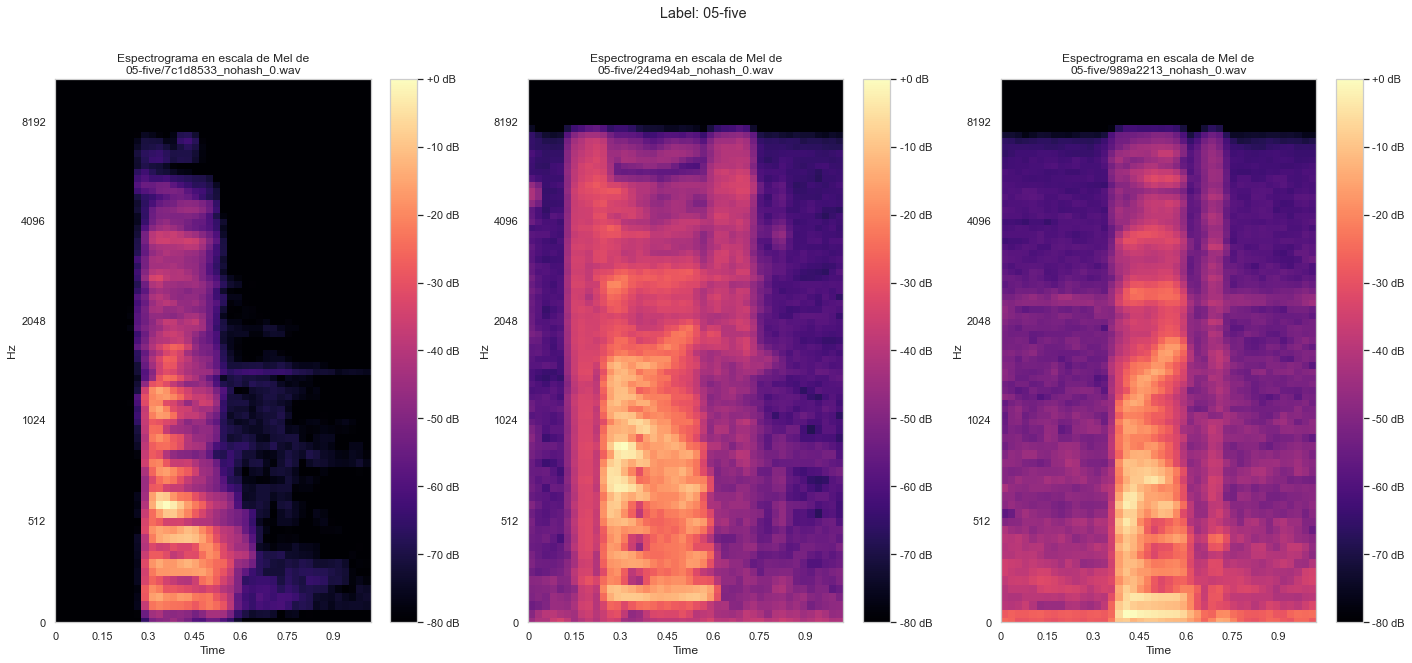

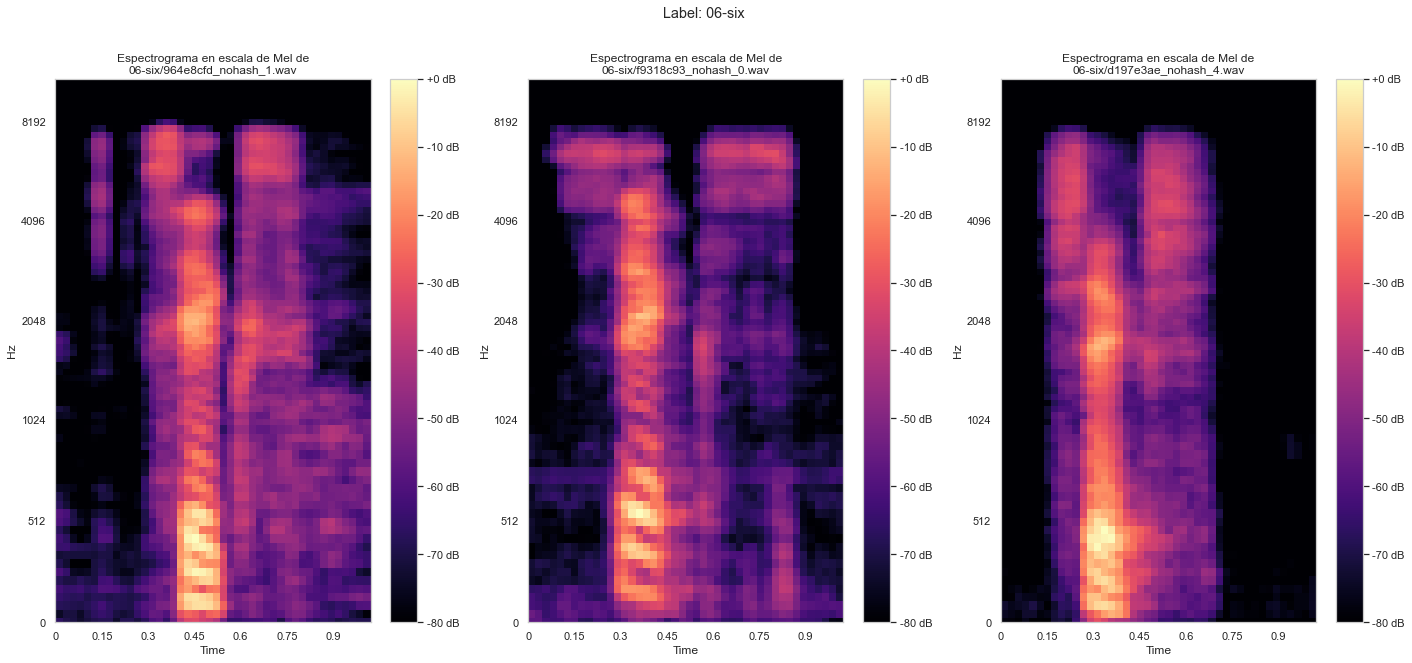

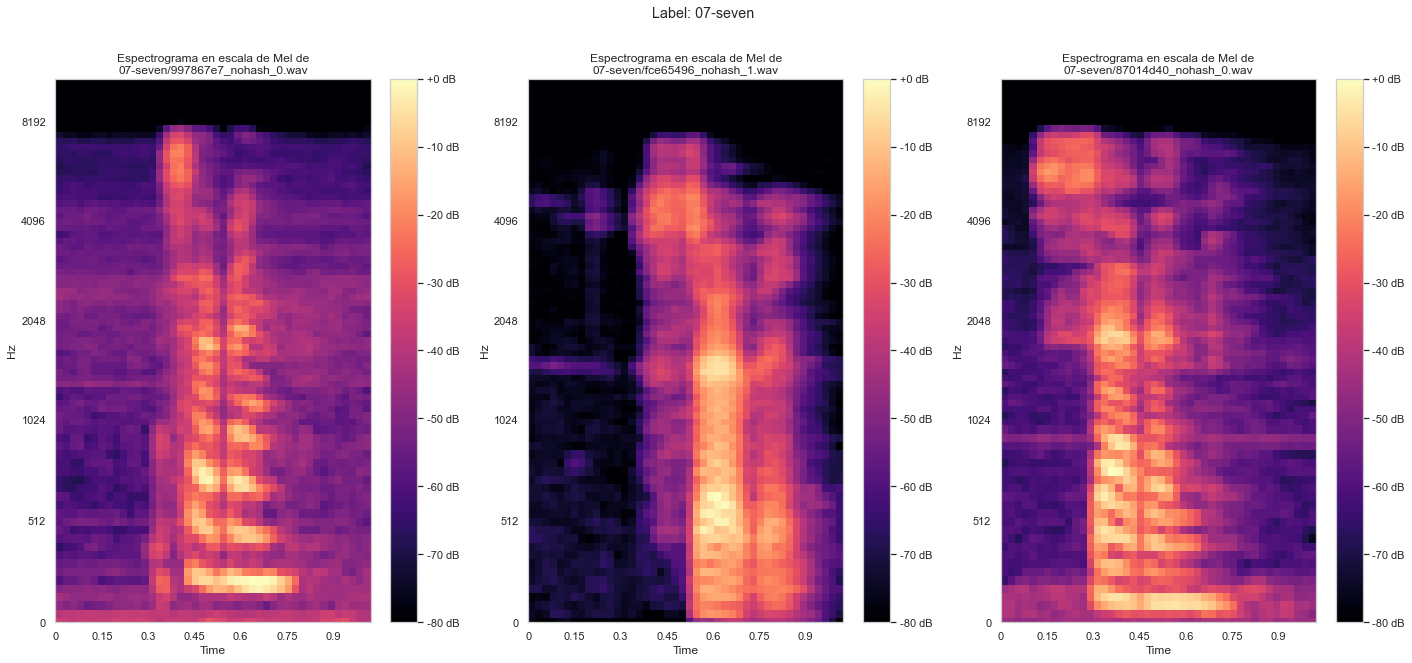

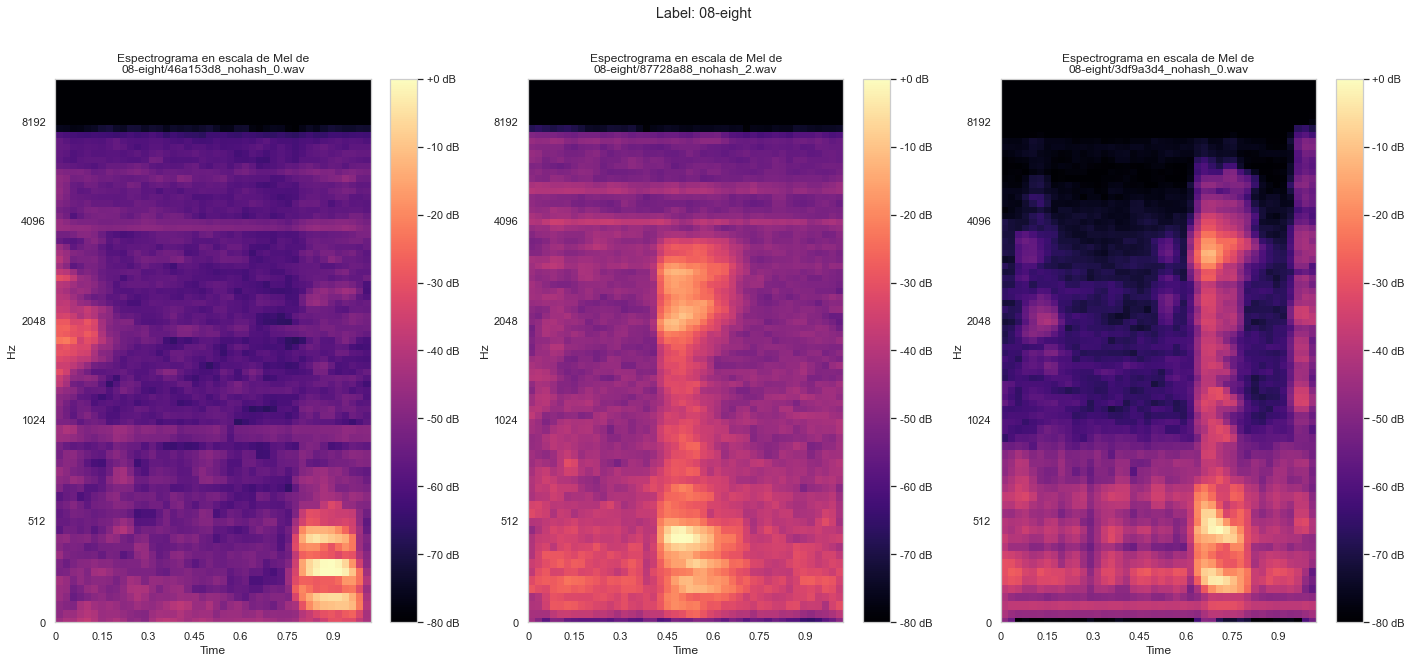

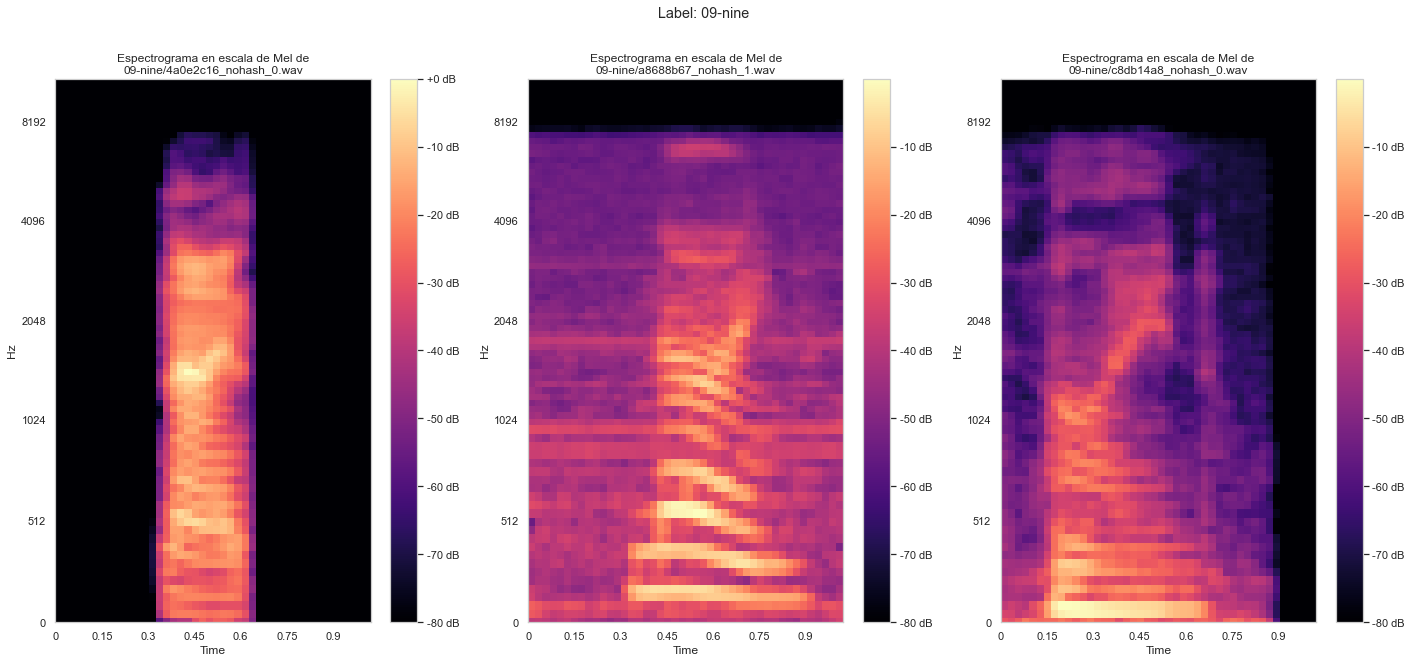

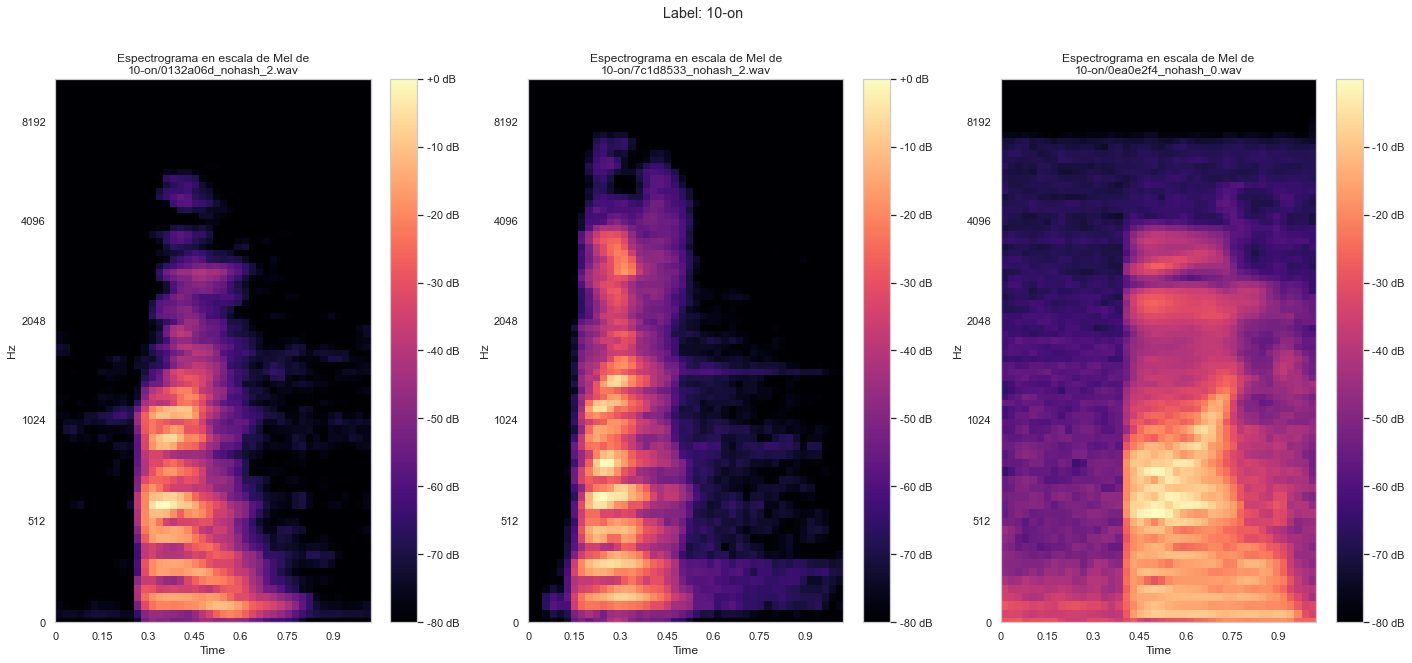

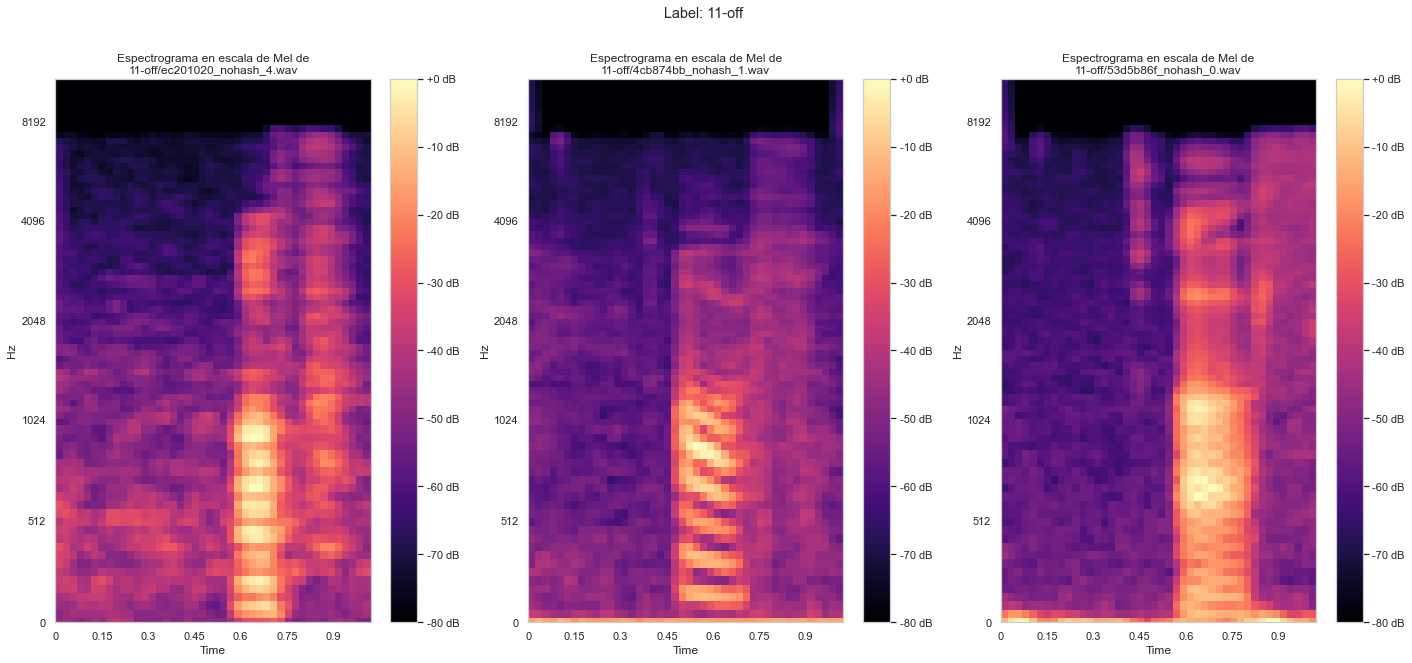

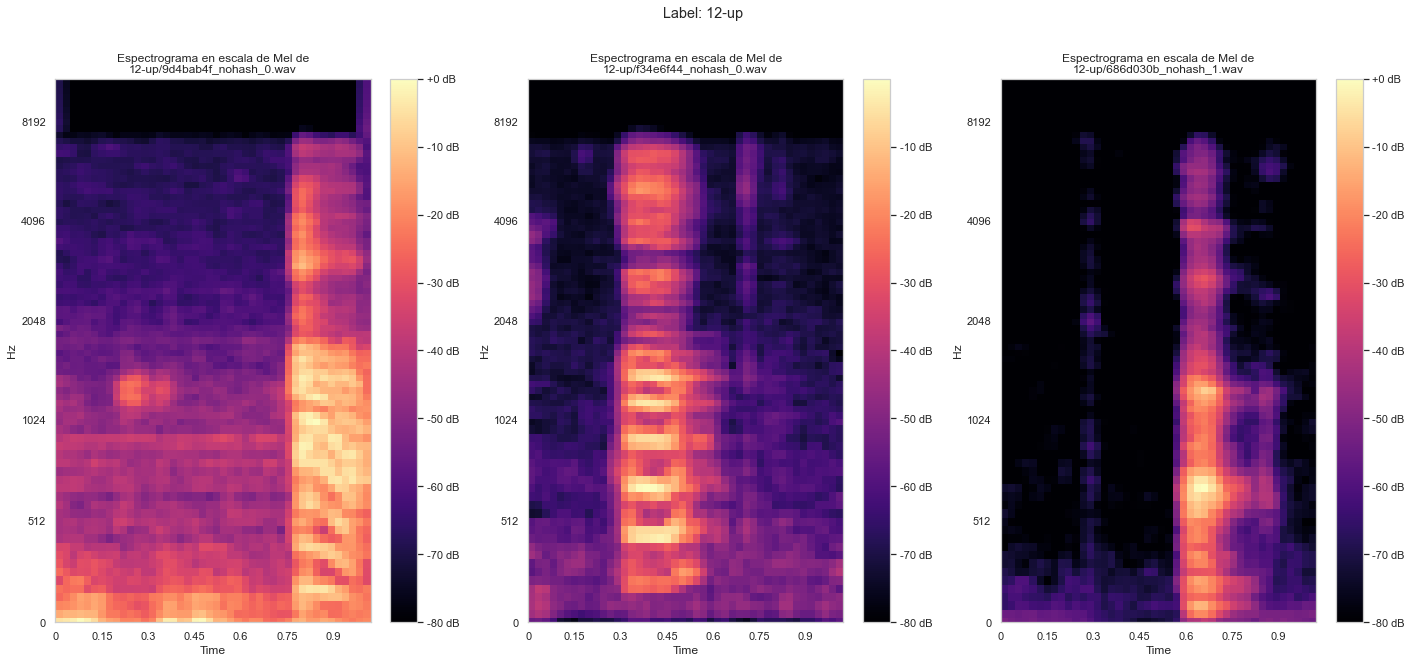

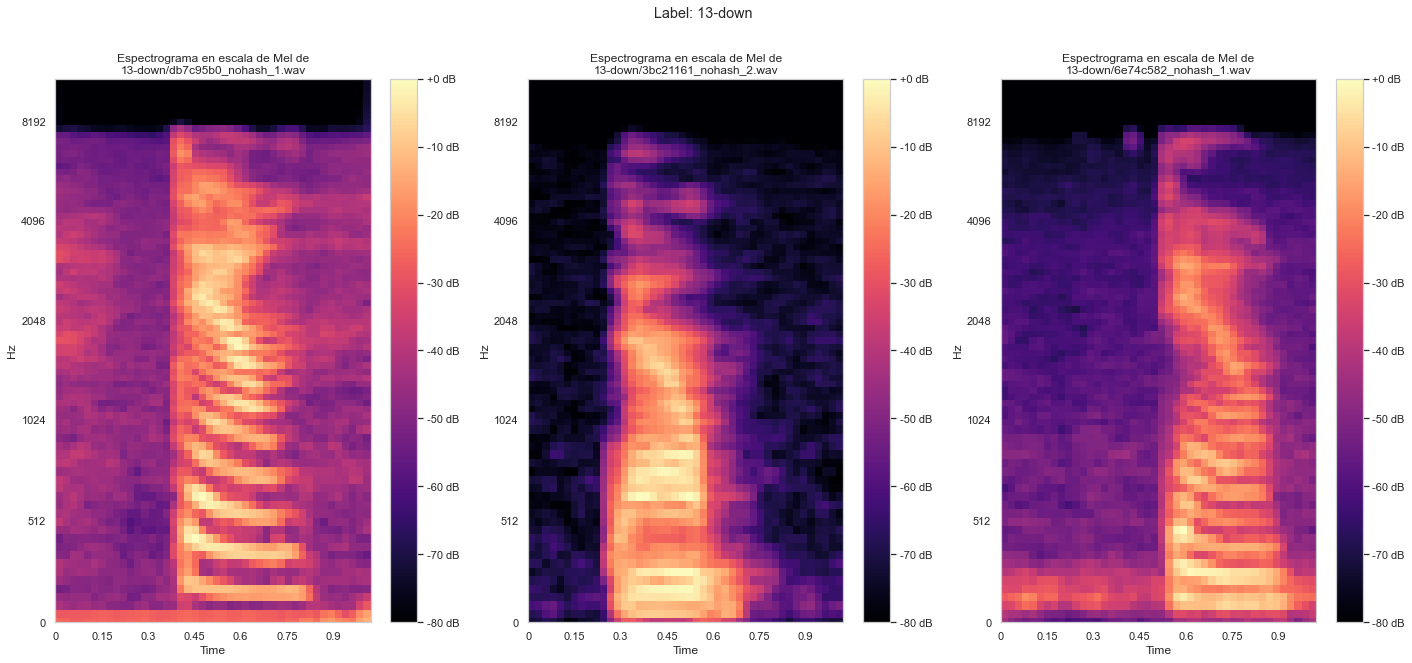

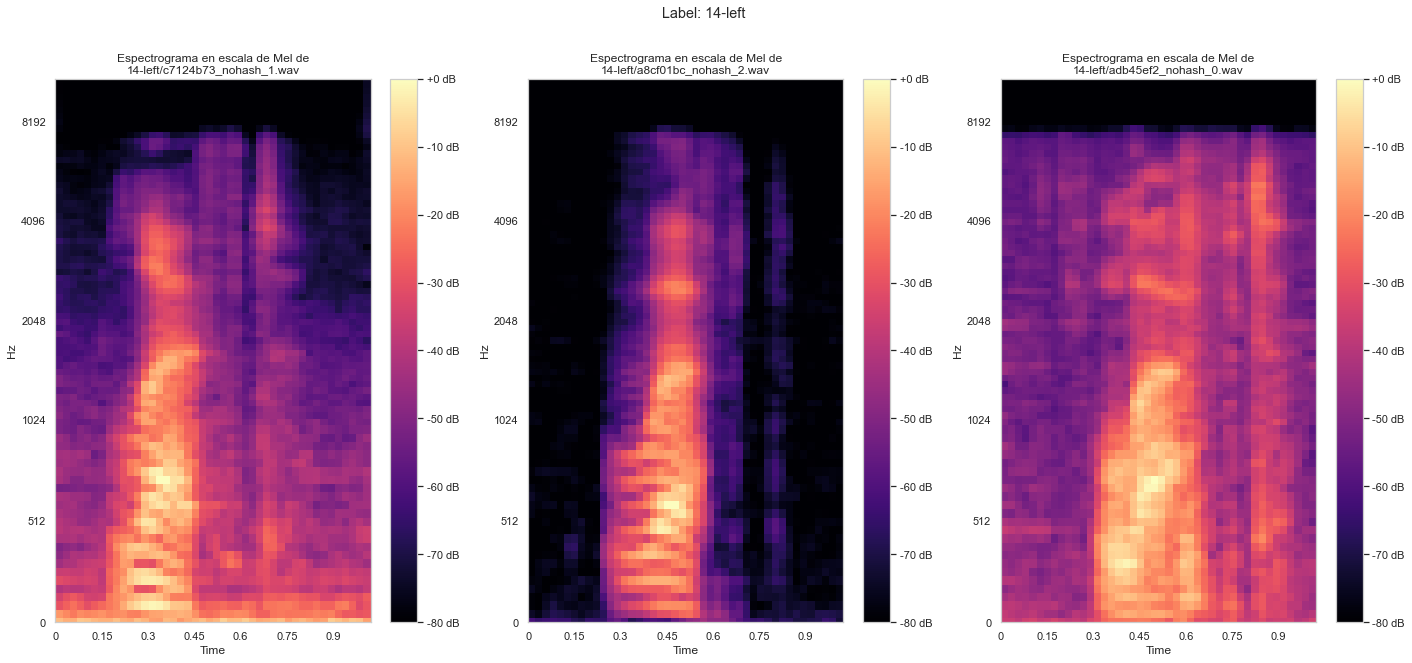

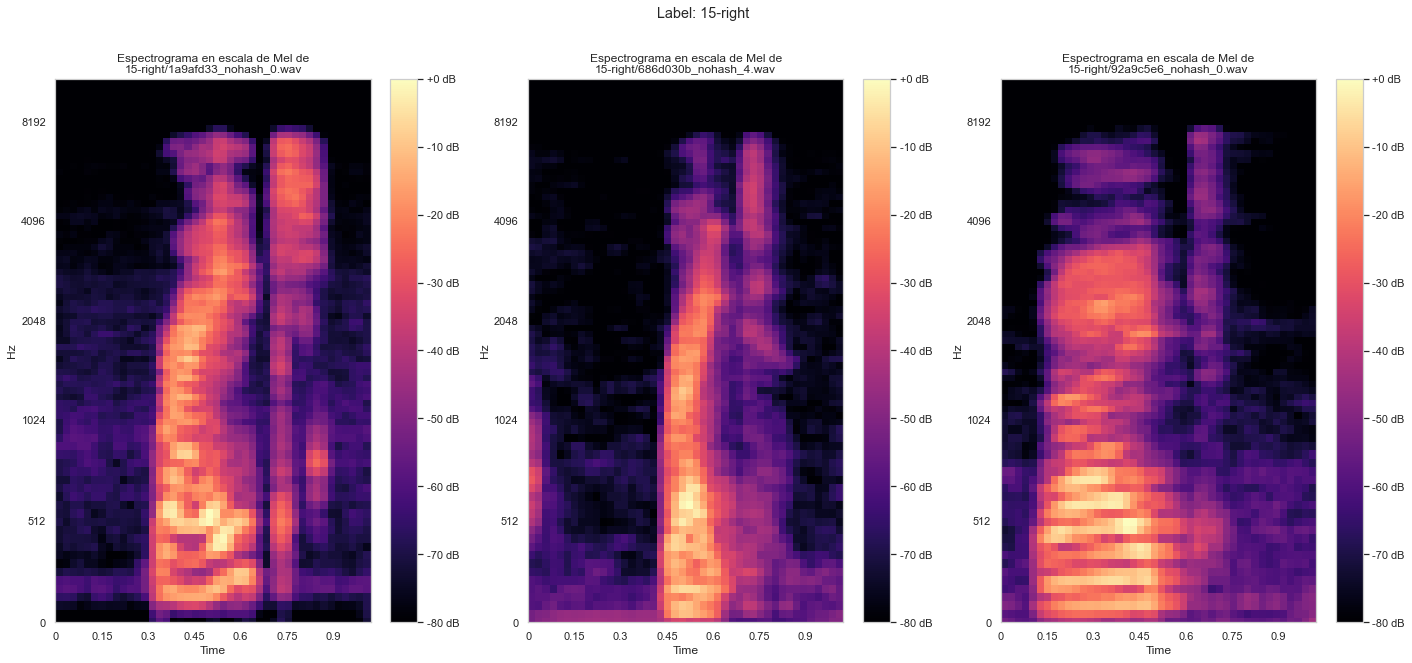

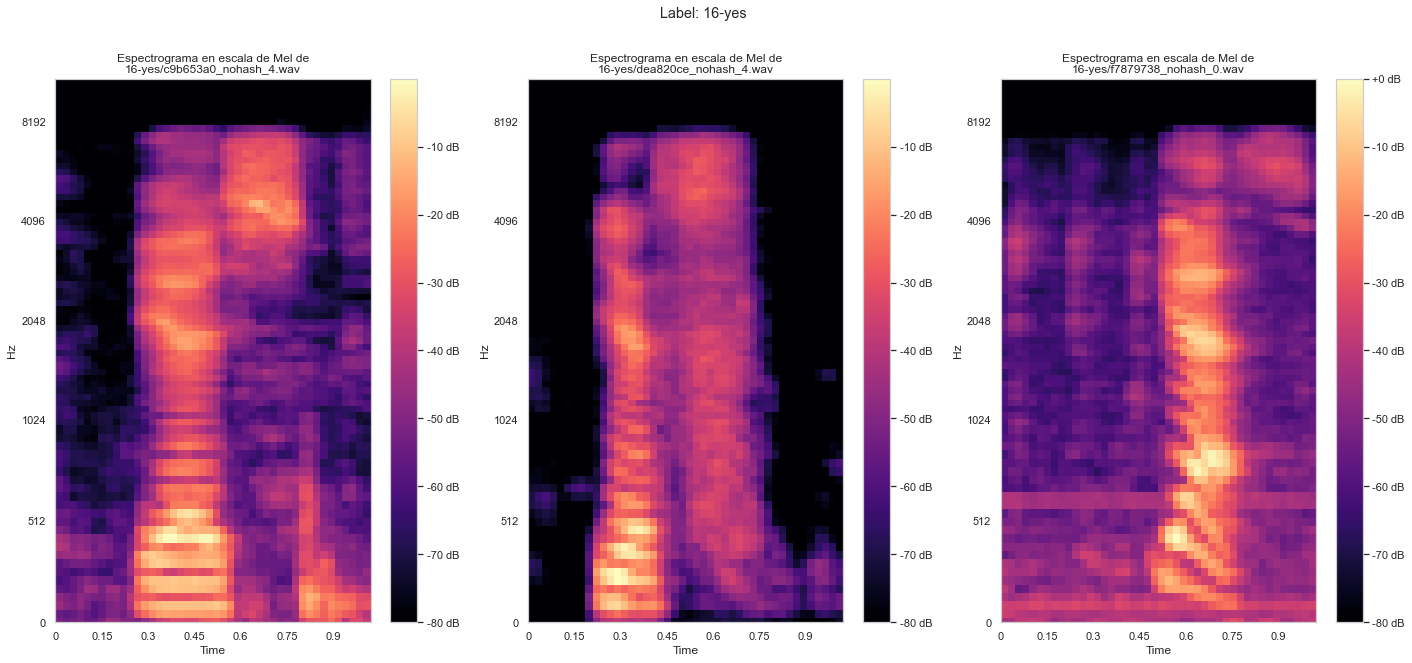

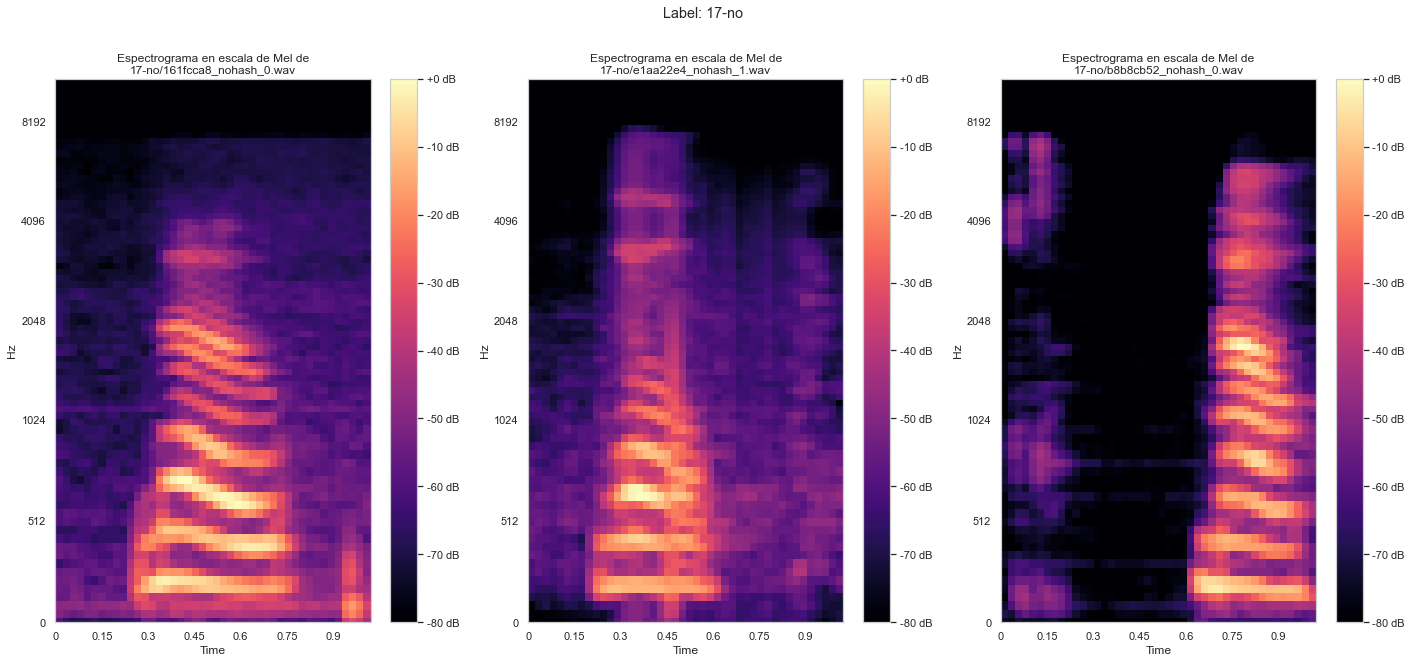

In [49]:
for label in valid_labels:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 10))

    # FIRST AUDIO PER LABEL
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)
    
    # Log mel spectrogram
    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
    log_melspec = librosa.power_to_db(melspec, ref=np.max)
    img = librosa.display.specshow(log_melspec, x_axis="time", y_axis="mel", sr=sample_rate, ax=ax[0])
    ax[0].set(title="Espectrograma en escala de Mel de\n" + filename)
    #ax[0].label_outer()
    fig.colorbar(img, ax=ax[0], format="%+2.f dB")
    
    
    # SECOND AUDIO PER LABEL
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)
    
    # Log mel spectrogram
    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
    log_melspec = librosa.power_to_db(melspec, ref=np.max)
    img = librosa.display.specshow(log_melspec, x_axis="time", y_axis="mel", sr=sample_rate, ax=ax[1])
    ax[1].set(title="Espectrograma en escala de Mel de\n" + filename)
    #ax[1].label_outer()
    fig.colorbar(img, ax=ax[1], format="%+2.f dB")


    # THIRD AUDIO PER LABEL
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)
    
    # Log mel spectrogram
    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
    log_melspec = librosa.power_to_db(melspec, ref=np.max)
    img = librosa.display.specshow(log_melspec, x_axis="time", y_axis="mel", sr=sample_rate, ax=ax[2])
    ax[2].set(title="Espectrograma en escala de Mel de\n" + filename)
    #ax[2].label_outer()
    fig.colorbar(img, ax=ax[2], format="%+2.f dB")
    

    plt.suptitle("Label: " + str(label))

In [50]:
del data_melspecs, data_melspecs_augmented

### MFCCs

A continuación, transformamos la información del audio en los coeficientes MFC. Para esta síntesis, dividimos el audio en segmentos y de cada segmento los coeficientes, de modo que al final tendremos un conjunto bidimensional de datos (segmento, coeficientes) que podremos introducir en la red neuronal.

An intuition about the cepstral features can help to figure out what we should look for when we use them in a speech-based system.
- As cepstral features are computed by taking the Fourier transform of the warped logarithmic spectrum, they contain information about the rate changes in the different spectrum bands. Cepstral features are favorable due to their ability to separate the impact of source and filter in a speech signal. In other words, in the cepstral domain, the influence of the vocal cords (source) and the vocal tract (filter) in a signal can be separated since the low-frequency excitation and the formant filtering of the vocal tract are located in different regions in the cepstral domain.
- If a cepstral coefficient has a positive value, it represents a sonorant sound since the majority of the spectral energy in sonorant sounds are concentrated in the low-frequency regions.
- On the other hand, if a cepstral coefficient has a negative value, it represents a fricative sound since most of the spectral energies in fricative sounds are concentrated at high frequencies.
- The lower order coefficients contain most of the information about the overall spectral shape of the source-filter transfer function.
- The zero-order coefficient indicates the average power of the input signal.
- The first-order coefficient represents the distribution spectral energy between low and high frequencies.
- Even though higher order coefficients represent increasing levels of spectral details, depending on the sampling rate and estimation method, 12 to 20 cepstral coefficients are typically optimal for speech analysis. Selecting a large number of cepstral coefficients results in more complexity in the models. For example, if we intend to model a speech signal by a Gaussian mixture model (GMM), if a large number of cepstral coefficients is used, we typically need more data in order to accurately estimate the parameters of the GMM.

In [51]:
n_mfcc=12 # usually we take between 12-20 coefficients for speech recognition -> leave it on 12 to keep low the complexity and dimensions
hop_length=512 # good value for audios with 22050 number of frames
n_fft=2048 # good value for audios with 22050 number of frames

data_MFCCs = {
    "mappings": [],
    "labels": [], 
    "MFCCs": [],
    "files": []
}
data_MFCCs_augmented = {
    "mappings": [],
    "labels": [], 
    "MFCCs": [],
    "files": []
}

for i, label in enumerate(valid_labels):
    data_MFCCs["mappings"].append([label, i])
    data_MFCCs_augmented["mappings"].append([label, i])

    print(label)
    for file in tqdm(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/"))):
        if file.endswith(".wav"):
            filename = os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/")
            signal, sample_rate = librosa.load(filename, sr=COMMON_NFRAMES_LIBROSA)

            # extract MFCCs
            MFCCs = librosa.feature.mfcc(signal, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

            # store data
            data_MFCCs["labels"].append(i)
            data_MFCCs["MFCCs"].append(MFCCs.T.tolist())
            data_MFCCs["files"].append(filename)

    for file in tqdm(os.listdir(os.path.join(MODIFIED_SPEECH_PATH, label).replace("\\", "/"))):
        if file.endswith(".wav"):
            filename = os.path.join(MODIFIED_SPEECH_PATH, label, file).replace("\\", "/")
            signal, sample_rate = librosa.load(filename, sr=COMMON_NFRAMES_LIBROSA)

            # extract MFCCs
            MFCCs = librosa.feature.mfcc(signal, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

            # store data
            data_MFCCs_augmented["labels"].append(i)
            data_MFCCs_augmented["MFCCs"].append(MFCCs.T.tolist())
            data_MFCCs_augmented["files"].append(filename)

00-zero


100%|██████████| 965/965 [00:41<00:00, 23.09it/s]


01-one


100%|██████████| 952/952 [00:41<00:00, 22.71it/s]


02-two


100%|██████████| 997/997 [00:44<00:00, 22.59it/s]


03-three


100%|██████████| 1003/1003 [00:44<00:00, 22.63it/s]


04-four


100%|██████████| 937/937 [00:44<00:00, 20.98it/s]


05-five


100%|██████████| 825/825 [00:40<00:00, 20.47it/s]


06-six


100%|██████████| 952/952 [00:45<00:00, 20.96it/s]


07-seven


100%|██████████| 881/881 [00:42<00:00, 20.81it/s]


08-eight


100%|██████████| 932/932 [00:45<00:00, 20.57it/s]


09-nine


100%|██████████| 920/920 [00:42<00:00, 21.56it/s]


10-on


100%|██████████| 917/917 [00:43<00:00, 20.97it/s]


11-off


100%|██████████| 832/832 [00:40<00:00, 20.47it/s]


12-up


100%|██████████| 864/864 [00:42<00:00, 20.47it/s]


13-down


100%|██████████| 893/893 [00:43<00:00, 20.56it/s]


14-left


100%|██████████| 887/887 [00:42<00:00, 20.87it/s]


15-right


100%|██████████| 898/898 [00:44<00:00, 20.00it/s]


16-yes


100%|██████████| 940/940 [00:45<00:00, 20.68it/s]


17-no


100%|██████████| 967/967 [00:47<00:00, 20.38it/s]


In [52]:
# Export JSON files
with open(os.path.join(JSON_PATH, "data_mfccs.json").replace("\\", "/"), "w") as json_file:
    json.dump(data_MFCCs, json_file, indent=4)

with open(os.path.join(JSON_PATH, "data_mfccs_augmented.json").replace("\\", "/"), "w") as json_file:
    json.dump(data_MFCCs_augmented, json_file, indent=4)

Mostramos gráficamente cómo son los MFCCs generados de algunas muestras.

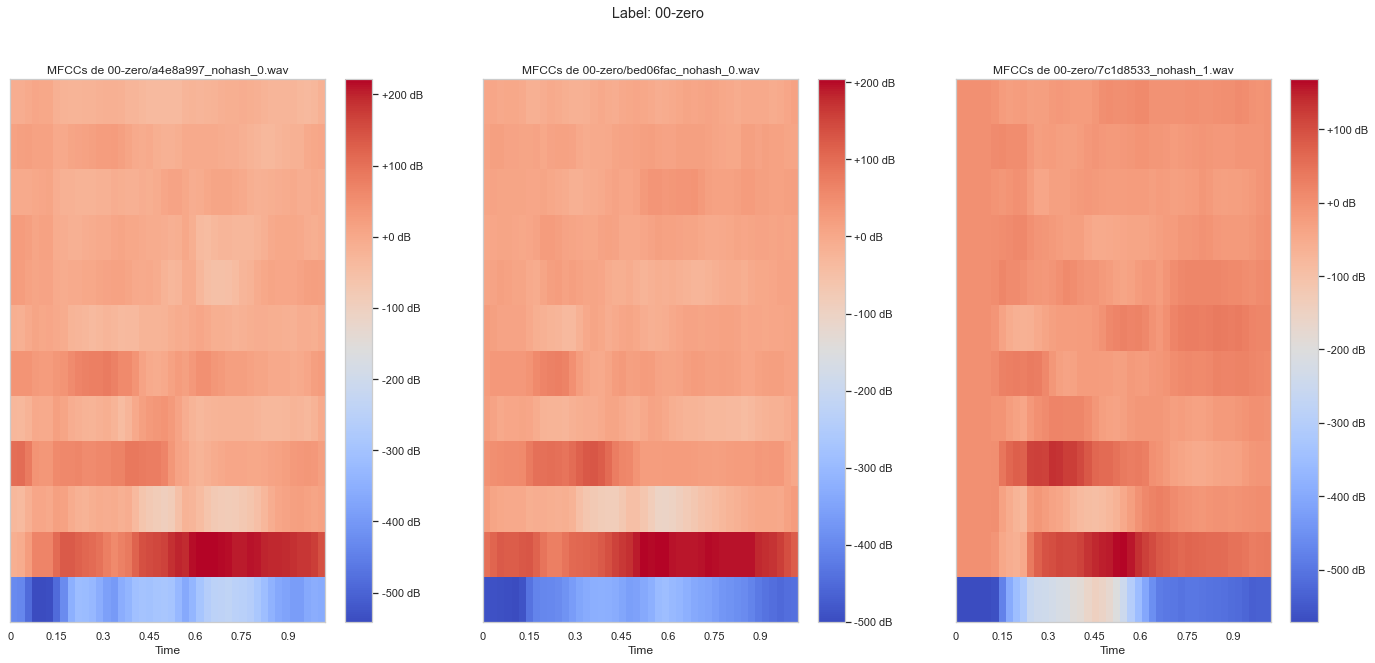

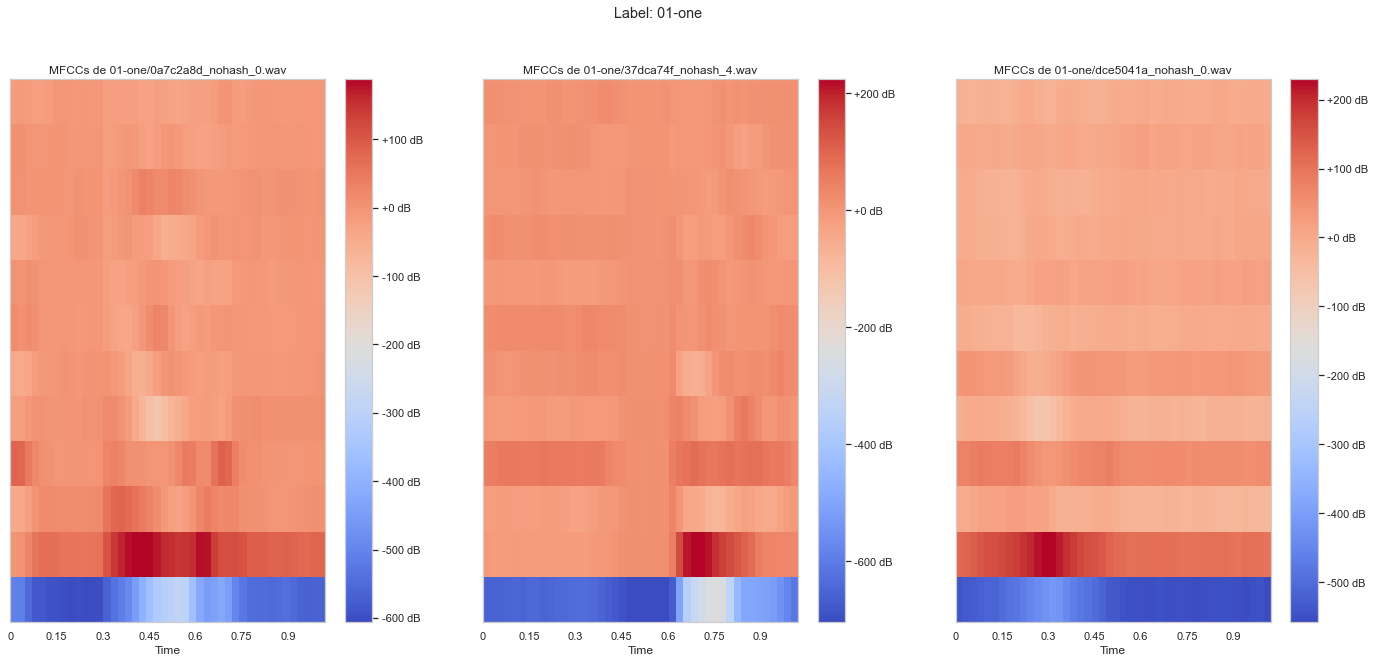

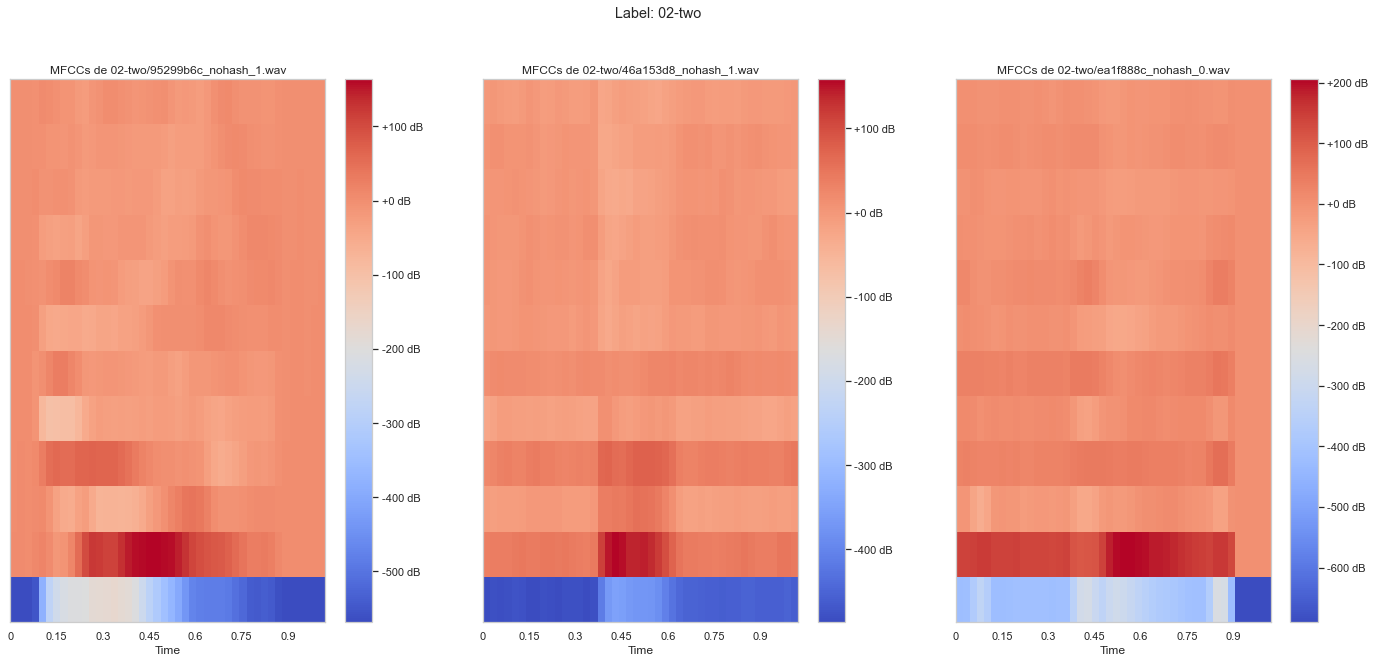

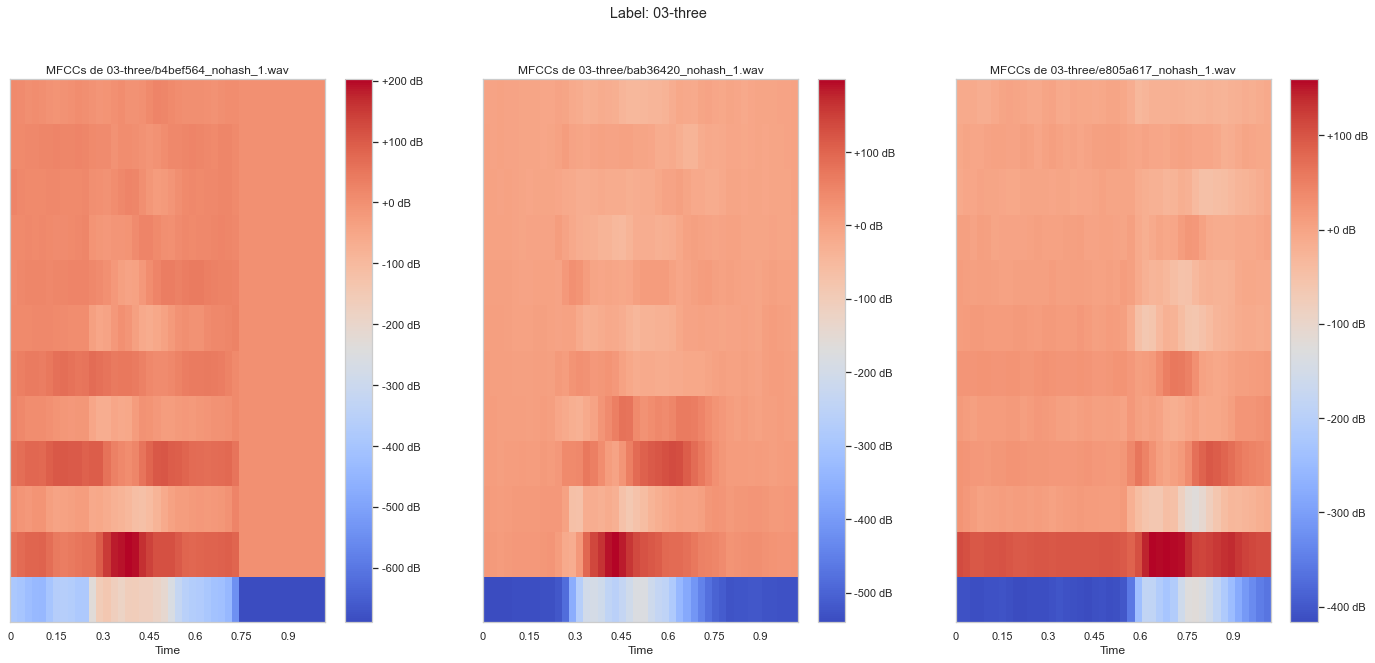

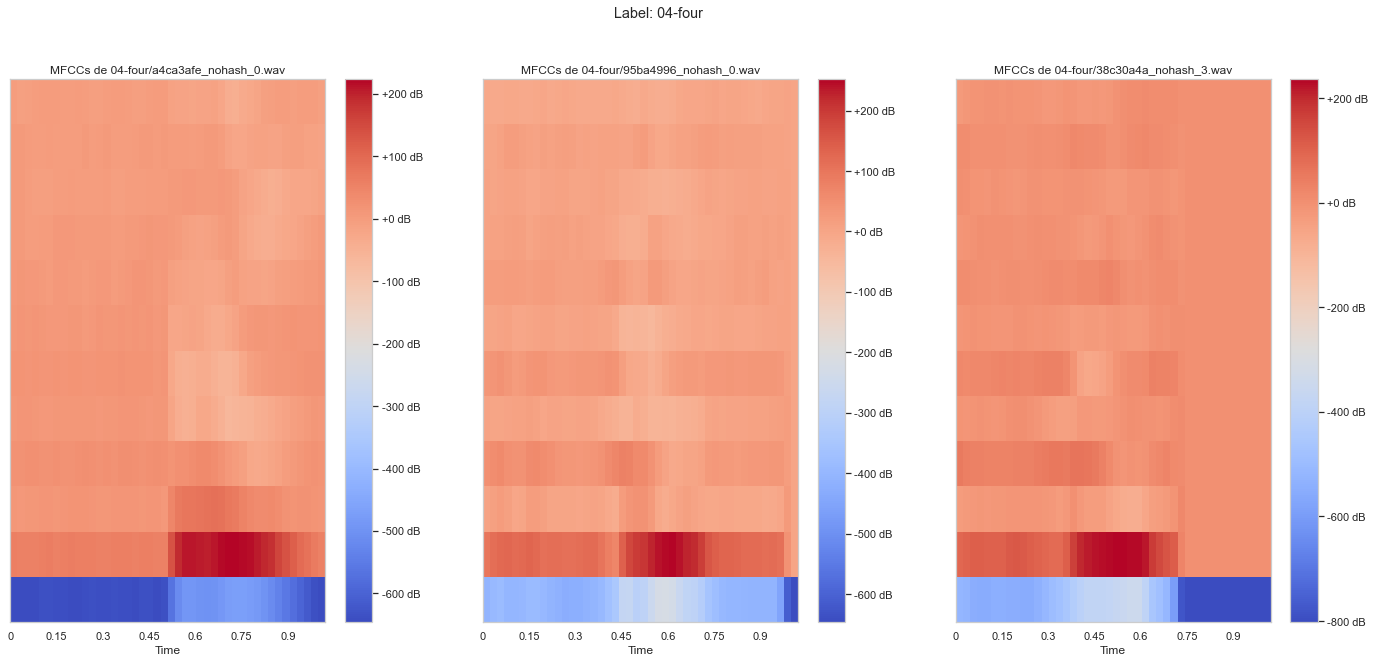

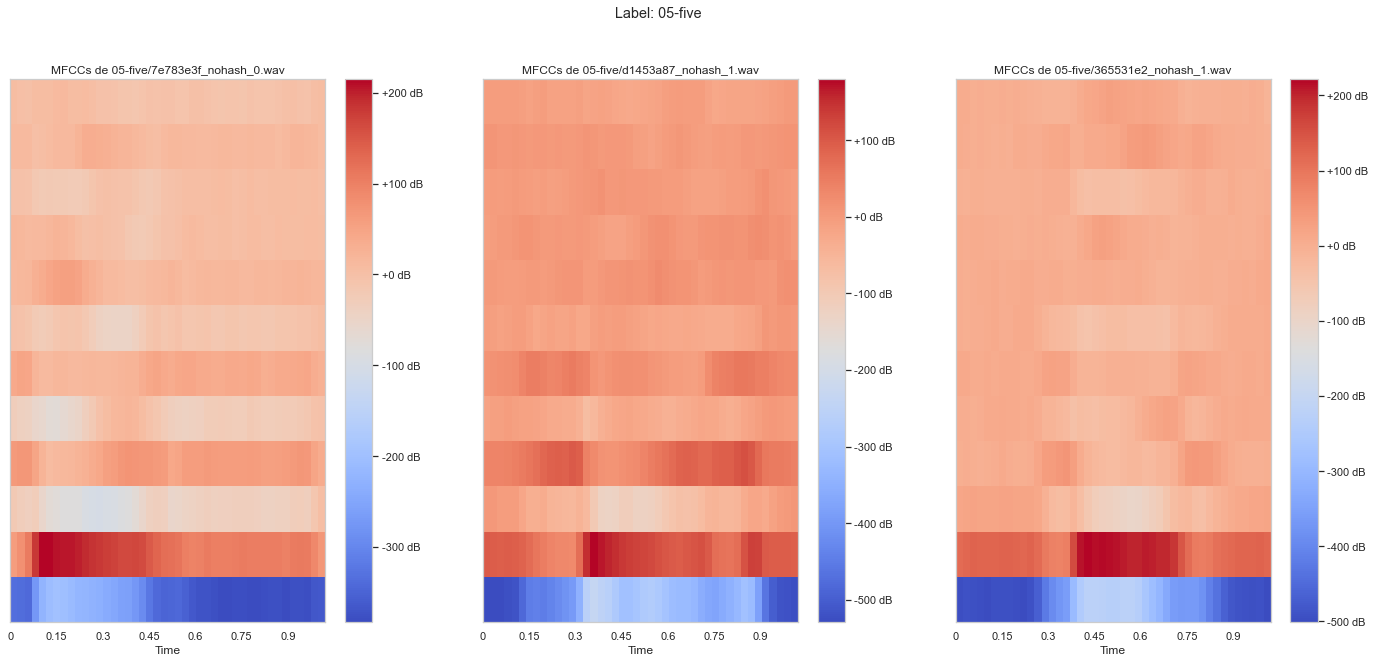

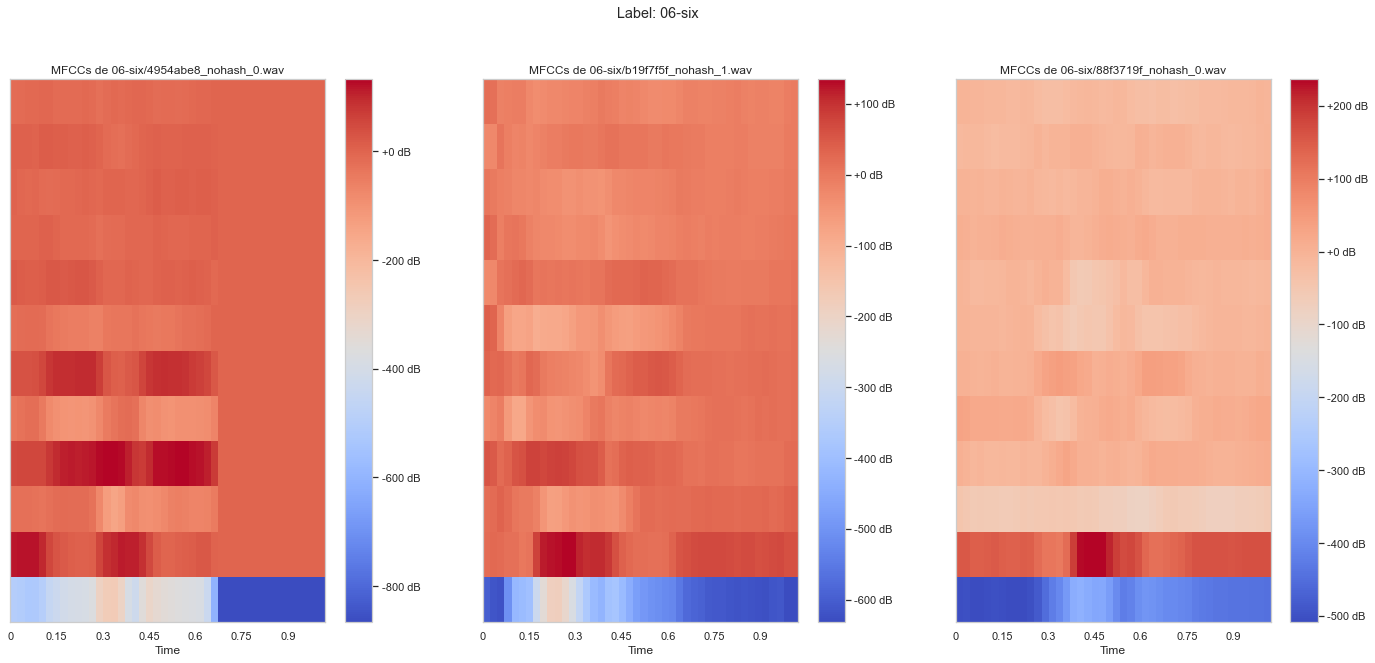

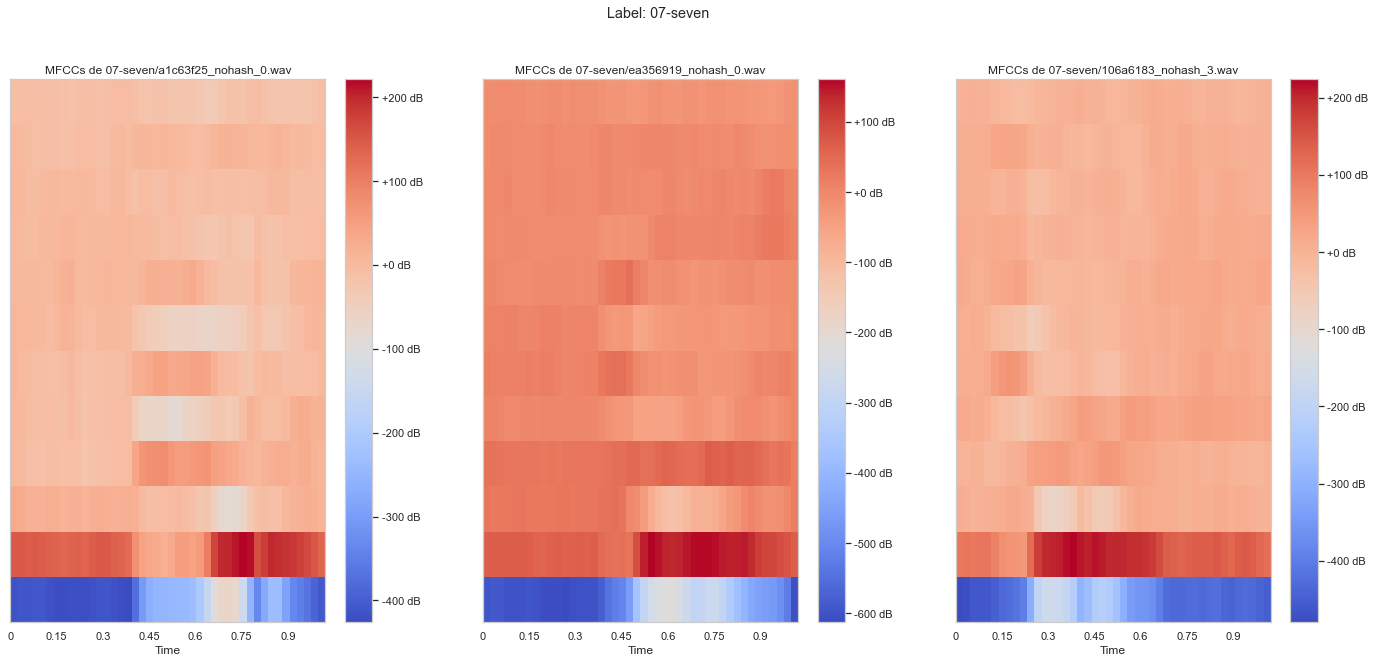

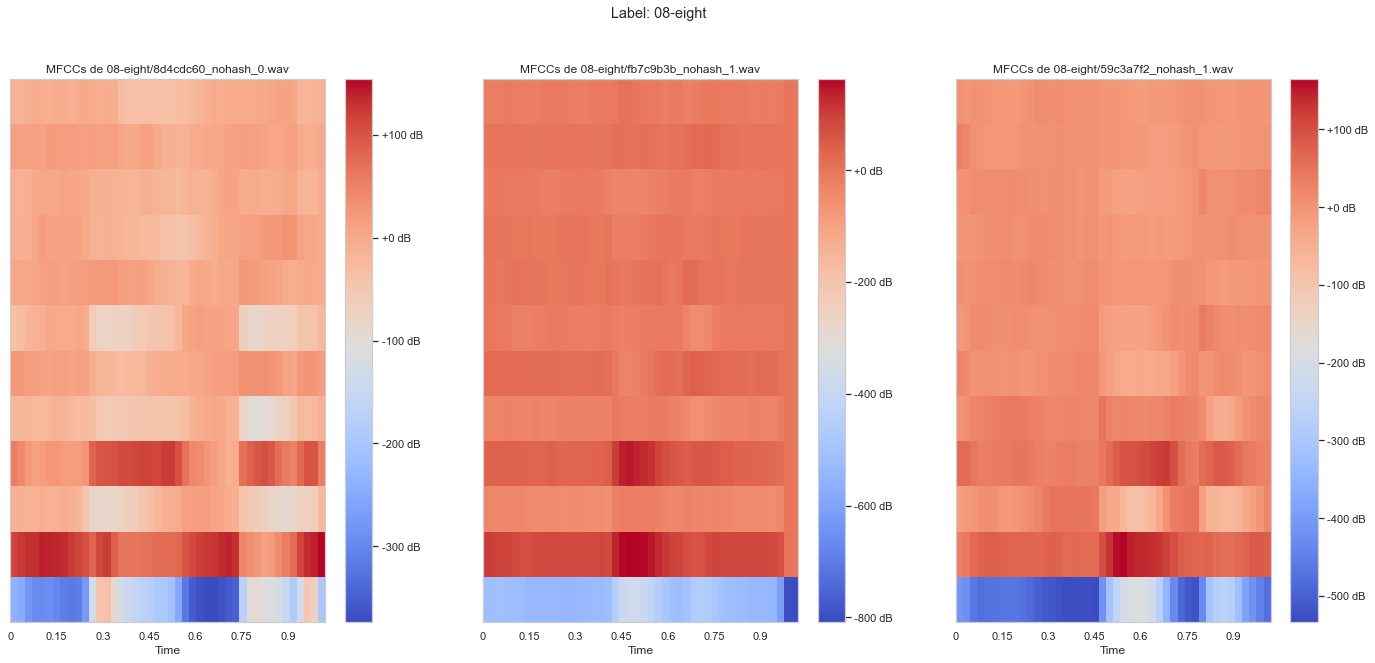

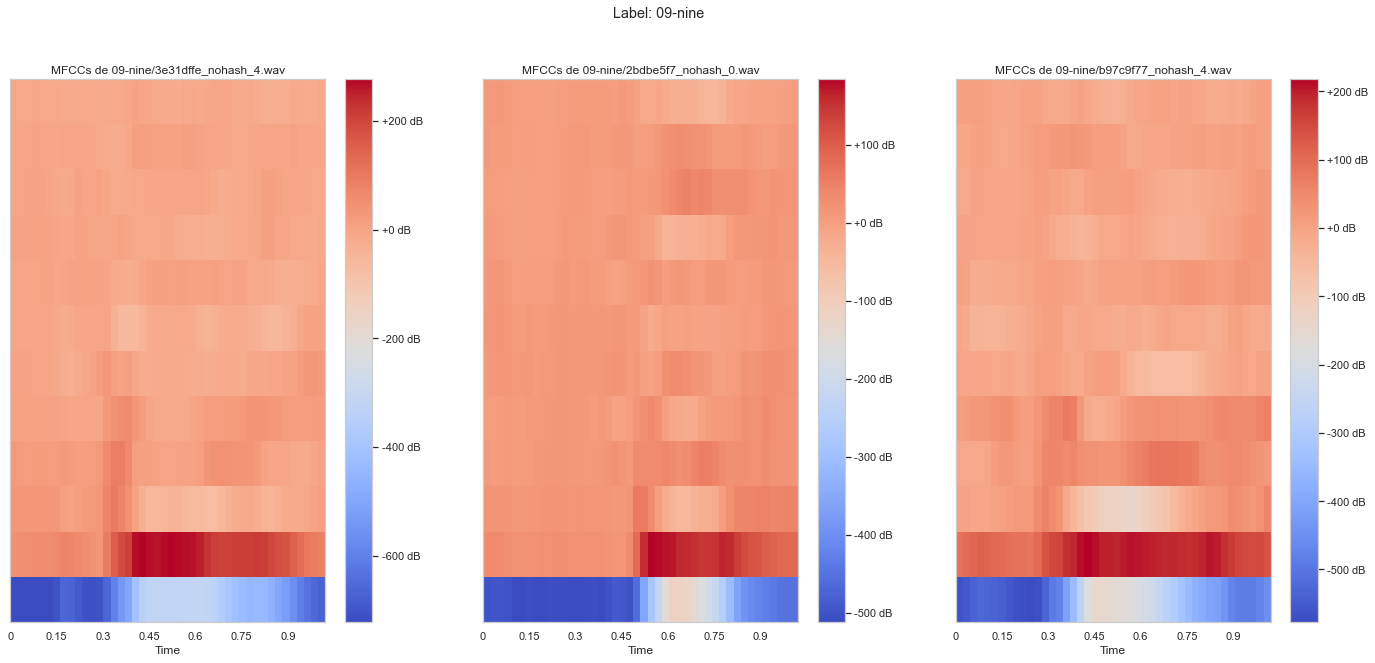

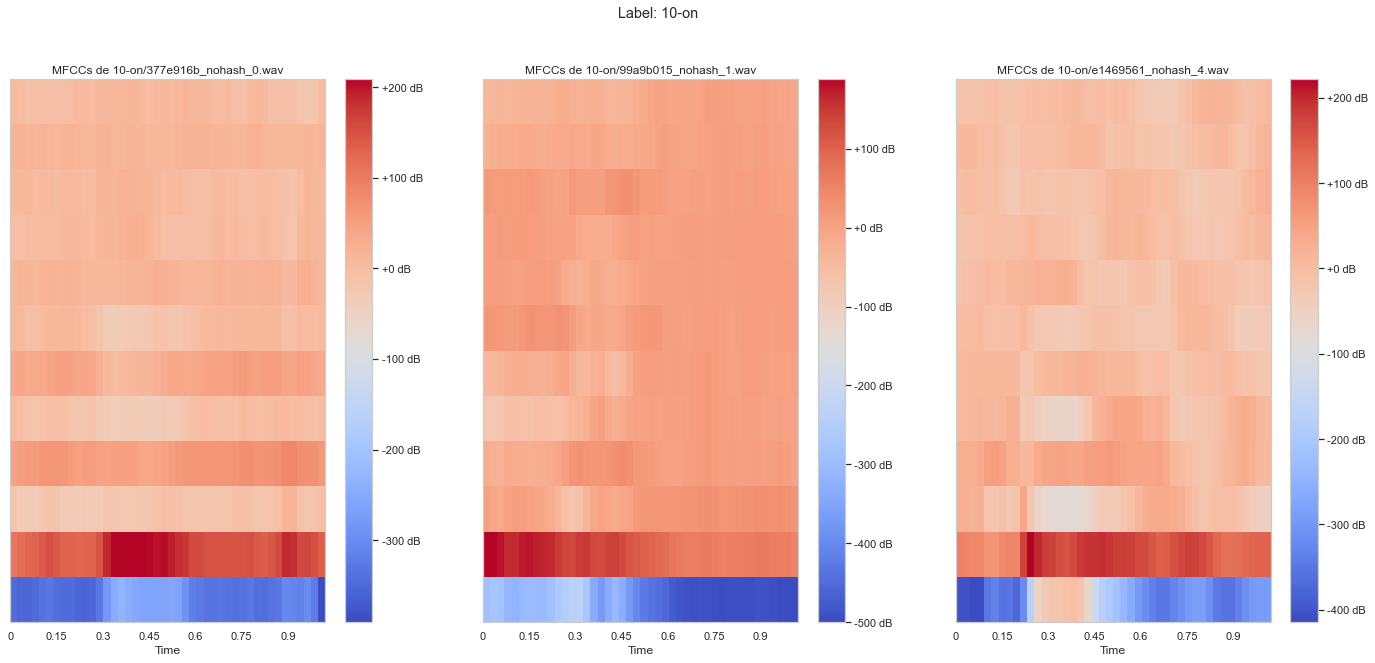

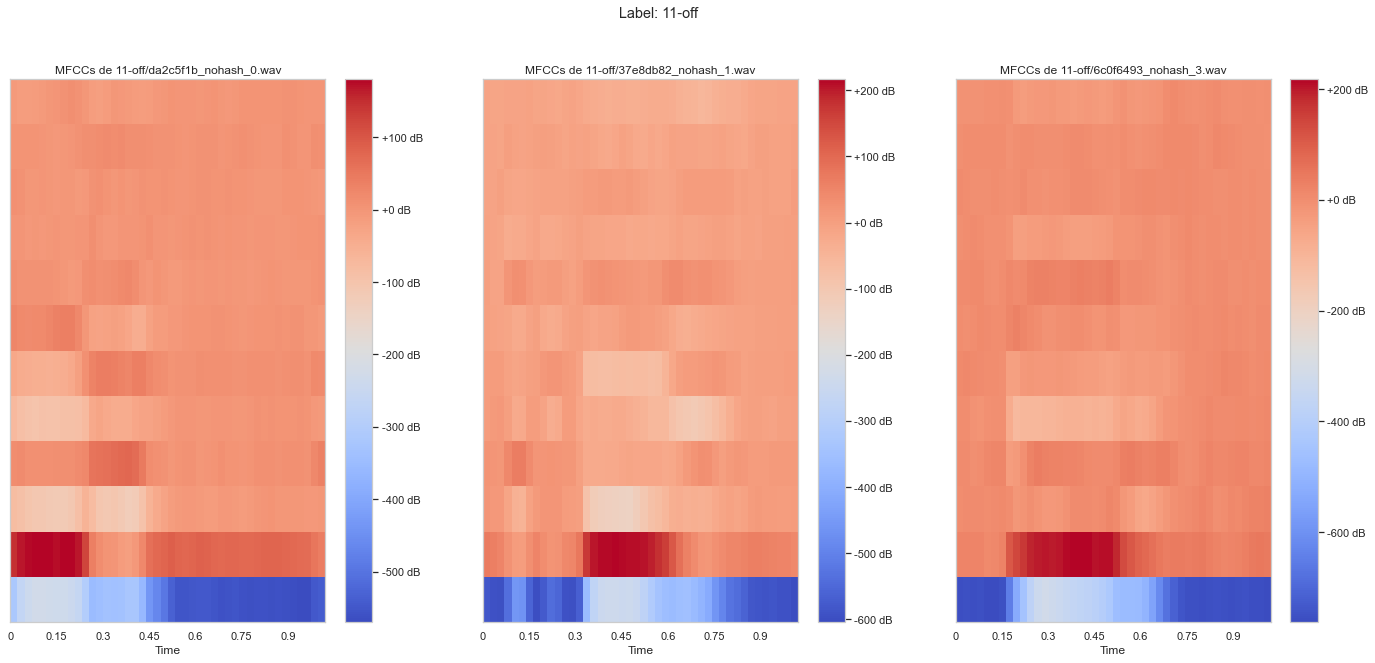

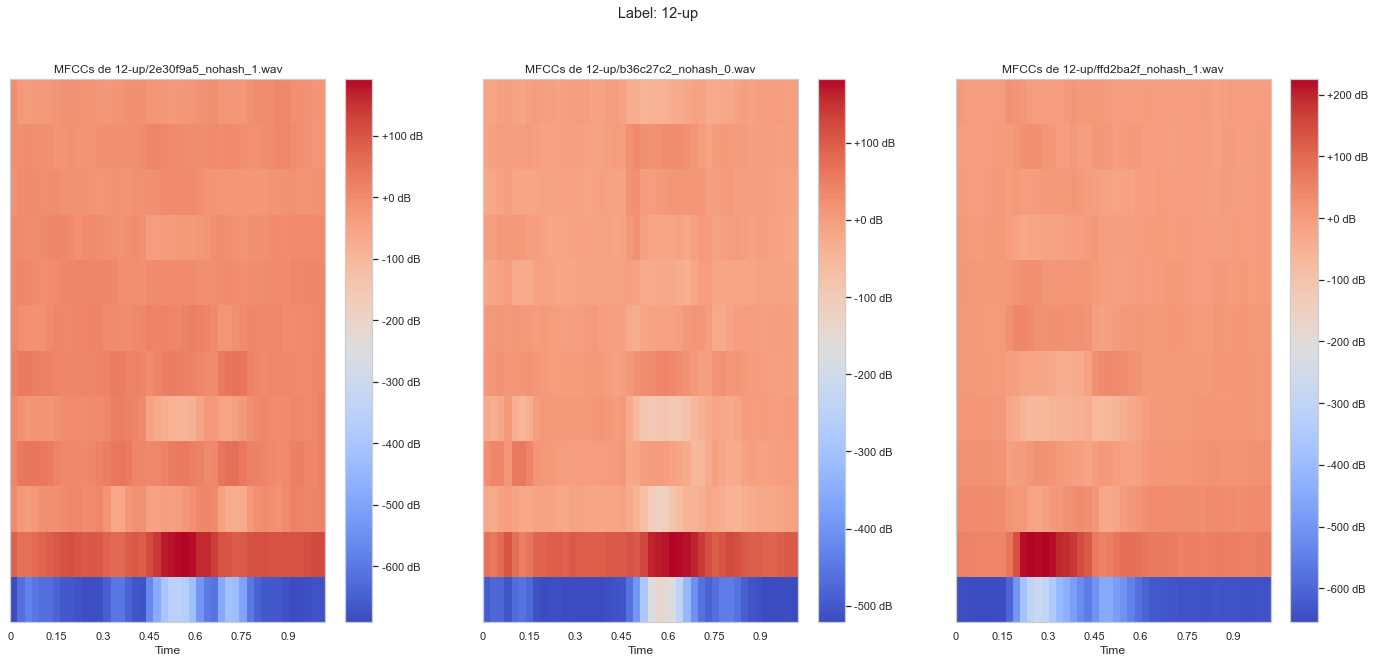

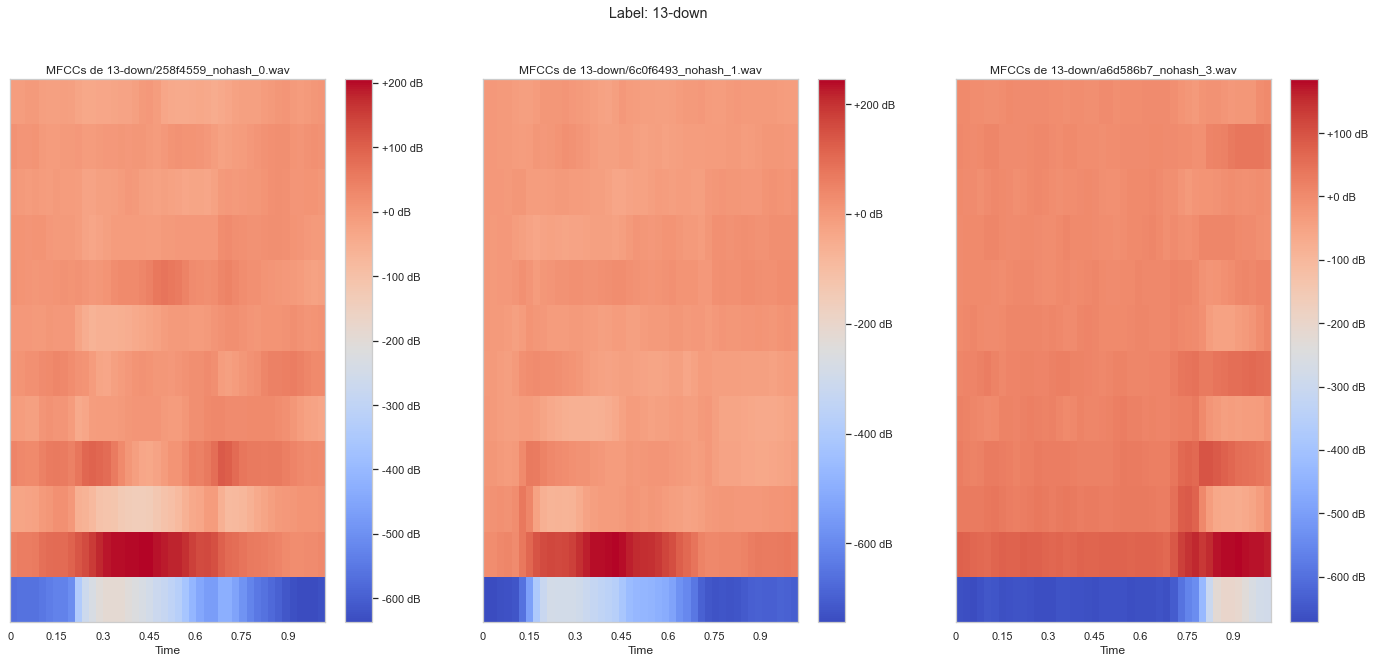

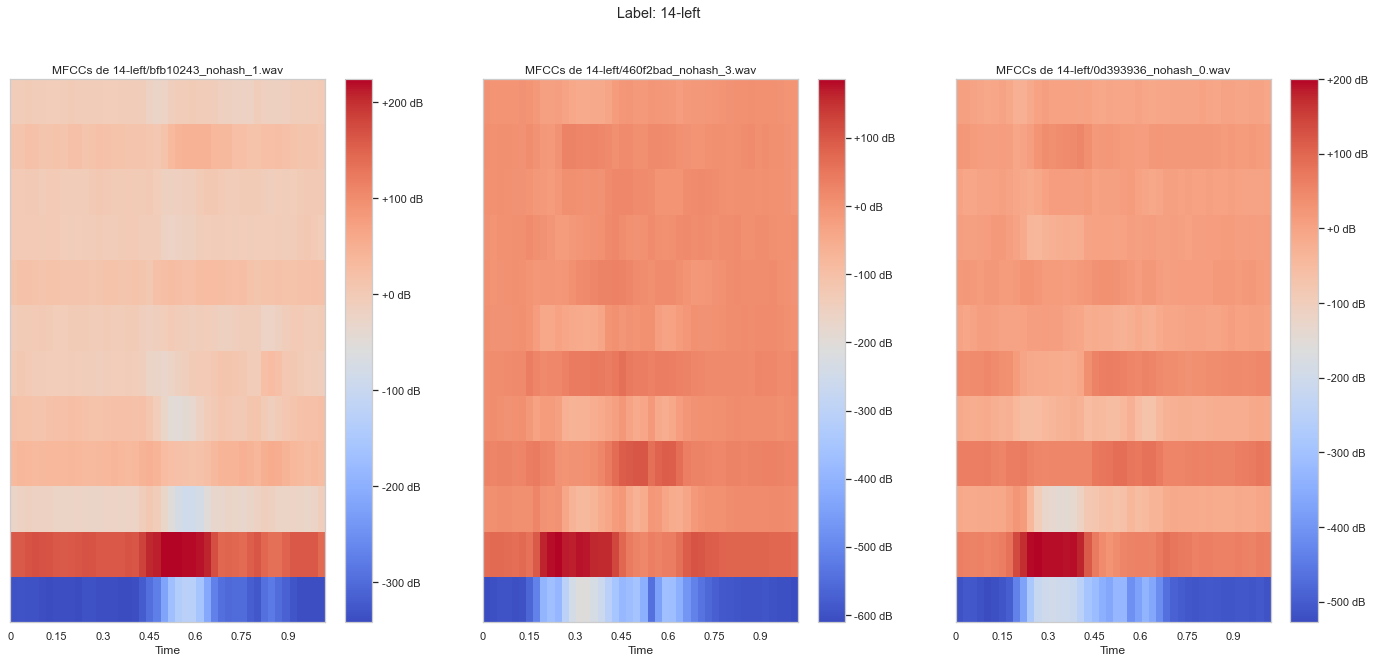

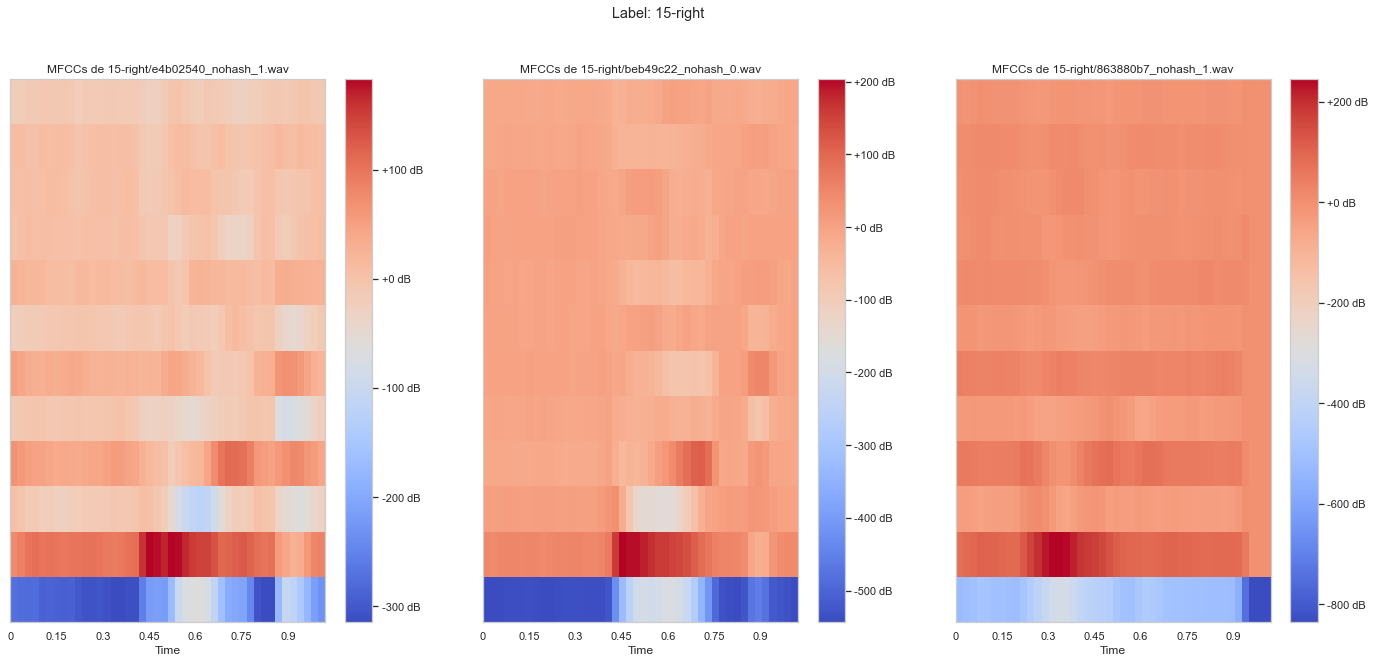

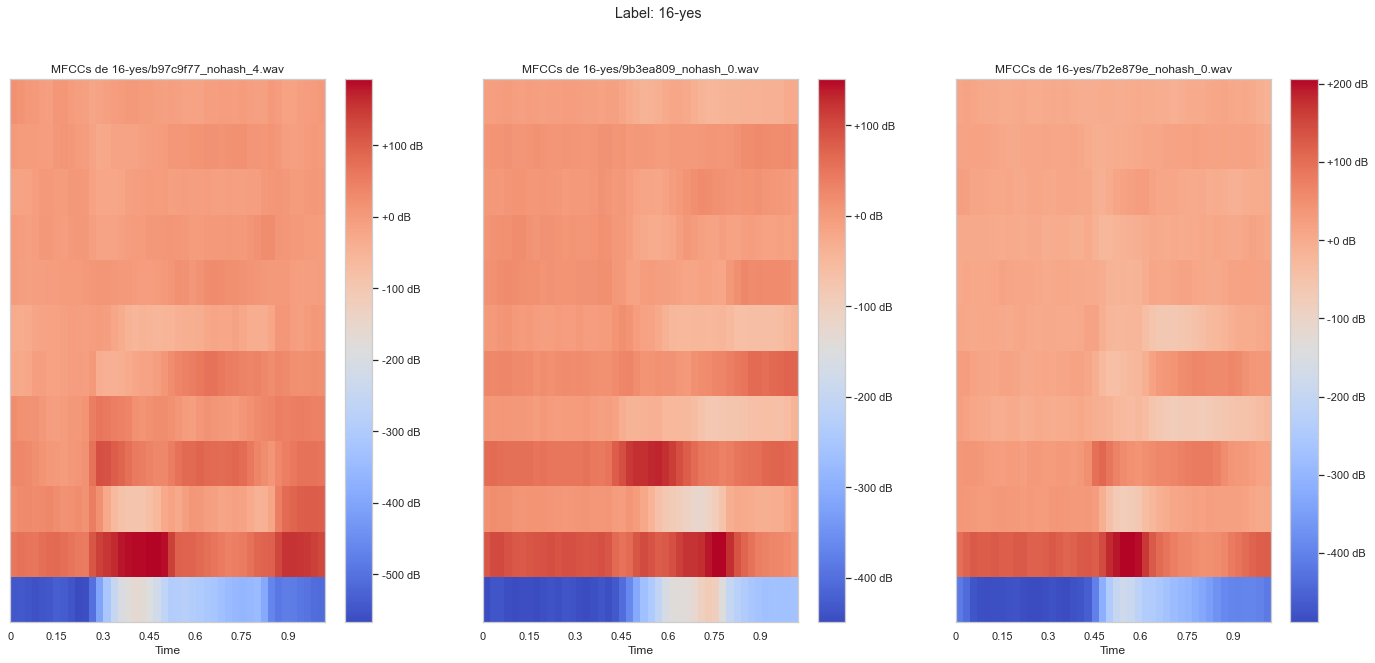

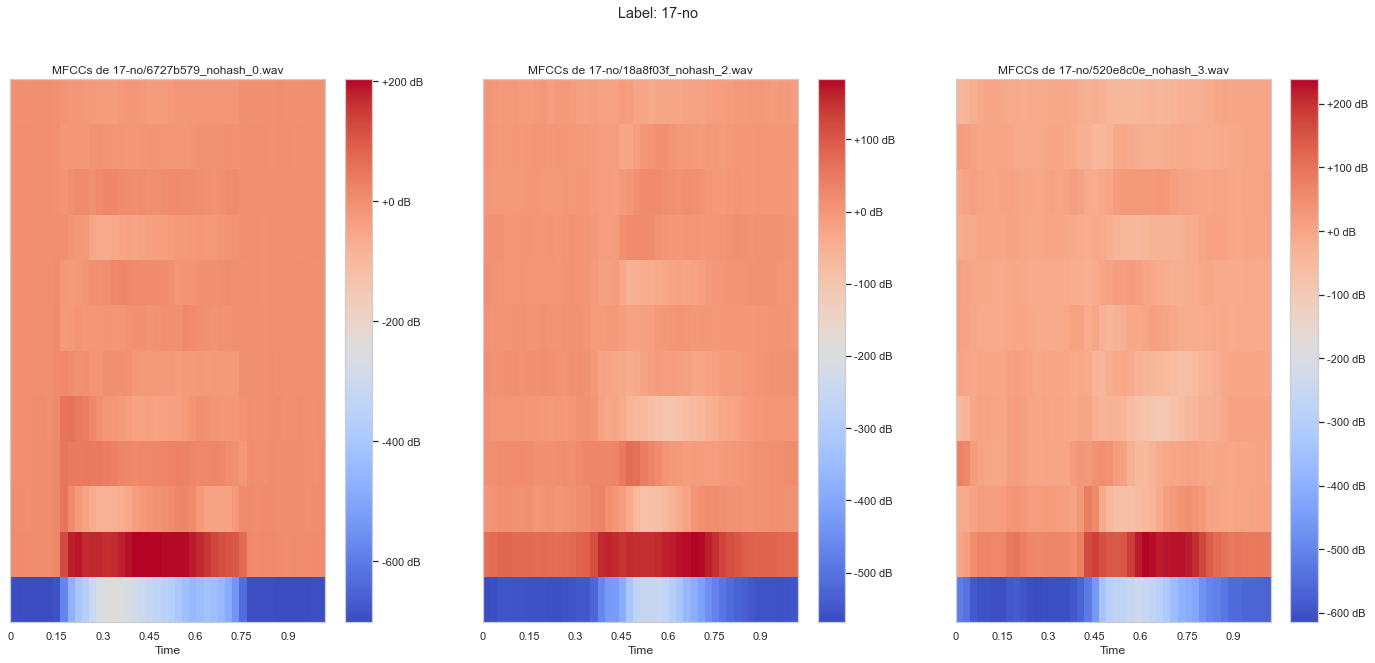

In [ ]:
for label in valid_labels:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 10))

    # FIRST AUDIO PER LABEL
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)
    
    # MFCCs plot
    MFCCs = librosa.feature.mfcc(signal, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    img = librosa.display.specshow(MFCCs, x_axis="time", sr=sample_rate, ax=ax[0])
    ax[0].set(title="MFCCs de " + filename)
    #ax[0].label_outer()
    fig.colorbar(img, ax=ax[0], format="%+2.f dB")
    
    
    # SECOND AUDIO PER LABEL
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)
    
    # MFCCs plot
    MFCCs = librosa.feature.mfcc(signal, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    img = librosa.display.specshow(MFCCs, x_axis="time", sr=sample_rate, ax=ax[1])
    ax[1].set(title="MFCCs de " + filename)
    #ax[1].label_outer()
    fig.colorbar(img, ax=ax[1], format="%+2.f dB")


    # THIRD AUDIO PER LABEL
    filename = random.choice(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/")))
    filename = os.path.join(label, filename).replace("\\", "/")
    signal, sample_rate = librosa.load(os.path.join(RAW_SPEECH_PATH, filename).replace("\\", "/"), sr=COMMON_NFRAMES_LIBROSA)
    
    # MFCCs plot
    MFCCs = librosa.feature.mfcc(signal, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    img = librosa.display.specshow(MFCCs, x_axis="time", sr=sample_rate, ax=ax[2])
    ax[2].set(title="MFCCs de " + filename)
    #ax[2].label_outer()
    fig.colorbar(img, ax=ax[2], format="%+2.f dB")
    

    plt.suptitle("Label: " + str(label))

Los MFCCs se han utilizando a lo largo de los años para el reconocimiento del lenguaje debido al conocimiento teórico que hay detrás de ellos, que los convierten en características muy adecuadas. Esto sería también válido para modelos de ML clásicos, ya que podemos considerar cada coeficiente como una característica aislada que además se podría enriquecer con otras características diferentes, de diversa naturaleza. Por ejemplo, se han utilizado modelos de mixturas gaussianas incorporando los MFCCs como características. Sin embargo, con la llegada del deep learning este pre-procesamiento y transformación de los datos ha sido sustituido, ya que las redes neuronales complejas se basan en la extracción de sus propias características cuando se las alimenta con los datos más crudos. Es por esto que en los últimos años han dejado de utilizarse.

*Además de los MFCCs como características, también se podrían incorporar los deltas y los deltas2 de dichos MFCCs como características extra, ya que estos se pueden entender como las derivadas y las derivadas segundas, proporcionando información extra.

*Podría ser interesante establecer comparaciones entre modelos clásicos (y mucho más sencillos) que tomen los MFFCs como características de entrada, y compararlos con los resultados de la red neuronal. Además, este enfoque pierde un poco la visión global del planteamiento que estamos siguiendo, ya que requiere un preprocesado y transformación un poco más lento que podría dificultar o entorpecer el trabajo hecho en la TPU.

In [ ]:
del data_MFCCs, data_MFCCs_augmented

### Información cruda del .wav

Por último, leemos de nuevo todos los audios, pero reduciendo el framerate de lectura a la 5ª parte, con el objetivo de reducir el tamaño final de los datos que se introducirán en las redes neuronales (_hacer downsampling para simplificar el volumen de datos: https://stackoverflow.com/questions/30619740/downsampling-wav-audio-file_)

Con este planteamiento se buscan probar redes densas y RNNs que intenten aprender de la secuencia cruda de los datos.

In [ ]:
downsampled_sample_rate = int(COMMON_NFRAMES_LIBROSA/5) # divide by 5 to leave the number of frames around 4k, so that the the final file won't be huge

data_raw_signals = {
    "mappings": [],
    "labels": [], 
    "signals": [],
    "files": []
}
data_raw_signals_augmented = {
    "mappings": [],
    "labels": [], 
    "signals": [],
    "files": []
}

for i, label in enumerate(labels):
    data_raw_signals["mappings"].append([label, i])
    data_raw_signals_augmented["mappings"].append([label, i])

    print(label)
    for file in tqdm(os.listdir(os.path.join(RAW_SPEECH_PATH, label).replace("\\", "/"))):
        if file.endswith(".wav"):
            filename = os.path.join(RAW_SPEECH_PATH, label, file).replace("\\", "/")
            signal, sample_rate = librosa.load(filename, sr=downsampled_sample_rate)

            # store data
            data_raw_signals["labels"].append(i)
            data_raw_signals["signals"].append(signal.tolist())
            data_raw_signals["files"].append(filename)

    for file in tqdm(os.listdir(os.path.join(MODIFIED_SPEECH_PATH, label).replace("\\", "/"))):
        if file.endswith(".wav"):
            filename = os.path.join(MODIFIED_SPEECH_PATH, label, file).replace("\\", "/")
            signal, sample_rate = librosa.load(filename, sr=downsampled_sample_rate)

            # store data
            data_raw_signals_augmented["labels"].append(i)
            data_raw_signals_augmented["signals"].append(signal.tolist())
            data_raw_signals_augmented["files"].append(filename)

00-zero


100%|██████████| 965/965 [00:28<00:00, 33.40it/s]


01-one


100%|██████████| 952/952 [00:29<00:00, 32.57it/s]


02-two


100%|██████████| 997/997 [00:29<00:00, 33.52it/s]


03-three


100%|██████████| 1003/1003 [00:30<00:00, 32.90it/s]


04-four


100%|██████████| 937/937 [00:28<00:00, 33.33it/s]


05-five


100%|██████████| 825/825 [00:25<00:00, 32.60it/s]


06-six


100%|██████████| 952/952 [00:29<00:00, 32.11it/s]


07-seven


100%|██████████| 881/881 [00:26<00:00, 32.63it/s]


08-eight


100%|██████████| 932/932 [00:29<00:00, 31.87it/s]


09-nine


100%|██████████| 920/920 [00:27<00:00, 32.95it/s]


10-on


100%|██████████| 917/917 [00:28<00:00, 32.55it/s]


11-off


100%|██████████| 832/832 [00:25<00:00, 32.78it/s]


12-up


100%|██████████| 864/864 [00:26<00:00, 32.18it/s]


13-down


100%|██████████| 893/893 [00:26<00:00, 33.25it/s]


14-left


100%|██████████| 887/887 [00:27<00:00, 32.65it/s]


15-right


100%|██████████| 898/898 [00:27<00:00, 32.76it/s]


16-yes


100%|██████████| 940/940 [00:28<00:00, 32.50it/s]


17-no


100%|██████████| 967/967 [00:30<00:00, 32.12it/s]


In [ ]:
# Export JSON files
#with open(os.path.join(JSON_PATH, "data_raw_signals.json").replace("\\", "/"), "w") as json_file:
#    json.dump(data_raw_signals, json_file, indent=4)

#with open(os.path.join(JSON_PATH, "data_raw_signals_augmented.json").replace("\\", "/"), "w") as json_file:
#    json.dump(data_raw_signals_augmented, json_file, indent=4)

# Due to memory issues when loading these json files, we export them in npy format, to compress them more and make the import faster and easier
np.save(os.path.join(JSON_PATH, "X_normal_raws.npy").replace("\\", "/"), np.array(data_raw_signals["signals"]))
np.save(os.path.join(JSON_PATH, "y_normal_raws.npy").replace("\\", "/"), np.array(data_raw_signals["labels"]))
np.save(os.path.join(JSON_PATH, "X_augmented_raws.npy").replace("\\", "/"), np.array(data_raw_signals_augmented["signals"]))
np.save(os.path.join(JSON_PATH, "y_augmented_raws.npy").replace("\\", "/"), np.array(data_raw_signals_augmented["labels"]))

In [ ]:
del data_raw_signals, data_raw_signals_augmented

Con esto damos por terminado el análisis y transformación en información de los datos crudos. Con esta información podemos pasa a entrenar los modelos y ver cómo responden al aprendizaje.